In [3]:
import os 
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F 
import numpy as np
import gym
import warnings
import matplotlib.pyplot as plt
from agent import *
from memory import *
from torch.distributions.categorical import Categorical
warnings.simplefilter("ignore")




In [4]:
class PPOMemory():
    """
    Memory for PPO
    """
    def  __init__(self, batch_size):
        self.states = []
        self.actions= []
        self.action_probs = []
        self.rewards = []
        self.vals = []
        self.dones = []
        
        self.batch_size = batch_size

    def generate_batches(self):
        ## suppose n_states=20 and batch_size = 4
        n_states = len(self.states)
        ##n_states should be always greater than batch_size
        ## batch_start is the starting index of every batch
        ## eg:   array([ 0,  4,  8, 12, 16]))
        batch_start = np.arange(0, n_states, self.batch_size) 
        ## random shuffling if indexes
        # eg: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
        indices = np.arange(n_states, dtype=np.int64)
        ## eg: array([12, 17,  6,  7, 10, 11, 15, 13, 18,  9,  8,  4,  3,  0,  2,  5, 14,19,  1, 16])
        np.random.shuffle(indices)
        batches = [indices[i:i+self.batch_size] for i in batch_start]
        ## eg: [array([12, 17,  6,  7]),array([10, 11, 15, 13]),array([18,  9,  8,  4]),array([3, 0, 2, 5]),array([14, 19,  1, 16])]
        return np.array(self.states),np.array(self.actions),\
               np.array(self.action_probs),np.array(self.vals),np.array(self.rewards),\
               np.array(self.dones),batches
    
       
    

    def store_memory(self,state,action,action_prob,val,reward,done):
        self.states.append(state)
        self.actions.append(action)
        self.action_probs.append(action_prob)
        self.rewards.append(reward)
        self.vals.append(val)
        self.dones.append(done)

    def clear_memory(self):
        self.states = []
        self.actions= []
        self.action_probs = []
        self.rewards = []
        self.vals = []
        self.dones = []




In [5]:
## initialize actor network and critic network


class ActorNwk(nn.Module):
    def __init__(self,input_dim,out_dim,
                 adam_lr,
                 chekpoint_file,
                 hidden1_dim=256,
                 hidden2_dim=256
                 ):
        super(ActorNwk, self).__init__()

        self.actor_nwk = nn.Sequential(
            nn.Linear(*input_dim,hidden1_dim),
            nn.ReLU(),
            nn.Linear(hidden1_dim,hidden2_dim),
            nn.ReLU(),
            nn.Linear(hidden2_dim,out_dim),  
            nn.Softmax(dim=-1)
        )

        self.checkpoint_file = chekpoint_file
        self.optimizer = torch.optim.Adam(params=self.actor_nwk.parameters(),lr=adam_lr)

        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.to(self.device)

    
    def forward(self,state):
        out = self.actor_nwk(state)
        dist = Categorical(out)
        return dist

    def save_checkpoint(self):
        torch.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        self.load_state_dict(torch.load(self.checkpoint_file))



class CriticNwk(nn.Module):
    def __init__(self,input_dim,
                 adam_lr,
                 chekpoint_file,
                 hidden1_dim=256,
                 hidden2_dim=256
                 ):
        super(CriticNwk, self).__init__()

        self.critic_nwk = nn.Sequential(
            nn.Linear(*input_dim,hidden1_dim),
            nn.ReLU(),
            nn.Linear(hidden1_dim,hidden2_dim),
            nn.ReLU(),
            nn.Linear(hidden2_dim,1),  
   
        )

        self.checkpoint_file = chekpoint_file
        self.optimizer = torch.optim.Adam(params=self.critic_nwk.parameters(),lr=adam_lr)

        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.to(self.device)

    
    def forward(self,state):
        out = self.critic_nwk(state)
        return out

    def save_checkpoint(self):
        torch.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        self.load_state_dict(torch.load(self.checkpoint_file))




In [9]:
## agent

class Agent():
    def __init__(self, gamma, policy_clip,lamda, adam_lr,
                 n_epochs, batch_size, state_dim, action_dim):
        
        self.gamma = gamma 
        self.policy_clip = policy_clip
        self.lamda  = lamda
        self.n_epochs = n_epochs

        self.actor = ActorNwk(input_dim=state_dim,out_dim=action_dim,adam_lr=adam_lr,chekpoint_file='tmp/actor')
        self.critic = CriticNwk(input_dim=state_dim,adam_lr=adam_lr,chekpoint_file='tmp/ctitic')
        self.memory = PPOMemory(batch_size)

    def store_data(self,state,action,action_prob,val,reward,done):
        self.memory.store_memory(state,action,action_prob,val,reward,done)
       

    def save_models(self):
        print('... Saving Models ......')
        self.actor.save_checkpoint()
        self.critic.save_checkpoint()
    
    def load_models(self):
        print('... Loading models ...')
        self.actor.load_checkpoint()
        self.critic.load_checkpoint()

    def choose_action(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.actor.device)

        dist = self.actor(state)
        ## sample the output action from a categorical distribution of predicted actions
        action = dist.sample()
        probs = torch.squeeze(dist.log_prob(action)).item()
        action = torch.squeeze(action).item()

        ## value from critic model
        value = self.critic(state)
        value = torch.squeeze(value).item()

        return action, probs, value
    
    def calculate_advanatage(self,reward_arr,value_arr,dones_arr):
        time_steps = len(reward_arr)
        advantage = np.zeros(len(reward_arr), dtype=np.float32)

        for t in range(0,time_steps-1):
            discount = 1
            running_advantage = 0
            for k in range(t,time_steps-1):
                if int(dones_arr[k]) == 1:
                    running_advantage += reward_arr[k] - value_arr[k]
                else:
                
                    running_advantage += reward_arr[k] + (self.gamma*value_arr[k+1]) - value_arr[k]

                running_advantage = discount * running_advantage
                # running_advantage += discount*(reward_arr[k] + self.gamma*value_arr[k+1]*(1-int(dones_arr[k])) - value_arr[k])
                discount *= self.gamma * self.lamda
            
            advantage[t] = running_advantage
        advantage = torch.tensor(advantage).to(self.actor.device)
        return advantage
    
    def learn(self):
        for _ in range(self.n_epochs):

            ## initially all will be empty arrays
            state_arr, action_arr, old_prob_arr, value_arr,\
            reward_arr, dones_arr, batches = \
                    self.memory.generate_batches()
            
            advantage_arr = self.calculate_advanatage(reward_arr,value_arr,dones_arr)
            values = torch.tensor(value_arr).to(self.actor.device)

            for batch in batches:
                states = torch.tensor(state_arr[batch], dtype=torch.float).to(self.actor.device)
                old_probs = torch.tensor(old_prob_arr[batch]).to(self.actor.device)
                actions = torch.tensor(action_arr[batch]).to(self.actor.device)

                dist = self.actor(states)
                critic_value = self.critic(states)
                # print('critic_value = ', critic_value)
                critic_value = torch.squeeze(critic_value)

                new_probs = dist.log_prob(actions)
                prob_ratio = new_probs.exp() / old_probs.exp()
                #prob_ratio = (new_probs - old_probs).exp()
                weighted_probs = advantage_arr[batch] * prob_ratio
                weighted_clipped_probs = torch.clamp(prob_ratio, 1-self.policy_clip,
                        1+self.policy_clip)*advantage_arr[batch]
                actor_loss = -torch.min(weighted_probs, weighted_clipped_probs).mean()

                returns = advantage_arr[batch] + values[batch]
                critic_loss = (returns-critic_value)**2
                critic_loss = critic_loss.mean()

                total_loss = actor_loss + 0.5*critic_loss
                self.actor.optimizer.zero_grad()
                self.critic.optimizer.zero_grad()
                total_loss.backward()
                self.actor.optimizer.step()
                self.critic.optimizer.step()

        self.memory.clear_memory()   




1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
... Saving Models ......
episode 0 score 15.0 avg score 15.0 time_steps 15 learning_steps 0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
... Saving Models ......
episode 1 score 24.0 avg score 19.5 time_steps 39 learning_steps 1
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
... Saving Models ......
episode 2 score 61.0 avg score 33.3 time_steps 100 learning_steps 5
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
episode 3 score 16.0 avg score 29.0 time_steps 116 learning_steps 5
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
episode 4 score 21.0 avg score 27.4 time_steps 137 learning_steps 6
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0

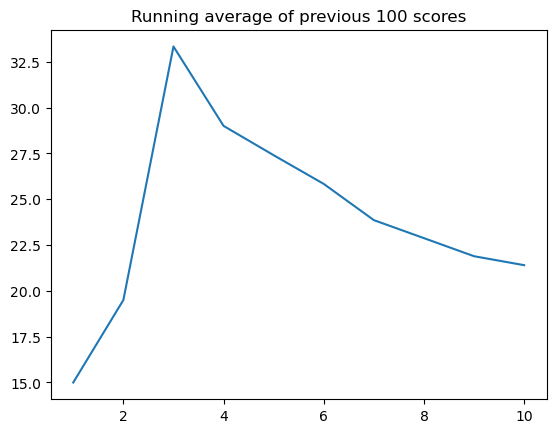

In [ ]:




def plot_learning_curve(x, scores, figure_file):
    running_avg = np.zeros(len(scores))
    for i in range(len(running_avg)):
        running_avg[i] = np.mean(scores[max(0, i-100):(i+1)])
    plt.plot(x, running_avg)
    plt.title('Running average of previous 100 scores')
    plt.savefig(figure_file)


### directory for saving models ###
if not os.path.exists('tmp'):
    os.makedirs('tmp')


env = gym.make('CartPole-v0')
N = 20
batch_size = 5
n_epochs = 4
alpha = 0.0003
agent = Agent(state_dim=env.observation_space.shape,
              action_dim=env.action_space.n, 
              batch_size=batch_size,
              n_epochs=n_epochs,
              policy_clip=0.2,
              gamma=0.99,lamda=0.95, 
              adam_lr=alpha)
n_games = 10
figure_file = 'cartpole.png'
best_score = env.reward_range[0]
score_history = []
learn_iters = 0
avg_score = 0
n_steps = 0
for i in range(n_games):
    current_state,info = env.reset()
    terminated,truncated = False,False
    done = False
    score = 0
    while not done:
        action, prob, val = agent.choose_action(current_state)
        next_state, reward, terminated, truncated, info = env.step(action)
        # print(reward)
        done = 1 if (terminated or truncated) else 0
        n_steps += 1
        score += reward
        agent.store_data(current_state, action, prob, val, reward, done)
        if n_steps % N == 0:
            agent.learn()
            learn_iters += 1
        current_state = next_state
    score_history.append(score)
    avg_score = np.mean(score_history[-100:])
    if avg_score > best_score:
        best_score = avg_score
        agent.save_models()
    print('episode', i, 'score %.1f' % score, 'avg score %.1f' % avg_score,
            'time_steps', n_steps, 'learning_steps', learn_iters)
    
    
x = [i+1 for i in range(len(score_history))]
plot_learning_curve(x, score_history, figure_file)



[0.01170297 0.00949126 0.02758459 0.01931779] [ 0.01189279  0.20420697  0.02797095 -0.26453584] 1
New state:  [ 0.01189279  0.20420697  0.02797095 -0.26453584] Reward:  1.0 Terminated:  False Truncated:  False


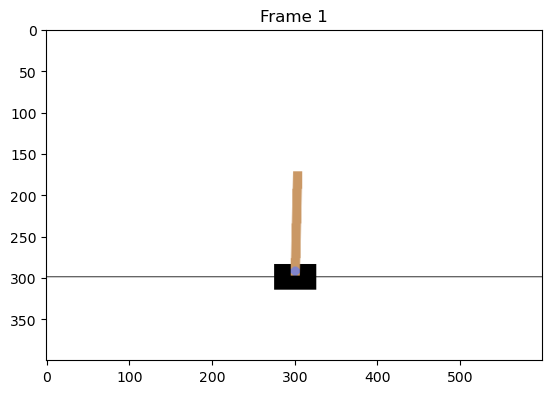

[ 0.01189279  0.20420697  0.02797095 -0.26453584] [ 0.01597693  0.39891875  0.02268023 -0.5482669 ] 1
New state:  [ 0.01597693  0.39891875  0.02268023 -0.5482669 ] Reward:  1.0 Terminated:  False Truncated:  False


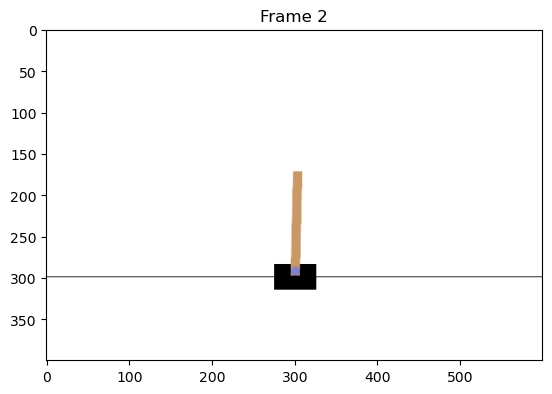

[ 0.01597693  0.39891875  0.02268023 -0.5482669 ] [ 0.02395531  0.20348565  0.0117149  -0.2485252 ] 0
New state:  [ 0.02395531  0.20348565  0.0117149  -0.2485252 ] Reward:  1.0 Terminated:  False Truncated:  False


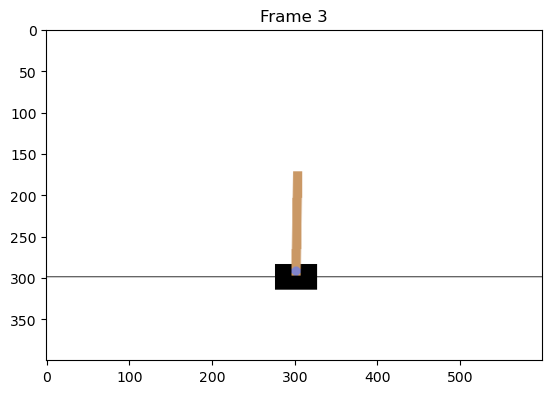

[ 0.02395531  0.20348565  0.0117149  -0.2485252 ] [ 0.02802502  0.39843836  0.00674439 -0.53749007] 1
New state:  [ 0.02802502  0.39843836  0.00674439 -0.53749007] Reward:  1.0 Terminated:  False Truncated:  False


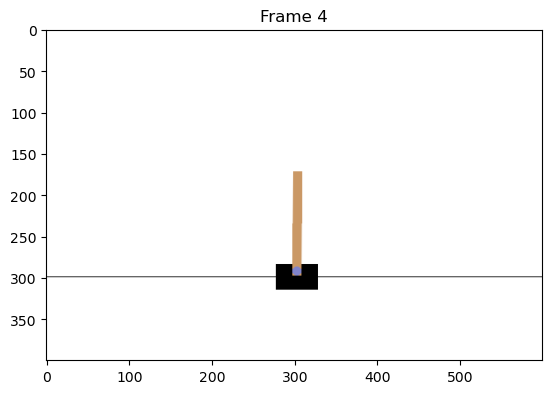

[ 0.02802502  0.39843836  0.00674439 -0.53749007] [ 0.03599378  0.20322224 -0.00400541 -0.24268973] 0
New state:  [ 0.03599378  0.20322224 -0.00400541 -0.24268973] Reward:  1.0 Terminated:  False Truncated:  False


[ 0.03599378  0.20322224 -0.00400541 -0.24268973] [ 0.04005823  0.00815773 -0.0088592   0.0487271 ] 0
New state:  [ 0.04005823  0.00815773 -0.0088592   0.0487271 ] Reward:  1.0 Terminated:  False Truncated:  False


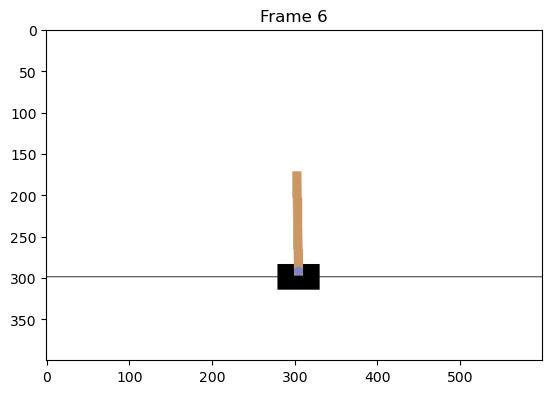

[ 0.04005823  0.00815773 -0.0088592   0.0487271 ] [ 0.04022139  0.20340559 -0.00788466 -0.24673776] 1
New state:  [ 0.04022139  0.20340559 -0.00788466 -0.24673776] Reward:  1.0 Terminated:  False Truncated:  False


[ 0.04022139  0.20340559 -0.00788466 -0.24673776] [ 0.0442895   0.00839713 -0.01281942  0.04344777] 0
New state:  [ 0.0442895   0.00839713 -0.01281942  0.04344777] Reward:  1.0 Terminated:  False Truncated:  False


[ 0.0442895   0.00839713 -0.01281942  0.04344777] [ 0.04445744  0.20370054 -0.01195046 -0.2532521 ] 1
New state:  [ 0.04445744  0.20370054 -0.01195046 -0.2532521 ] Reward:  1.0 Terminated:  False Truncated:  False


[ 0.04445744  0.20370054 -0.01195046 -0.2532521 ] [ 0.04853145  0.00875125 -0.0170155   0.03563762] 0
New state:  [ 0.04853145  0.00875125 -0.0170155   0.03563762] Reward:  1.0 Terminated:  False Truncated:  False


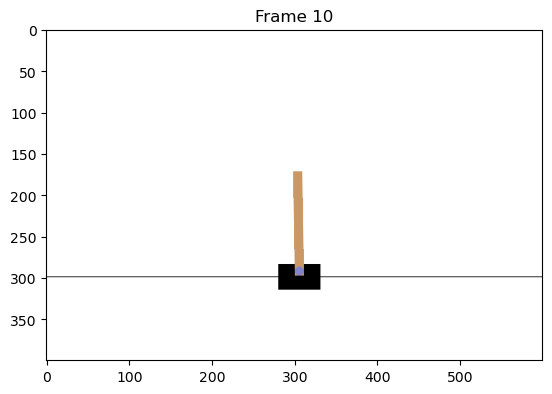

[ 0.04853145  0.00875125 -0.0170155   0.03563762] [ 0.04870648  0.20411302 -0.01630275 -0.26236492] 1
New state:  [ 0.04870648  0.20411302 -0.01630275 -0.26236492] Reward:  1.0 Terminated:  False Truncated:  False


[ 0.04870648  0.20411302 -0.01630275 -0.26236492] [ 0.05278874  0.00922753 -0.02155005  0.02513166] 0
New state:  [ 0.05278874  0.00922753 -0.02155005  0.02513166] Reward:  1.0 Terminated:  False Truncated:  False


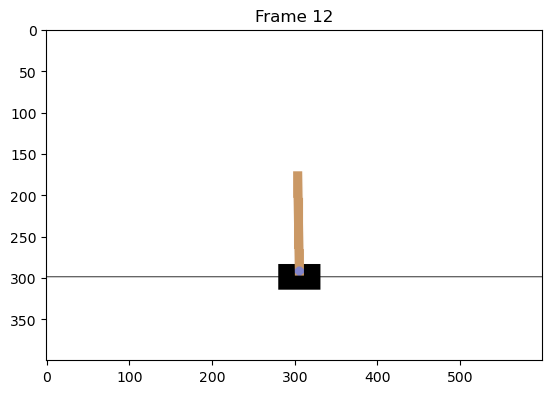

[ 0.05278874  0.00922753 -0.02155005  0.02513166] [ 0.05297329  0.20465179 -0.02104742 -0.27427188] 1
New state:  [ 0.05297329  0.20465179 -0.02104742 -0.27427188] Reward:  1.0 Terminated:  False Truncated:  False


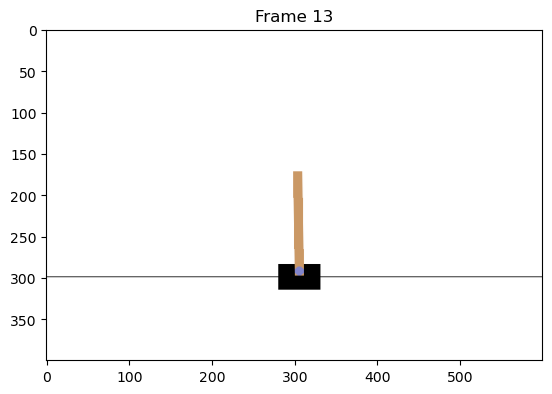

[ 0.05297329  0.20465179 -0.02104742 -0.27427188] [ 0.05706632  0.00983637 -0.02653285  0.01169903] 0
New state:  [ 0.05706632  0.00983637 -0.02653285  0.01169903] Reward:  1.0 Terminated:  False Truncated:  False


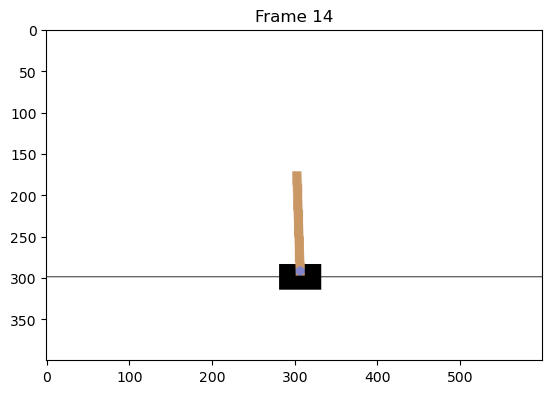

[ 0.05706632  0.00983637 -0.02653285  0.01169903] [ 0.05726305  0.20532858 -0.02629887 -0.28923583] 1
New state:  [ 0.05726305  0.20532858 -0.02629887 -0.28923583] Reward:  1.0 Terminated:  False Truncated:  False


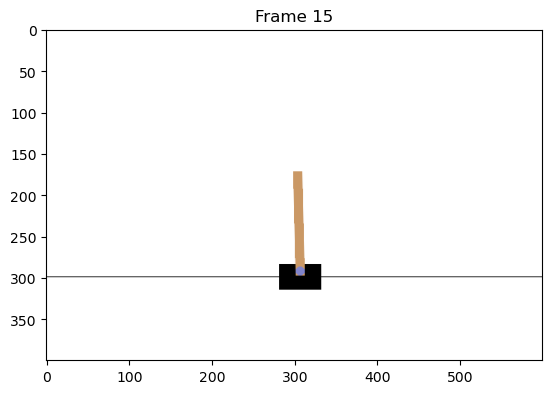

[ 0.05726305  0.20532858 -0.02629887 -0.28923583] [ 0.06136962  0.01059133 -0.03208359 -0.00496194] 0
New state:  [ 0.06136962  0.01059133 -0.03208359 -0.00496194] Reward:  1.0 Terminated:  False Truncated:  False


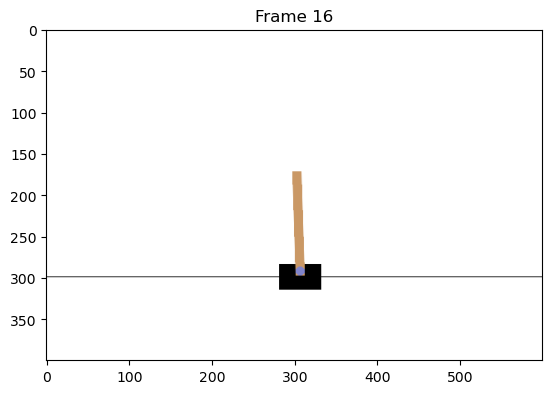

[ 0.06136962  0.01059133 -0.03208359 -0.00496194] [ 0.06158145  0.20615837 -0.03218283 -0.30759248] 1
New state:  [ 0.06158145  0.20615837 -0.03218283 -0.30759248] Reward:  1.0 Terminated:  False Truncated:  False


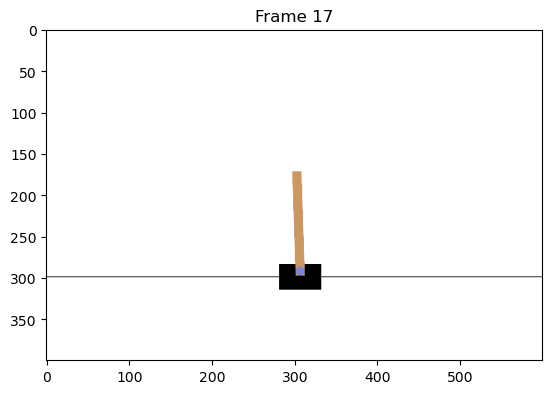

[ 0.06158145  0.20615837 -0.03218283 -0.30759248] [ 0.06570461  0.01150943 -0.03833468 -0.02523037] 0
New state:  [ 0.06570461  0.01150943 -0.03833468 -0.02523037] Reward:  1.0 Terminated:  False Truncated:  False


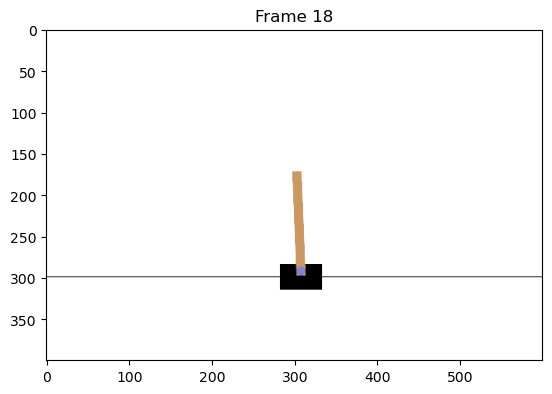

[ 0.06570461  0.01150943 -0.03833468 -0.02523037] [ 0.06593481  0.20715956 -0.03883929 -0.3297576 ] 1
New state:  [ 0.06593481  0.20715956 -0.03883929 -0.3297576 ] Reward:  1.0 Terminated:  False Truncated:  False


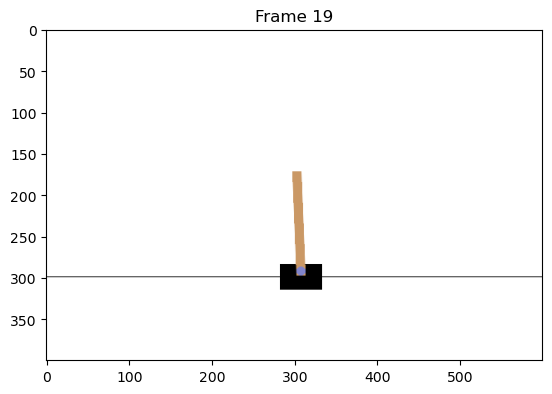

[ 0.06593481  0.20715956 -0.03883929 -0.3297576 ] [ 0.07007799  0.01261141 -0.04543444 -0.04957132] 0
New state:  [ 0.07007799  0.01261141 -0.04543444 -0.04957132] Reward:  1.0 Terminated:  False Truncated:  False


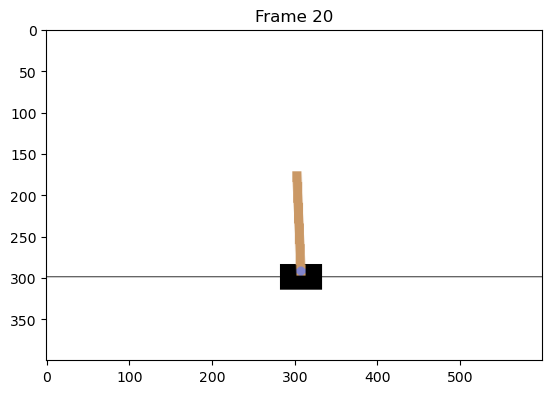

[ 0.07007799  0.01261141 -0.04543444 -0.04957132] [ 0.07033022 -0.1818306  -0.04642586  0.22843757] 0
New state:  [ 0.07033022 -0.1818306  -0.04642586  0.22843757] Reward:  1.0 Terminated:  False Truncated:  False


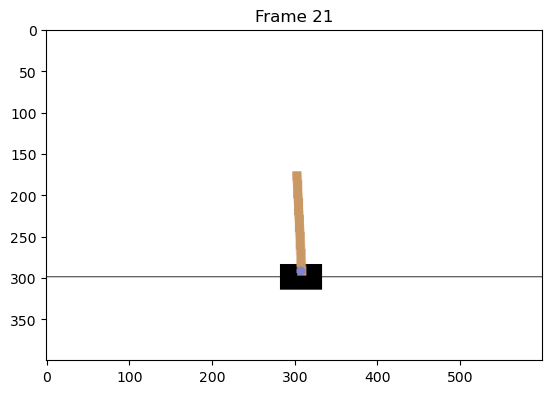

[ 0.07033022 -0.1818306  -0.04642586  0.22843757] [ 0.06669361  0.01392299 -0.04185711 -0.07852074] 1
New state:  [ 0.06669361  0.01392299 -0.04185711 -0.07852074] Reward:  1.0 Terminated:  False Truncated:  False


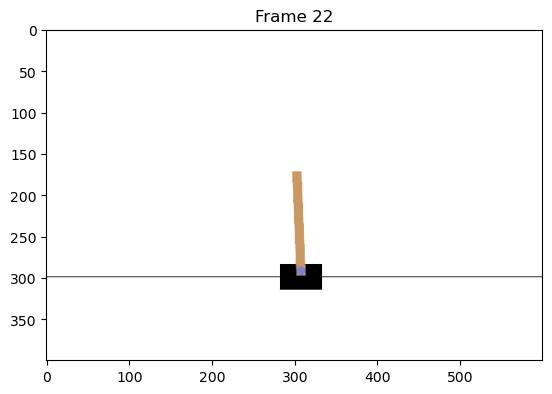

[ 0.06669361  0.01392299 -0.04185711 -0.07852074] [ 0.06697207 -0.1805747  -0.04342753  0.20066787] 0
New state:  [ 0.06697207 -0.1805747  -0.04342753  0.20066787] Reward:  1.0 Terminated:  False Truncated:  False


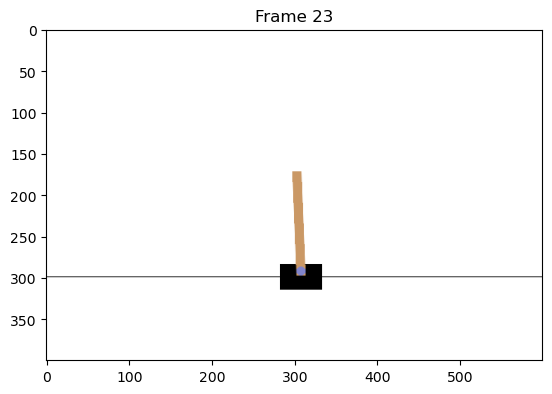

[ 0.06697207 -0.1805747  -0.04342753  0.20066787] [ 0.06336058  0.01514059 -0.03941417 -0.10539196] 1
New state:  [ 0.06336058  0.01514059 -0.03941417 -0.10539196] Reward:  1.0 Terminated:  False Truncated:  False


[ 0.06336058  0.01514059 -0.03941417 -0.10539196] [ 0.06366339 -0.17939502 -0.04152201  0.17460006] 0
New state:  [ 0.06366339 -0.17939502 -0.04152201  0.17460006] Reward:  1.0 Terminated:  False Truncated:  False


[ 0.06366339 -0.17939502 -0.04152201  0.17460006] [ 0.06007549  0.01629583 -0.03803001 -0.13088717] 1
New state:  [ 0.06007549  0.01629583 -0.03803001 -0.13088717] Reward:  1.0 Terminated:  False Truncated:  False


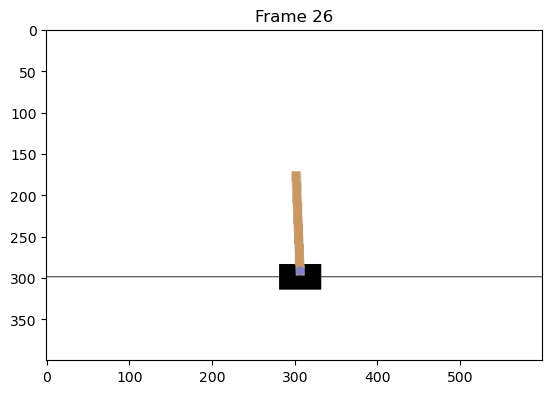

[ 0.06007549  0.01629583 -0.03803001 -0.13088717] [ 0.06040141 -0.1782613  -0.04064775  0.14955938] 0
New state:  [ 0.06040141 -0.1782613  -0.04064775  0.14955938] Reward:  1.0 Terminated:  False Truncated:  False


[ 0.06040141 -0.1782613  -0.04064775  0.14955938] [ 0.05683618  0.01741843 -0.03765656 -0.1556649 ] 1
New state:  [ 0.05683618  0.01741843 -0.03765656 -0.1556649 ] Reward:  1.0 Terminated:  False Truncated:  False


[ 0.05683618  0.01741843 -0.03765656 -0.1556649 ] [ 0.05718455 -0.17714469 -0.04076986  0.12490447] 0
New state:  [ 0.05718455 -0.17714469 -0.04076986  0.12490447] Reward:  1.0 Terminated:  False Truncated:  False


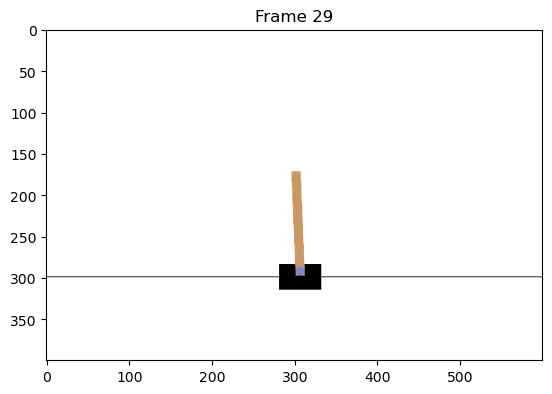

[ 0.05718455 -0.17714469 -0.04076986  0.12490447] [ 0.05364165  0.0185369  -0.03827177 -0.18035704] 1
New state:  [ 0.05364165  0.0185369  -0.03827177 -0.18035704] Reward:  1.0 Terminated:  False Truncated:  False


[ 0.05364165  0.0185369  -0.03827177 -0.18035704] [ 0.05401239 -0.17601709 -0.04187891  0.10001109] 0
New state:  [ 0.05401239 -0.17601709 -0.04187891  0.10001109] Reward:  1.0 Terminated:  False Truncated:  False


[ 0.05401239 -0.17601709 -0.04187891  0.10001109] [ 0.05049205  0.01967926 -0.03987869 -0.20558485] 1
New state:  [ 0.05049205  0.01967926 -0.03987869 -0.20558485] Reward:  1.0 Terminated:  False Truncated:  False


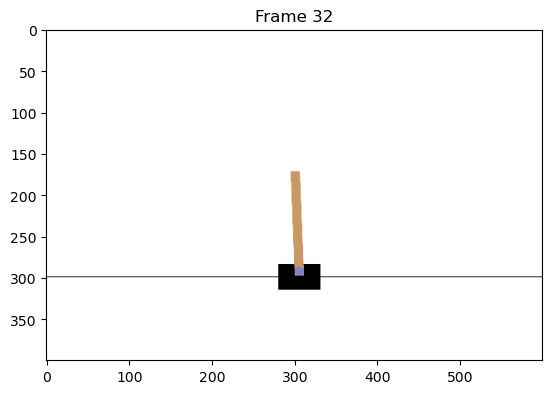

[ 0.05049205  0.01967926 -0.03987869 -0.20558485] [ 0.05088564 -0.1748504  -0.04399039  0.07425641] 0
New state:  [ 0.05088564 -0.1748504  -0.04399039  0.07425641] Reward:  1.0 Terminated:  False Truncated:  False


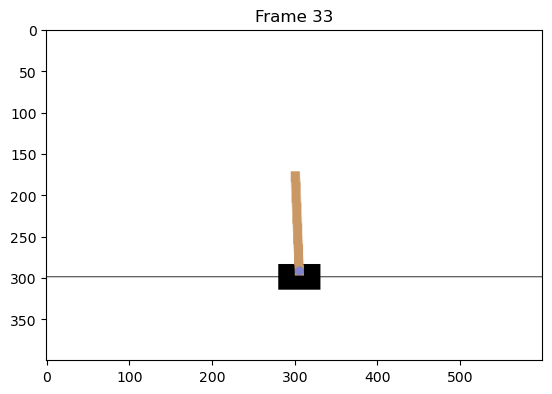

[ 0.05088564 -0.1748504  -0.04399039  0.07425641] [ 0.04738863 -0.369315   -0.04250526  0.3527421 ] 0
New state:  [ 0.04738863 -0.369315   -0.04250526  0.3527421 ] Reward:  1.0 Terminated:  False Truncated:  False


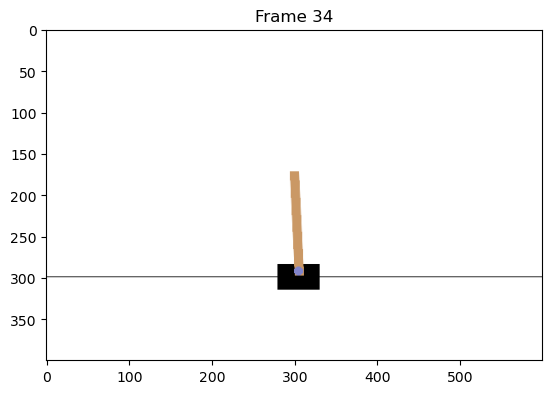

[ 0.04738863 -0.369315   -0.04250526  0.3527421 ] [ 0.04000233 -0.1736152  -0.03545042  0.04696478] 1
New state:  [ 0.04000233 -0.1736152  -0.03545042  0.04696478] Reward:  1.0 Terminated:  False Truncated:  False


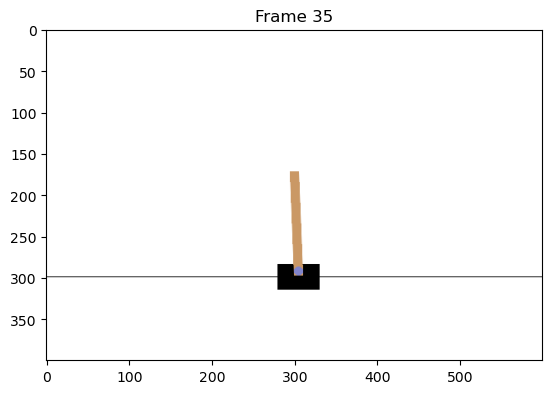

[ 0.04000233 -0.1736152  -0.03545042  0.04696478] [ 0.03653003 -0.36821136 -0.03451112  0.3282554 ] 0
New state:  [ 0.03653003 -0.36821136 -0.03451112  0.3282554 ] Reward:  1.0 Terminated:  False Truncated:  False


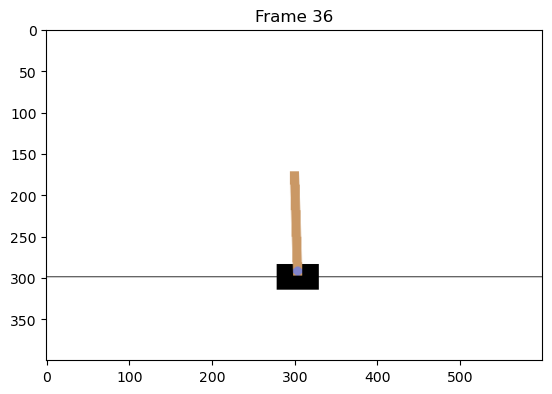

[ 0.03653003 -0.36821136 -0.03451112  0.3282554 ] [ 0.0291658  -0.17261553 -0.02794602  0.02489207] 1
New state:  [ 0.0291658  -0.17261553 -0.02794602  0.02489207] Reward:  1.0 Terminated:  False Truncated:  False


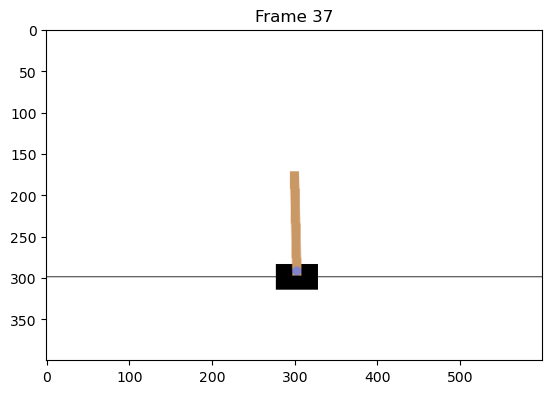

[ 0.0291658  -0.17261553 -0.02794602  0.02489207] [ 0.02571349 -0.36732578 -0.02744817  0.30862838] 0
New state:  [ 0.02571349 -0.36732578 -0.02744817  0.30862838] Reward:  1.0 Terminated:  False Truncated:  False


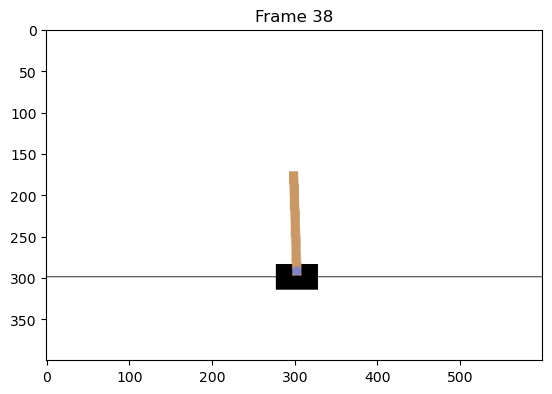

[ 0.02571349 -0.36732578 -0.02744817  0.30862838] [ 0.01836697 -0.17182373 -0.02127561  0.00741697] 1
New state:  [ 0.01836697 -0.17182373 -0.02127561  0.00741697] Reward:  1.0 Terminated:  False Truncated:  False


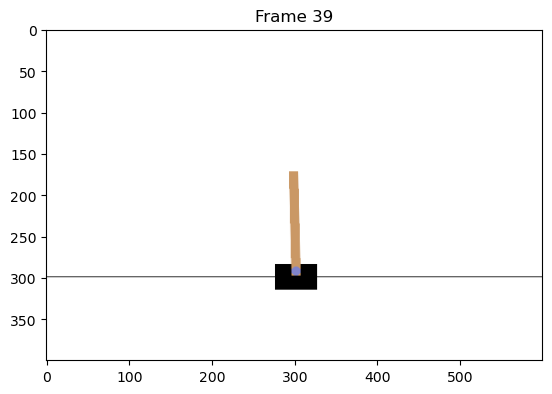

[ 0.01836697 -0.17182373 -0.02127561  0.00741697] [ 0.0149305  -0.3666342  -0.02112727  0.29331198] 0
New state:  [ 0.0149305  -0.3666342  -0.02112727  0.29331198] Reward:  1.0 Terminated:  False Truncated:  False


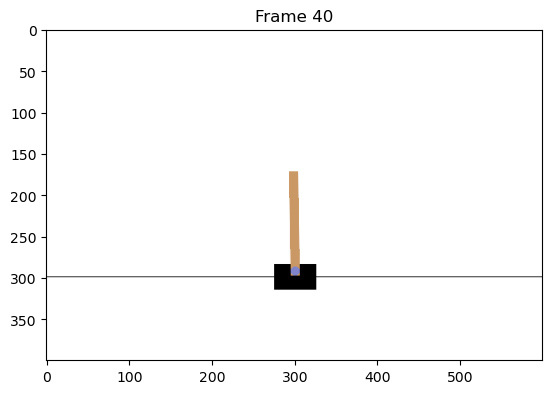

[ 0.0149305  -0.3666342  -0.02112727  0.29331198] [ 0.00759781 -0.17121749 -0.01526103 -0.00595861] 1
New state:  [ 0.00759781 -0.17121749 -0.01526103 -0.00595861] Reward:  1.0 Terminated:  False Truncated:  False


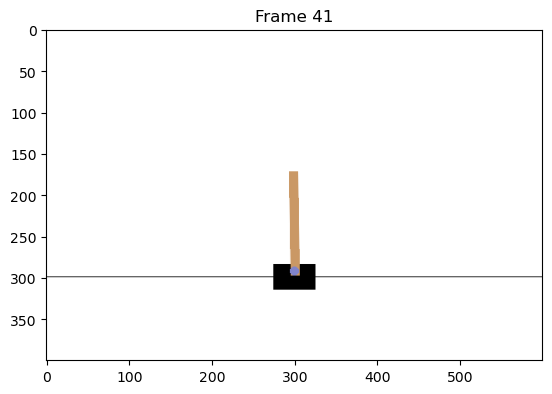

[ 0.00759781 -0.17121749 -0.01526103 -0.00595861] [ 0.00417346 -0.3661173  -0.0153802   0.28187048] 0
New state:  [ 0.00417346 -0.3661173  -0.0153802   0.28187048] Reward:  1.0 Terminated:  False Truncated:  False


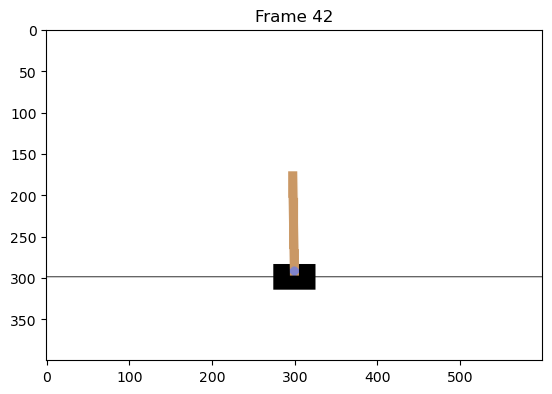

[ 0.00417346 -0.3661173  -0.0153802   0.28187048] [-0.00314888 -0.17077936 -0.00974279 -0.01562334] 1
New state:  [-0.00314888 -0.17077936 -0.00974279 -0.01562334] Reward:  1.0 Terminated:  False Truncated:  False


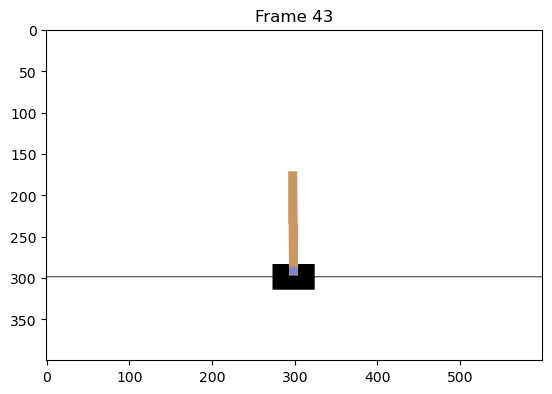

[-0.00314888 -0.17077936 -0.00974279 -0.01562334] [-0.00656447 -0.36576024 -0.01005526  0.27396977] 0
New state:  [-0.00656447 -0.36576024 -0.01005526  0.27396977] Reward:  1.0 Terminated:  False Truncated:  False


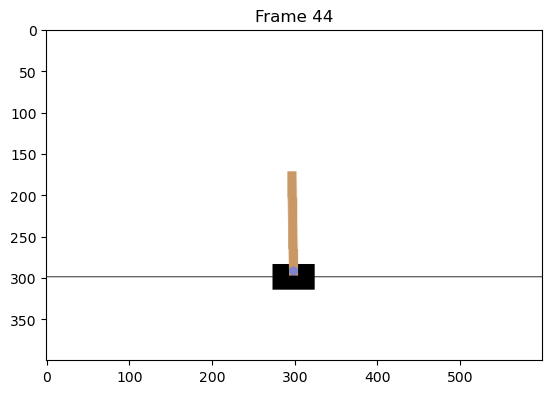

[-0.00656447 -0.36576024 -0.01005526  0.27396977] [-0.01387968 -0.17049628 -0.00457586 -0.02186758] 1
New state:  [-0.01387968 -0.17049628 -0.00457586 -0.02186758] Reward:  1.0 Terminated:  False Truncated:  False


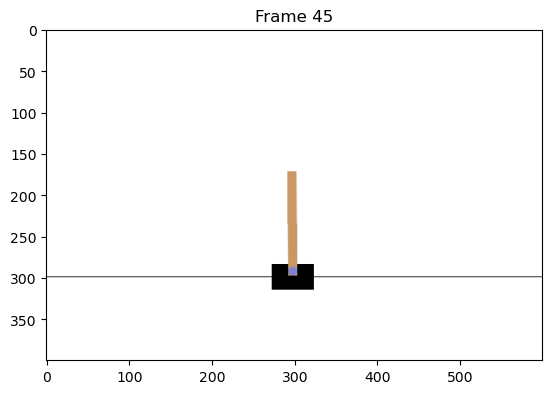

[-0.01387968 -0.17049628 -0.00457586 -0.02186758] [-0.0172896  -0.3655523  -0.00501321  0.2693681 ] 0
New state:  [-0.0172896  -0.3655523  -0.00501321  0.2693681 ] Reward:  1.0 Terminated:  False Truncated:  False


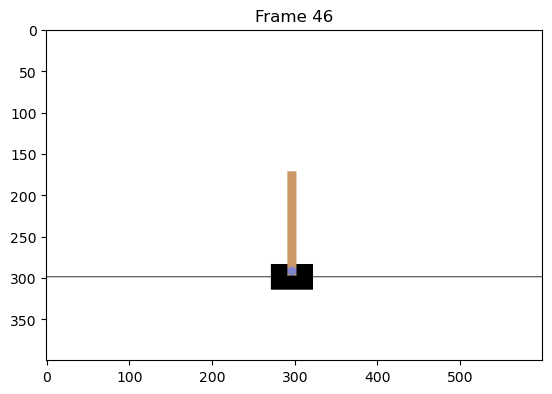

[-0.0172896  -0.3655523  -0.00501321  0.2693681 ] [-0.02460065 -0.17035918  0.00037415 -0.02489179] 1
New state:  [-0.02460065 -0.17035918  0.00037415 -0.02489179] Reward:  1.0 Terminated:  False Truncated:  False


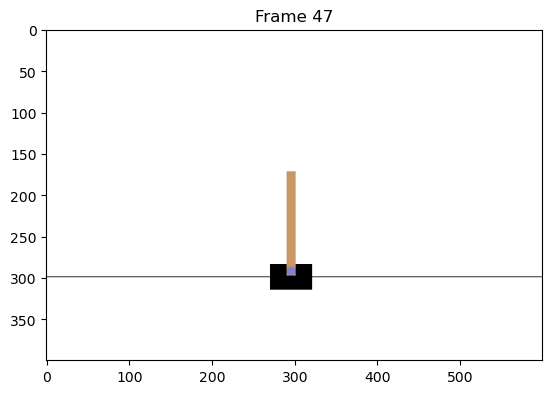

[-0.02460065 -0.17035918  0.00037415 -0.02489179] [-2.8007831e-02 -3.6548650e-01 -1.2368664e-04  2.6790917e-01] 0
New state:  [-2.8007831e-02 -3.6548650e-01 -1.2368664e-04  2.6790917e-01] Reward:  1.0 Terminated:  False Truncated:  False


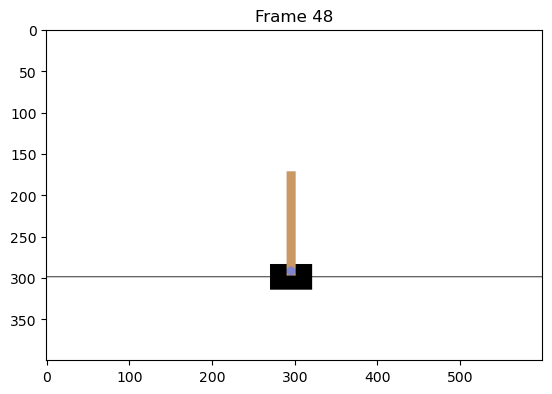

[-2.8007831e-02 -3.6548650e-01 -1.2368664e-04  2.6790917e-01] [-0.03531756 -0.17036277  0.0052345  -0.02481277] 1
New state:  [-0.03531756 -0.17036277  0.0052345  -0.02481277] Reward:  1.0 Terminated:  False Truncated:  False


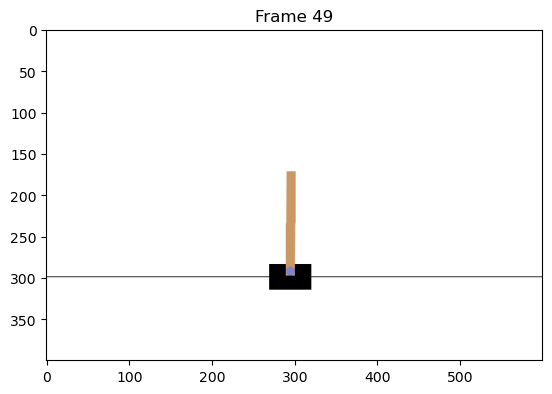

[-0.03531756 -0.17036277  0.0052345  -0.02481277] [-0.03872482 -0.3655594   0.00473824  0.2695171 ] 0
New state:  [-0.03872482 -0.3655594   0.00473824  0.2695171 ] Reward:  1.0 Terminated:  False Truncated:  False


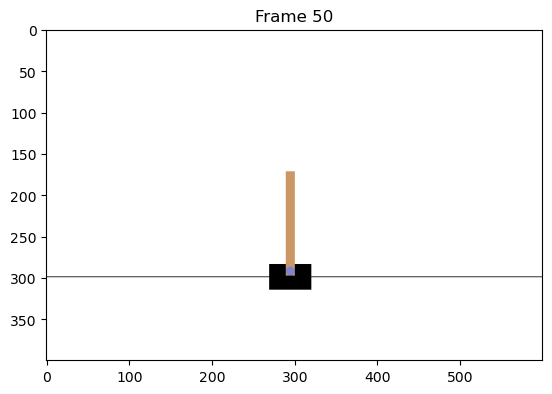

[-0.03872482 -0.3655594   0.00473824  0.2695171 ] [-0.04603601 -0.17050539  0.01012858 -0.02166761] 1
New state:  [-0.04603601 -0.17050539  0.01012858 -0.02166761] Reward:  1.0 Terminated:  False Truncated:  False


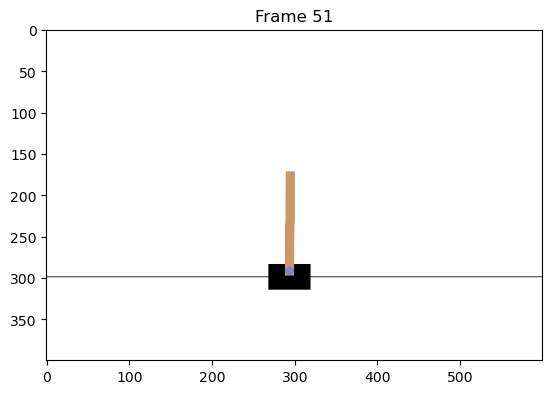

[-0.04603601 -0.17050539  0.01012858 -0.02166761] [-0.04944611 -0.3657711   0.00969523  0.2741937 ] 0
New state:  [-0.04944611 -0.3657711   0.00969523  0.2741937 ] Reward:  1.0 Terminated:  False Truncated:  False


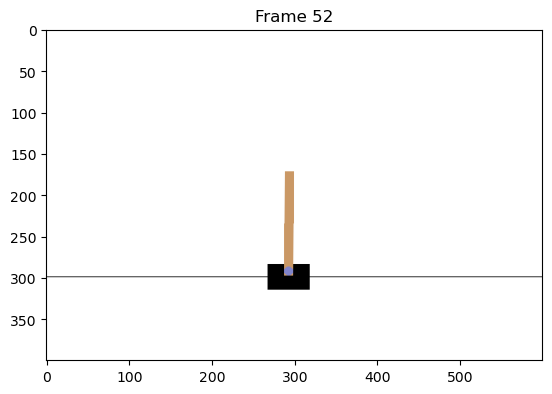

[-0.04944611 -0.3657711   0.00969523  0.2741937 ] [-0.05676153 -0.17078884  0.01517911 -0.01541562] 1
New state:  [-0.05676153 -0.17078884  0.01517911 -0.01541562] Reward:  1.0 Terminated:  False Truncated:  False


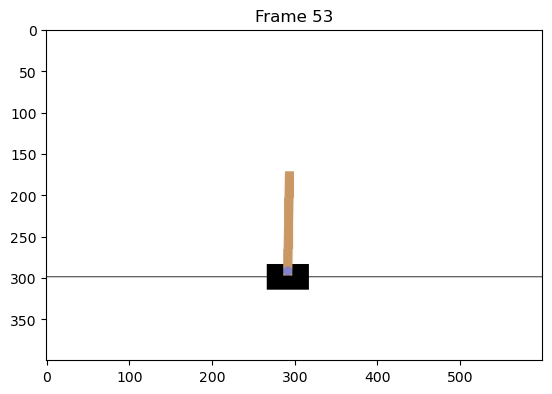

[-0.05676153 -0.17078884  0.01517911 -0.01541562] [-0.06017731 -0.36612514  0.01487079  0.2820176 ] 0
New state:  [-0.06017731 -0.36612514  0.01487079  0.2820176 ] Reward:  1.0 Terminated:  False Truncated:  False


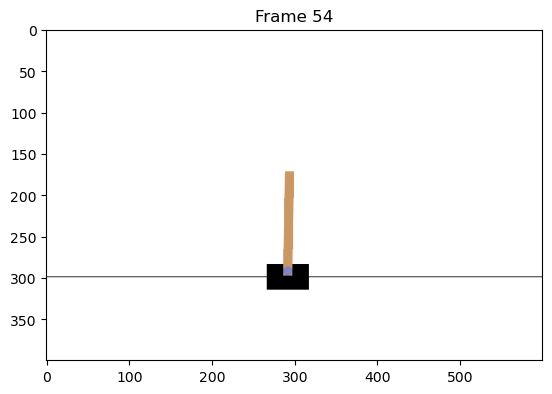

[-0.06017731 -0.36612514  0.01487079  0.2820176 ] [-0.06749982 -0.17121843  0.02051114 -0.00593831] 1
New state:  [-0.06749982 -0.17121843  0.02051114 -0.00593831] Reward:  1.0 Terminated:  False Truncated:  False


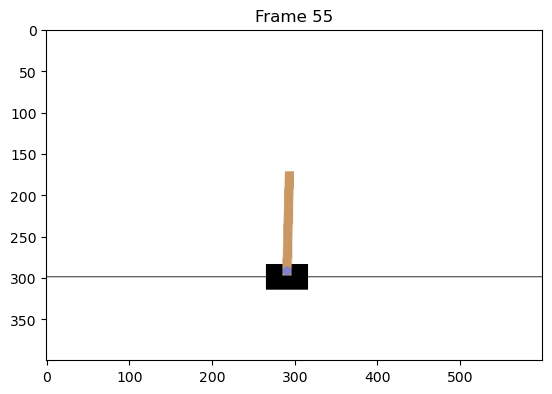

[-0.06749982 -0.17121843  0.02051114 -0.00593831] [-0.07092419  0.02360345  0.02039238 -0.2920798 ] 1
New state:  [-0.07092419  0.02360345  0.02039238 -0.2920798 ] Reward:  1.0 Terminated:  False Truncated:  False


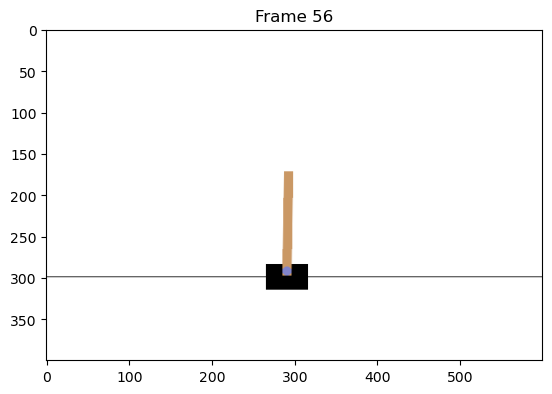

[-0.07092419  0.02360345  0.02039238 -0.2920798 ] [-0.07045212 -0.17180324  0.01455078  0.00696422] 0
New state:  [-0.07045212 -0.17180324  0.01455078  0.00696422] Reward:  1.0 Terminated:  False Truncated:  False


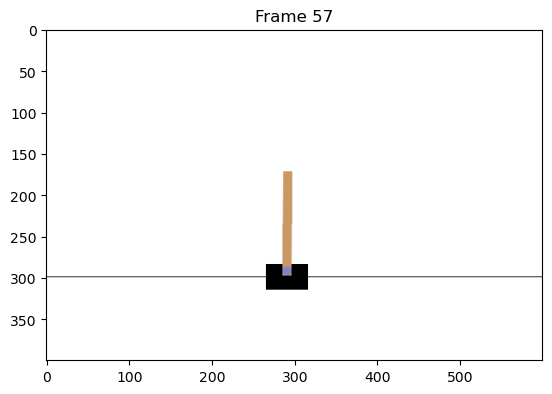

[-0.07045212 -0.17180324  0.01455078  0.00696422] [-0.07388818  0.02310705  0.01469007 -0.28109246] 1
New state:  [-0.07388818  0.02310705  0.01469007 -0.28109246] Reward:  1.0 Terminated:  False Truncated:  False


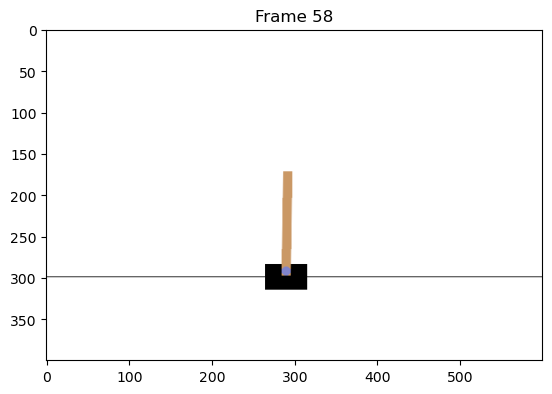

[-0.07388818  0.02310705  0.01469007 -0.28109246] [-0.07342604 -0.17222133  0.00906822  0.01618721] 0
New state:  [-0.07342604 -0.17222133  0.00906822  0.01618721] Reward:  1.0 Terminated:  False Truncated:  False


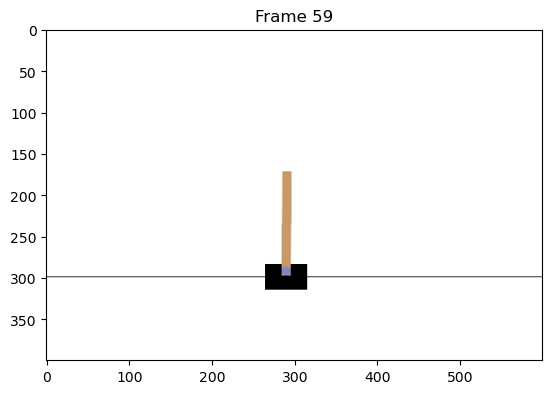

[-0.07342604 -0.17222133  0.00906822  0.01618721] [-0.07687046  0.0227694   0.00939196 -0.27362084] 1
New state:  [-0.07687046  0.0227694   0.00939196 -0.27362084] Reward:  1.0 Terminated:  False Truncated:  False


[-0.07687046  0.0227694   0.00939196 -0.27362084] [-0.07641508 -0.17248529  0.00391954  0.02200947] 0
New state:  [-0.07641508 -0.17248529  0.00391954  0.02200947] Reward:  1.0 Terminated:  False Truncated:  False


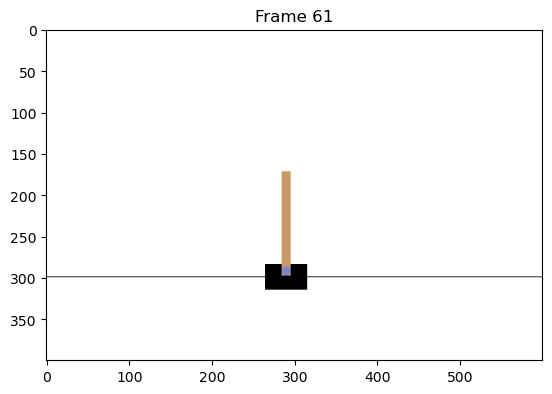

[-0.07641508 -0.17248529  0.00391954  0.02200947] [-0.07986479  0.02258023  0.00435973 -0.2694342 ] 1
New state:  [-0.07986479  0.02258023  0.00435973 -0.2694342 ] Reward:  1.0 Terminated:  False Truncated:  False


[-0.07986479  0.02258023  0.00435973 -0.2694342 ] [-0.07941318 -0.17260367 -0.00102895  0.02462059] 0
New state:  [-0.07941318 -0.17260367 -0.00102895  0.02462059] Reward:  1.0 Terminated:  False Truncated:  False


[-0.07941318 -0.17260367 -0.00102895  0.02462059] [-0.08286525  0.02253303 -0.00053654 -0.2683868 ] 1
New state:  [-0.08286525  0.02253303 -0.00053654 -0.2683868 ] Reward:  1.0 Terminated:  False Truncated:  False


[-0.08286525  0.02253303 -0.00053654 -0.2683868 ] [-0.08241459 -0.17258126 -0.00590427  0.02412685] 0
New state:  [-0.08241459 -0.17258126 -0.00590427  0.02412685] Reward:  1.0 Terminated:  False Truncated:  False


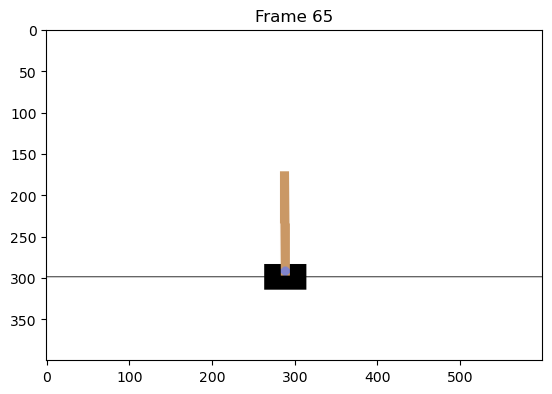

[-0.08241459 -0.17258126 -0.00590427  0.02412685] [-0.08586621  0.02262486 -0.00542174 -0.27041307] 1
New state:  [-0.08586621  0.02262486 -0.00542174 -0.27041307] Reward:  1.0 Terminated:  False Truncated:  False


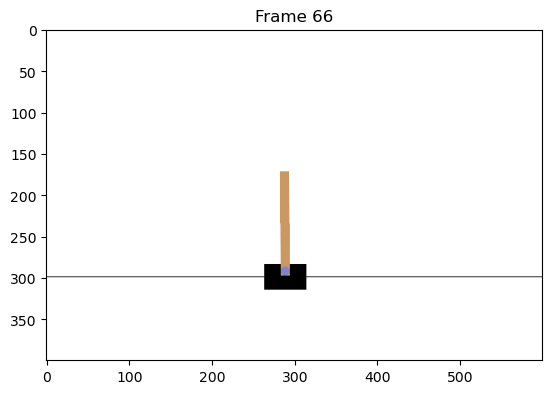

[-0.08586621  0.02262486 -0.00542174 -0.27041307] [-0.08541372 -0.17241931 -0.01083     0.02055488] 0
New state:  [-0.08541372 -0.17241931 -0.01083     0.02055488] Reward:  1.0 Terminated:  False Truncated:  False


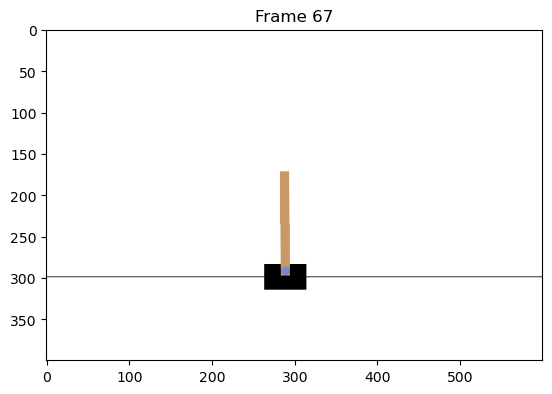

[-0.08541372 -0.17241931 -0.01083     0.02055488] [-0.08886211  0.02285627 -0.0104189  -0.27552527] 1
New state:  [-0.08886211  0.02285627 -0.0104189  -0.27552527] Reward:  1.0 Terminated:  False Truncated:  False


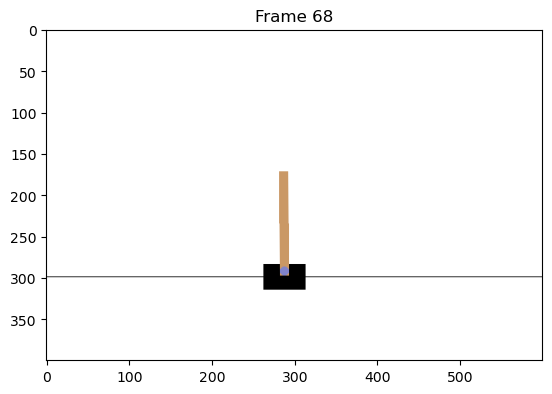

[-0.08886211  0.02285627 -0.0104189  -0.27552527] [-0.08840498 -0.17211549 -0.01592941  0.01385341] 0
New state:  [-0.08840498 -0.17211549 -0.01592941  0.01385341] Reward:  1.0 Terminated:  False Truncated:  False


[-0.08840498 -0.17211549 -0.01592941  0.01385341] [-0.09184729 -0.3670054  -0.01565234  0.30146816] 0
New state:  [-0.09184729 -0.3670054  -0.01565234  0.30146816] Reward:  1.0 Terminated:  False Truncated:  False


[-0.09184729 -0.3670054  -0.01565234  0.30146816] [-0.0991874  -0.17166391 -0.00962298  0.0038902 ] 1
New state:  [-0.0991874  -0.17166391 -0.00962298  0.0038902 ] Reward:  1.0 Terminated:  False Truncated:  False


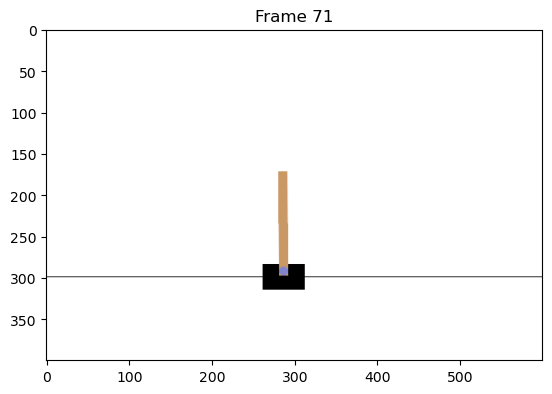

[-0.0991874  -0.17166391 -0.00962298  0.0038902 ] [-0.10262068 -0.36664653 -0.00954517  0.2935215 ] 0
New state:  [-0.10262068 -0.36664653 -0.00954517  0.2935215 ] Reward:  1.0 Terminated:  False Truncated:  False


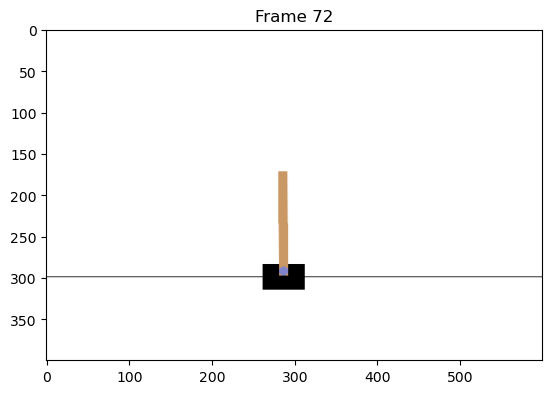

[-0.10262068 -0.36664653 -0.00954517  0.2935215 ] [-0.1099536  -0.1713898  -0.00367474 -0.0021565 ] 1
New state:  [-0.1099536  -0.1713898  -0.00367474 -0.0021565 ] Reward:  1.0 Terminated:  False Truncated:  False


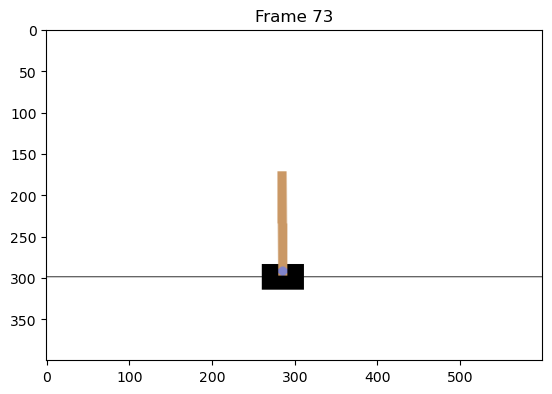

[-0.1099536  -0.1713898  -0.00367474 -0.0021565 ] [-0.1133814   0.02378465 -0.00371787 -0.29599658] 1
New state:  [-0.1133814   0.02378465 -0.00371787 -0.29599658] Reward:  1.0 Terminated:  False Truncated:  False


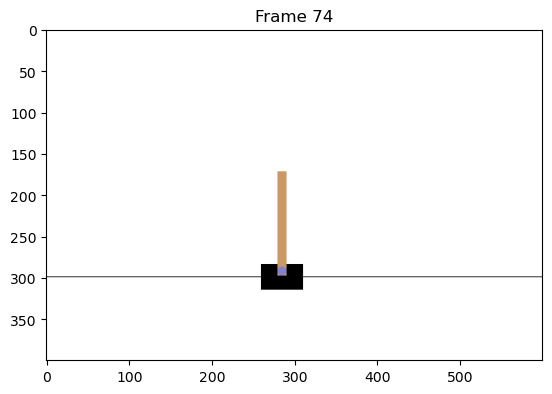

[-0.1133814   0.02378465 -0.00371787 -0.29599658] [-0.11290571 -0.17128411 -0.0096378  -0.00448853] 0
New state:  [-0.11290571 -0.17128411 -0.0096378  -0.00448853] Reward:  1.0 Terminated:  False Truncated:  False


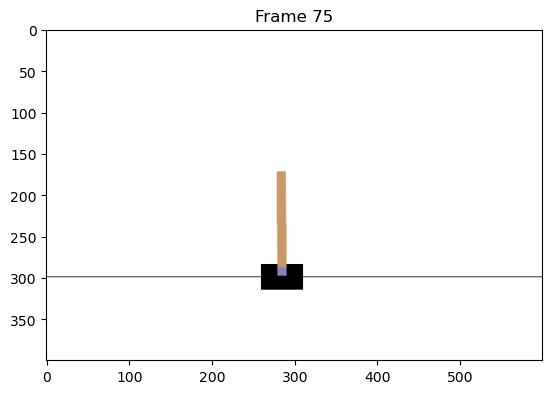

[-0.11290571 -0.17128411 -0.0096378  -0.00448853] [-0.11633139 -0.36626652 -0.00972757  0.28513804] 0
New state:  [-0.11633139 -0.36626652 -0.00972757  0.28513804] Reward:  1.0 Terminated:  False Truncated:  False


[-0.11633139 -0.36626652 -0.00972757  0.28513804] [-0.12365672 -0.17100719 -0.00402481 -0.01059696] 1
New state:  [-0.12365672 -0.17100719 -0.00402481 -0.01059696] Reward:  1.0 Terminated:  False Truncated:  False


[-0.12365672 -0.17100719 -0.00402481 -0.01059696] [-0.12707686 -0.3660712  -0.00423675  0.28081337] 0
New state:  [-0.12707686 -0.3660712  -0.00423675  0.28081337] Reward:  1.0 Terminated:  False Truncated:  False


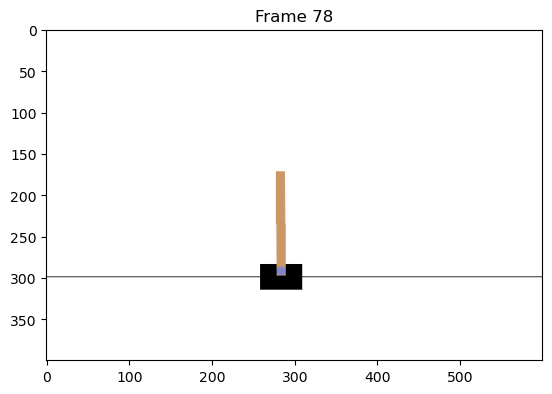

[-0.12707686 -0.3660712  -0.00423675  0.28081337] [-0.13439828 -0.17088906  0.00137951 -0.01320279] 1
New state:  [-0.13439828 -0.17088906  0.00137951 -0.01320279] Reward:  1.0 Terminated:  False Truncated:  False


[-0.13439828 -0.17088906  0.00137951 -0.01320279] [-0.13781607  0.02421308  0.00111546 -0.30545014] 1
New state:  [-0.13781607  0.02421308  0.00111546 -0.30545014] Reward:  1.0 Terminated:  False Truncated:  False


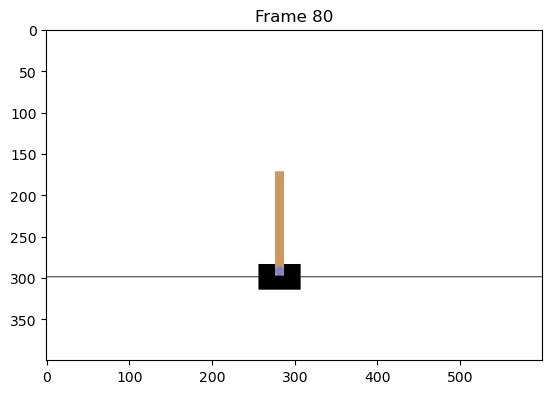

[-0.13781607  0.02421308  0.00111546 -0.30545014] [-0.13733181 -0.17092475 -0.00499354 -0.01241564] 0
New state:  [-0.13733181 -0.17092475 -0.00499354 -0.01241564] Reward:  1.0 Terminated:  False Truncated:  False


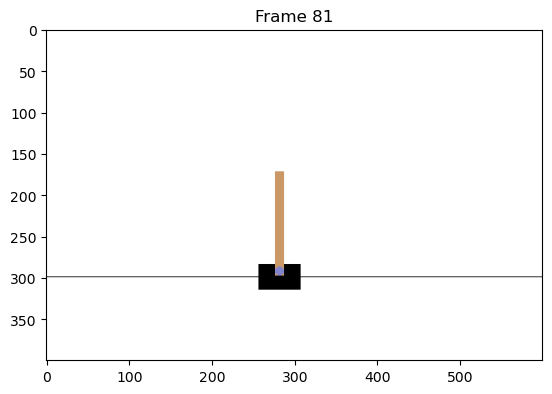

[-0.13733181 -0.17092475 -0.00499354 -0.01241564] [-0.1407503  -0.36597472 -0.00524186  0.2786876 ] 0
New state:  [-0.1407503  -0.36597472 -0.00524186  0.2786876 ] Reward:  1.0 Terminated:  False Truncated:  False


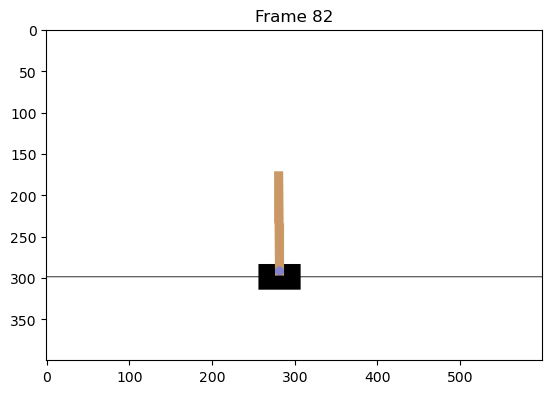

[-0.1407503  -0.36597472 -0.00524186  0.2786876 ] [-0.1480698  -0.1707784   0.0003319  -0.01564399] 1
New state:  [-0.1480698  -0.1707784   0.0003319  -0.01564399] Reward:  1.0 Terminated:  False Truncated:  False


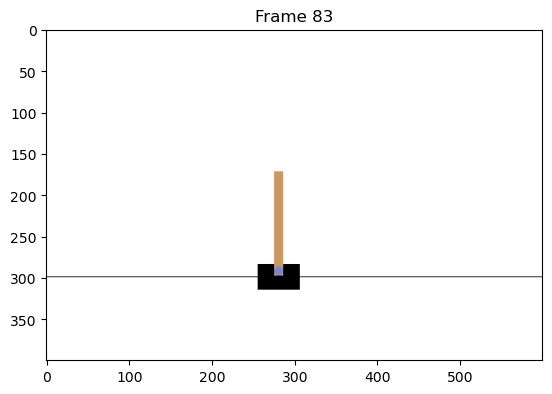

[-0.1480698  -0.1707784   0.0003319  -0.01564399] [-1.5148537e-01  2.4338793e-02  1.9015570e-05 -3.0822217e-01] 1
New state:  [-1.5148537e-01  2.4338793e-02  1.9015570e-05 -3.0822217e-01] Reward:  1.0 Terminated:  False Truncated:  False


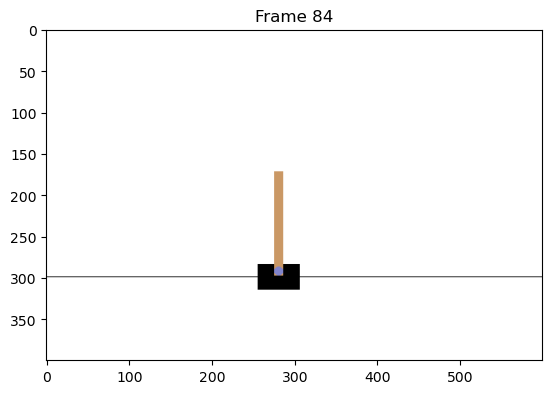

[-1.5148537e-01  2.4338793e-02  1.9015570e-05 -3.0822217e-01] [-0.15099859 -0.17078343 -0.00614543 -0.01553325] 0
New state:  [-0.15099859 -0.17078343 -0.00614543 -0.01553325] Reward:  1.0 Terminated:  False Truncated:  False


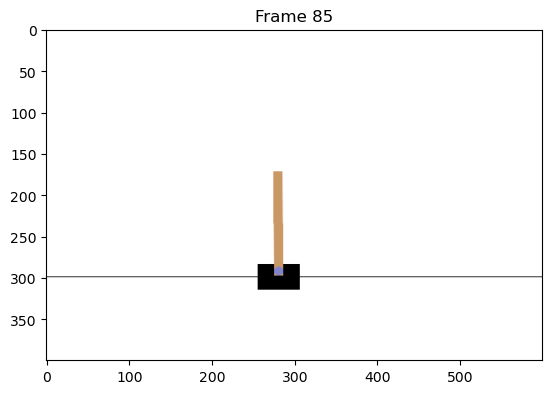

[-0.15099859 -0.17078343 -0.00614543 -0.01553325] [-0.15441425 -0.3658167  -0.00645609  0.2752044 ] 0
New state:  [-0.15441425 -0.3658167  -0.00645609  0.2752044 ] Reward:  1.0 Terminated:  False Truncated:  False


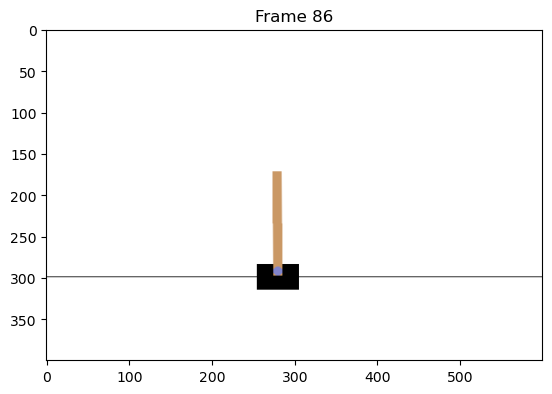

[-0.15441425 -0.3658167  -0.00645609  0.2752044 ] [-0.16173059 -0.17060325 -0.00095201 -0.01950778] 1
New state:  [-0.16173059 -0.17060325 -0.00095201 -0.01950778] Reward:  1.0 Terminated:  False Truncated:  False


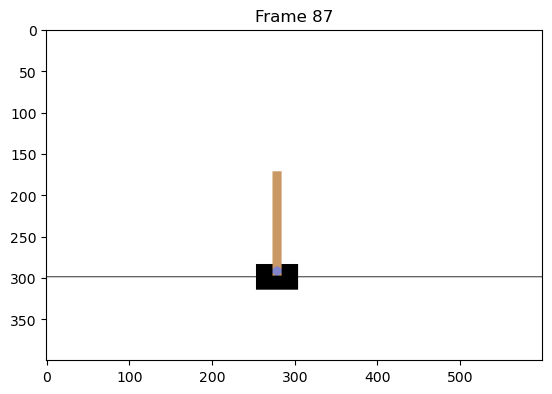

[-0.16173059 -0.17060325 -0.00095201 -0.01950778] [-0.16514266  0.02453235 -0.00134216 -0.3124909 ] 1
New state:  [-0.16514266  0.02453235 -0.00134216 -0.3124909 ] Reward:  1.0 Terminated:  False Truncated:  False


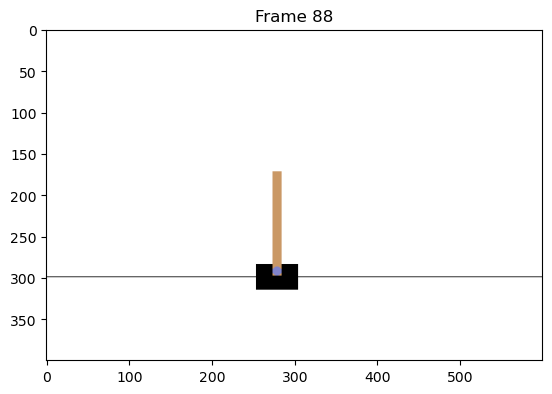

[-0.16514266  0.02453235 -0.00134216 -0.3124909 ] [-0.164652   -0.17057046 -0.00759198 -0.02023157] 0
New state:  [-0.164652   -0.17057046 -0.00759198 -0.02023157] Reward:  1.0 Terminated:  False Truncated:  False


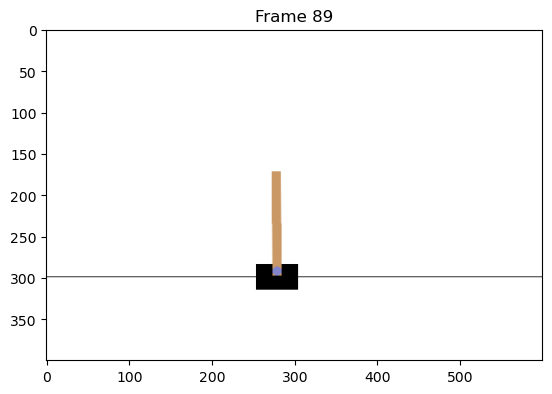

[-0.164652   -0.17057046 -0.00759198 -0.02023157] [-0.16806342 -0.3655827  -0.00799661  0.27004635] 0
New state:  [-0.16806342 -0.3655827  -0.00799661  0.27004635] Reward:  1.0 Terminated:  False Truncated:  False


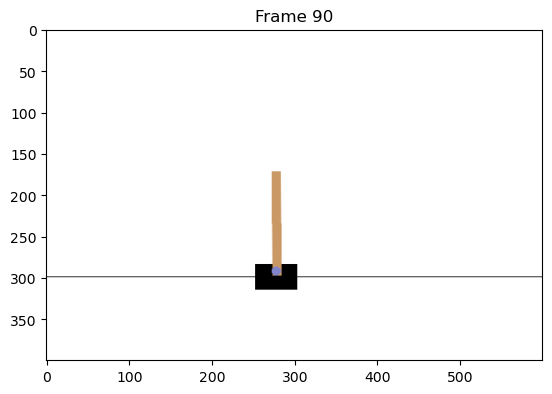

[-0.16806342 -0.3655827  -0.00799661  0.27004635] [-0.17537507 -0.17034757 -0.00259568 -0.02514797] 1
New state:  [-0.17537507 -0.17034757 -0.00259568 -0.02514797] Reward:  1.0 Terminated:  False Truncated:  False


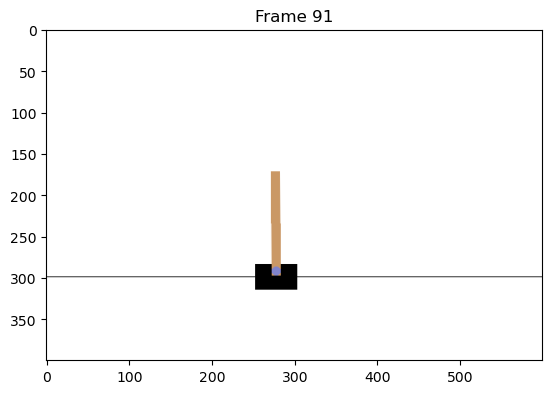

[-0.17537507 -0.17034757 -0.00259568 -0.02514797] [-0.17878203  0.02481151 -0.00309864 -0.31864873] 1
New state:  [-0.17878203  0.02481151 -0.00309864 -0.31864873] Reward:  1.0 Terminated:  False Truncated:  False


[-0.17878203  0.02481151 -0.00309864 -0.31864873] [-0.17828579 -0.17026617 -0.00947162 -0.02694461] 0
New state:  [-0.17828579 -0.17026617 -0.00947162 -0.02694461] Reward:  1.0 Terminated:  False Truncated:  False


[-0.17828579 -0.17026617 -0.00947162 -0.02694461] [-0.18169113 -0.365251   -0.01001051  0.26273492] 0
New state:  [-0.18169113 -0.365251   -0.01001051  0.26273492] Reward:  1.0 Terminated:  False Truncated:  False


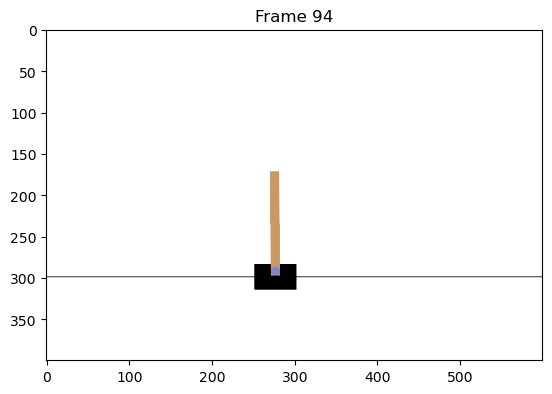

[-0.18169113 -0.365251   -0.01001051  0.26273492] [-0.18899614 -0.16998762 -0.00475581 -0.03308854] 1
New state:  [-0.18899614 -0.16998762 -0.00475581 -0.03308854] Reward:  1.0 Terminated:  False Truncated:  False


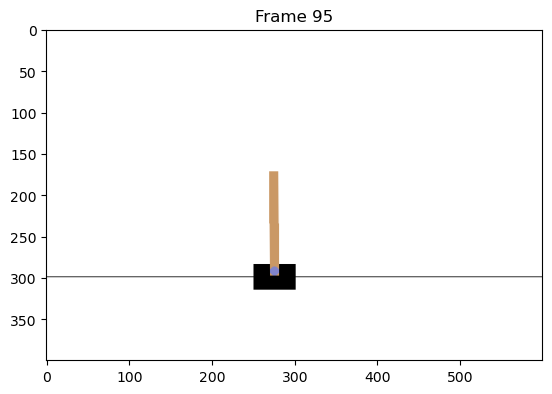

[-0.18899614 -0.16998762 -0.00475581 -0.03308854] [-0.1923959  -0.36504105 -0.00541758  0.25809008] 0
New state:  [-0.1923959  -0.36504105 -0.00541758  0.25809008] Reward:  1.0 Terminated:  False Truncated:  False


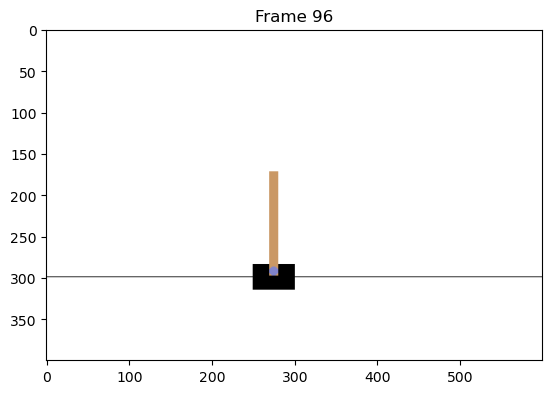

[-0.1923959  -0.36504105 -0.00541758  0.25809008] [-0.19969672 -0.16984217 -0.00025578 -0.03629668] 1
New state:  [-0.19969672 -0.16984217 -0.00025578 -0.03629668] Reward:  1.0 Terminated:  False Truncated:  False


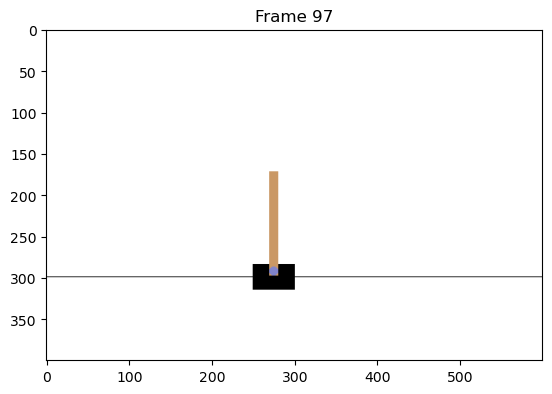

[-0.19969672 -0.16984217 -0.00025578 -0.03629668] [-0.20309356  0.02528344 -0.00098171 -0.32906032] 1
New state:  [-0.20309356  0.02528344 -0.00098171 -0.32906032] Reward:  1.0 Terminated:  False Truncated:  False


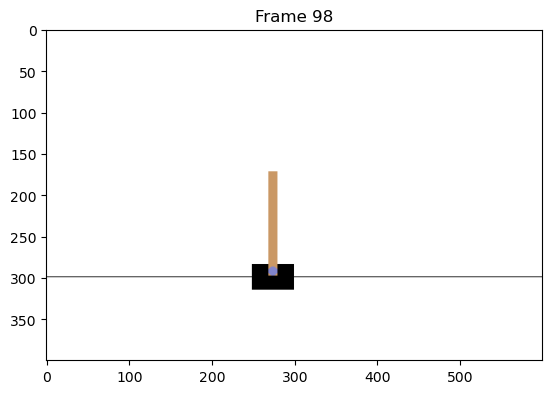

[-0.20309356  0.02528344 -0.00098171 -0.32906032] [-0.20258789 -0.16982451 -0.00756292 -0.03668712] 0
New state:  [-0.20258789 -0.16982451 -0.00756292 -0.03668712] Reward:  1.0 Terminated:  False Truncated:  False


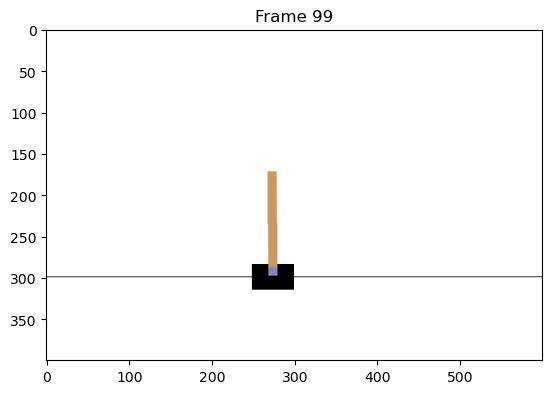

[-0.20258789 -0.16982451 -0.00756292 -0.03668712] [-0.20598438 -0.3648372  -0.00829666  0.25360006] 0
New state:  [-0.20598438 -0.3648372  -0.00829666  0.25360006] Reward:  1.0 Terminated:  False Truncated:  False


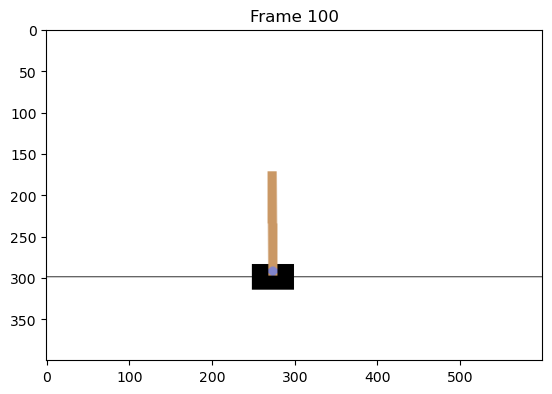

[-0.20598438 -0.3648372  -0.00829666  0.25360006] [-0.21328112 -0.16959777 -0.00322466 -0.04168819] 1
New state:  [-0.21328112 -0.16959777 -0.00322466 -0.04168819] Reward:  1.0 Terminated:  False Truncated:  False


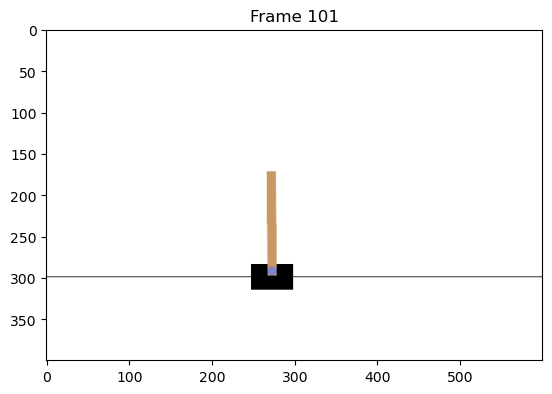

[-0.21328112 -0.16959777 -0.00322466 -0.04168819] [-0.21667308 -0.36467335 -0.00405842  0.24997558] 0
New state:  [-0.21667308 -0.36467335 -0.00405842  0.24997558] Reward:  1.0 Terminated:  False Truncated:  False


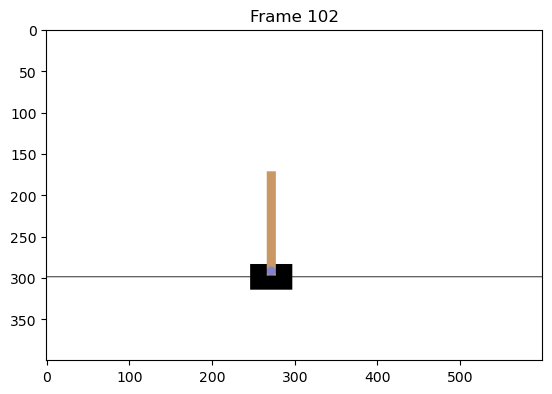

[-0.21667308 -0.36467335 -0.00405842  0.24997558] [-0.22396654 -0.16949366  0.00094109 -0.04398469] 1
New state:  [-0.22396654 -0.16949366  0.00094109 -0.04398469] Reward:  1.0 Terminated:  False Truncated:  False


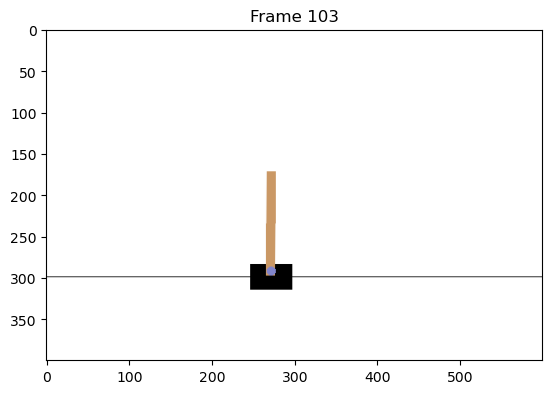

[-0.22396654 -0.16949366  0.00094109 -0.04398469] [-2.2735642e-01  2.5614779e-02  6.1392981e-05 -3.3637056e-01] 1
New state:  [-2.2735642e-01  2.5614779e-02  6.1392981e-05 -3.3637056e-01] Reward:  1.0 Terminated:  False Truncated:  False


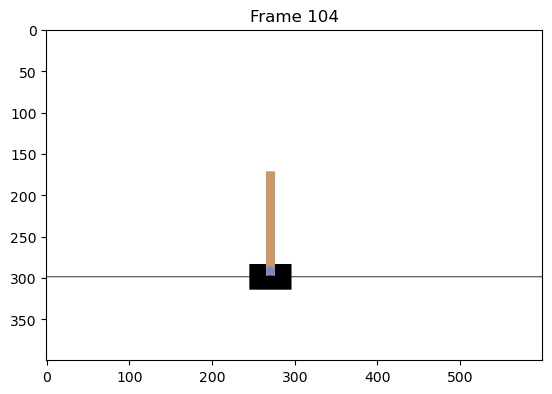

[-2.2735642e-01  2.5614779e-02  6.1392981e-05 -3.3637056e-01] [-0.22684412 -0.16950804 -0.00666602 -0.04366826] 0
New state:  [-0.22684412 -0.16950804 -0.00666602 -0.04366826] Reward:  1.0 Terminated:  False Truncated:  False


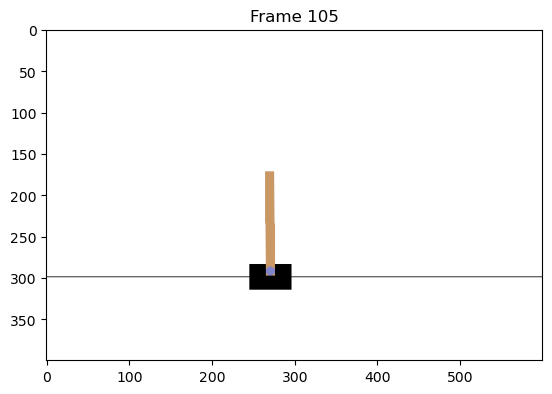

[-0.22684412 -0.16950804 -0.00666602 -0.04366826] [-0.23023428 -0.36453378 -0.00753938  0.24690405] 0
New state:  [-0.23023428 -0.36453378 -0.00753938  0.24690405] Reward:  1.0 Terminated:  False Truncated:  False


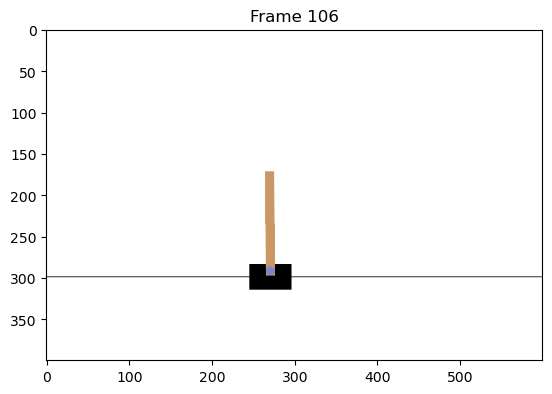

[-0.23023428 -0.36453378 -0.00753938  0.24690405] [-0.23752496 -0.16930497 -0.0026013  -0.04814741] 1
New state:  [-0.23752496 -0.16930497 -0.0026013  -0.04814741] Reward:  1.0 Terminated:  False Truncated:  False


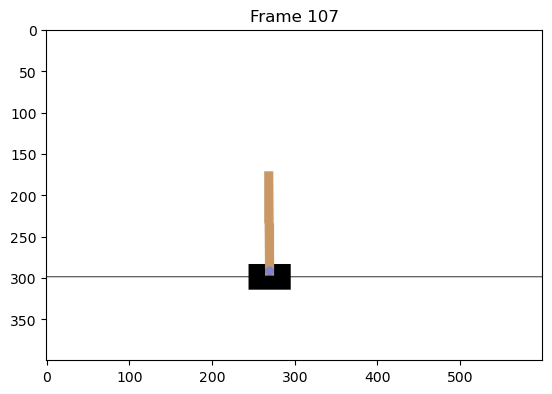

[-0.23752496 -0.16930497 -0.0026013  -0.04814741] [-0.24091105  0.02585419 -0.00356425 -0.34164992] 1
New state:  [-0.24091105  0.02585419 -0.00356425 -0.34164992] Reward:  1.0 Terminated:  False Truncated:  False


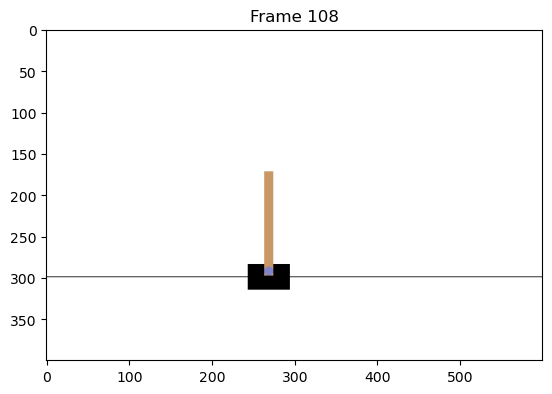

[-0.24091105  0.02585419 -0.00356425 -0.34164992] [-0.24039397 -0.16921687 -0.01039725 -0.05009309] 0
New state:  [-0.24039397 -0.16921687 -0.01039725 -0.05009309] Reward:  1.0 Terminated:  False Truncated:  False


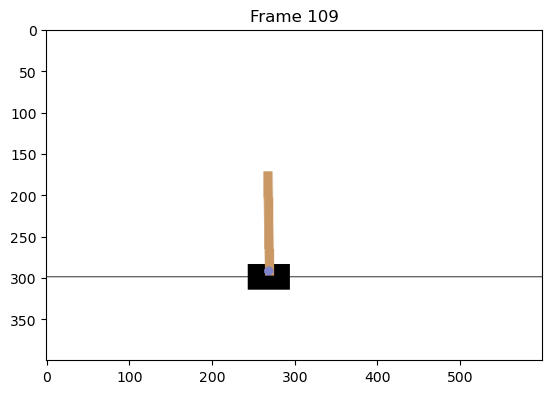

[-0.24039397 -0.16921687 -0.01039725 -0.05009309] [-0.24377832 -0.3641882  -0.01139911  0.23929137] 0
New state:  [-0.24377832 -0.3641882  -0.01139911  0.23929137] Reward:  1.0 Terminated:  False Truncated:  False


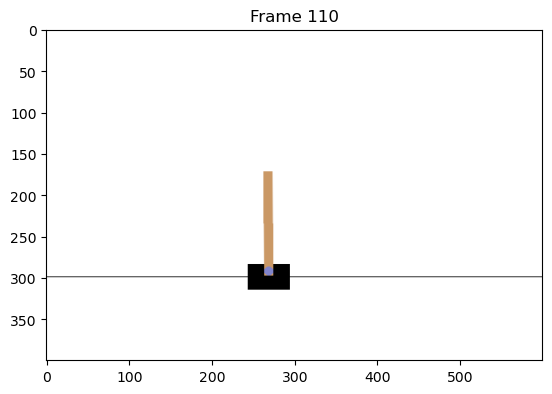

[-0.24377832 -0.3641882  -0.01139911  0.23929137] [-0.25106207 -0.16890527 -0.00661328 -0.05696525] 1
New state:  [-0.25106207 -0.16890527 -0.00661328 -0.05696525] Reward:  1.0 Terminated:  False Truncated:  False


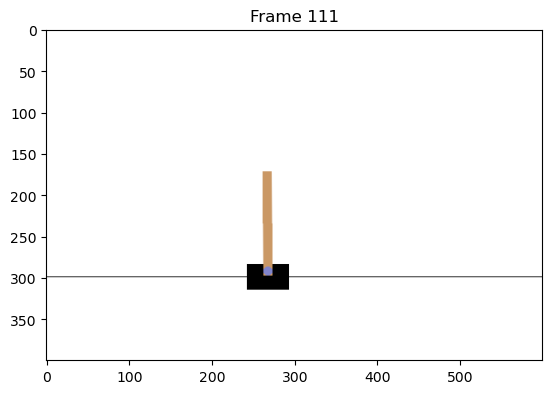

[-0.25106207 -0.16890527 -0.00661328 -0.05696525] [-0.2544402  -0.36393178 -0.00775259  0.23362382] 0
New state:  [-0.2544402  -0.36393178 -0.00775259  0.23362382] Reward:  1.0 Terminated:  False Truncated:  False


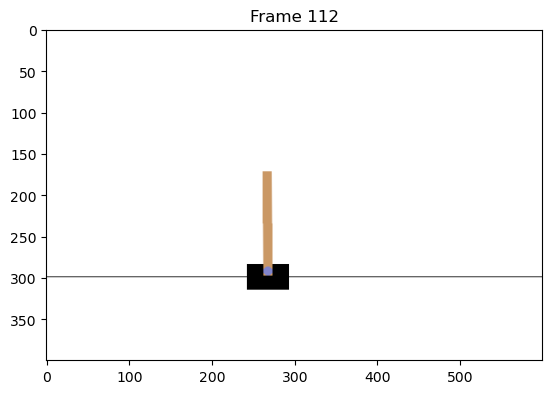

[-0.2544402  -0.36393178 -0.00775259  0.23362382] [-0.2617188  -0.16869994 -0.00308011 -0.06149441] 1
New state:  [-0.2617188  -0.16869994 -0.00308011 -0.06149441] Reward:  1.0 Terminated:  False Truncated:  False


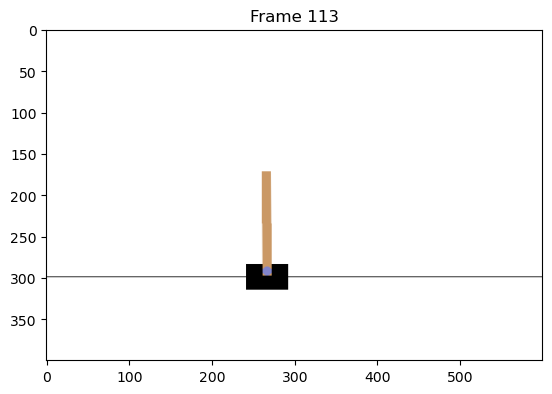

[-0.2617188  -0.16869994 -0.00308011 -0.06149441] [-0.26509282 -0.36377758 -0.00431     0.23021513] 0
New state:  [-0.26509282 -0.36377758 -0.00431     0.23021513] Reward:  1.0 Terminated:  False Truncated:  False


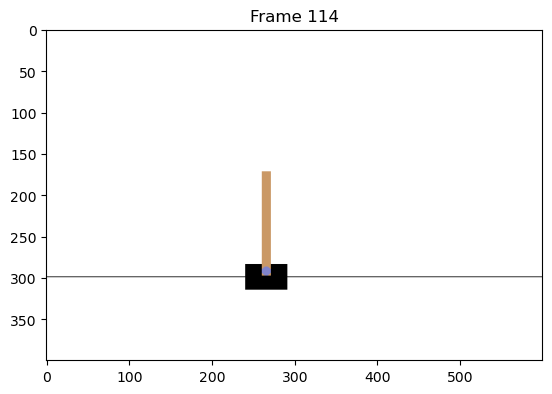

[-0.26509282 -0.36377758 -0.00431     0.23021513] [-0.27236837 -0.1685943   0.0002943  -0.06382419] 1
New state:  [-0.27236837 -0.1685943   0.0002943  -0.06382419] Reward:  1.0 Terminated:  False Truncated:  False


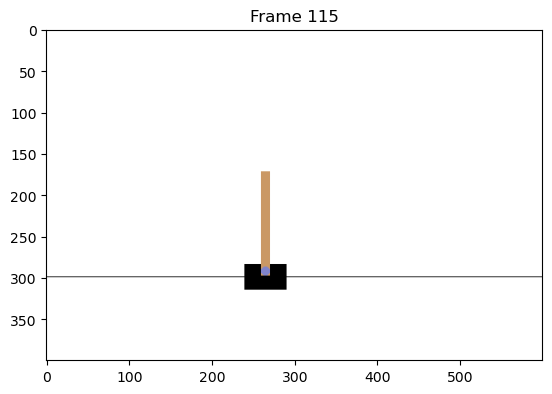

[-0.27236837 -0.1685943   0.0002943  -0.06382419] [-0.27574027 -0.36372048 -0.00098218  0.22895157] 0
New state:  [-0.27574027 -0.36372048 -0.00098218  0.22895157] Reward:  1.0 Terminated:  False Truncated:  False


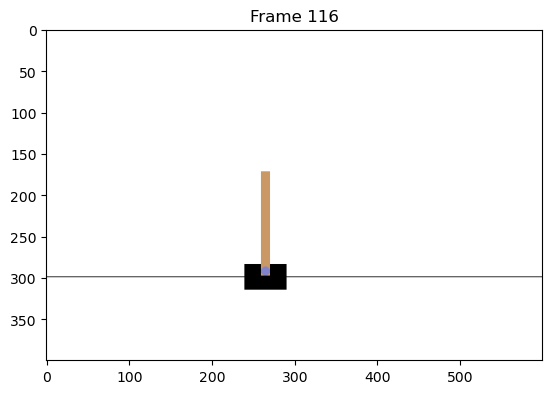

[-0.27574027 -0.36372048 -0.00098218  0.22895157] [-0.28301466 -0.16858451  0.00359685 -0.06404101] 1
New state:  [-0.28301466 -0.16858451  0.00359685 -0.06404101] Reward:  1.0 Terminated:  False Truncated:  False


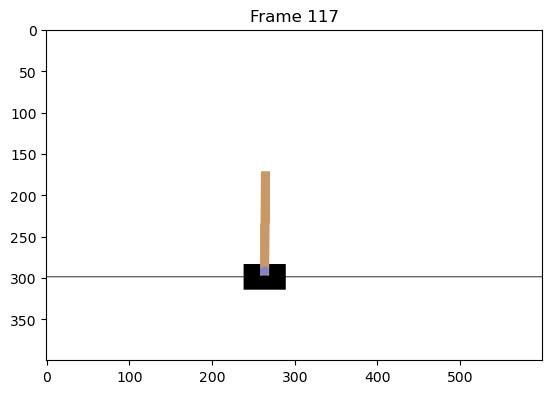

[-0.28301466 -0.16858451  0.00359685 -0.06404101] [-0.28638634  0.02648569  0.00231603 -0.35558695] 1
New state:  [-0.28638634  0.02648569  0.00231603 -0.35558695] Reward:  1.0 Terminated:  False Truncated:  False


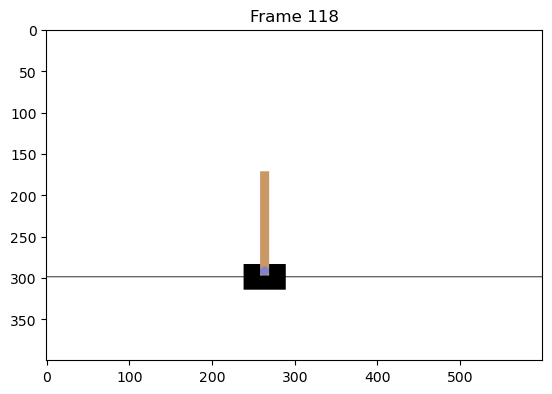

[-0.28638634  0.02648569  0.00231603 -0.35558695] [-0.28585663 -0.1686691  -0.00479571 -0.06217461] 0
New state:  [-0.28585663 -0.1686691  -0.00479571 -0.06217461] Reward:  1.0 Terminated:  False Truncated:  False


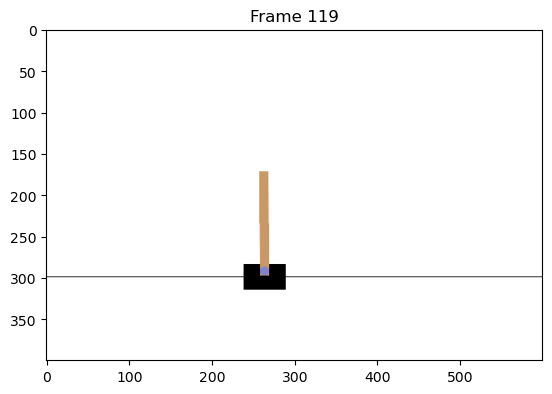

[-0.28585663 -0.1686691  -0.00479571 -0.06217461] [-0.28923002  0.02652127 -0.0060392  -0.35636675] 1
New state:  [-0.28923002  0.02652127 -0.0060392  -0.35636675] Reward:  1.0 Terminated:  False Truncated:  False


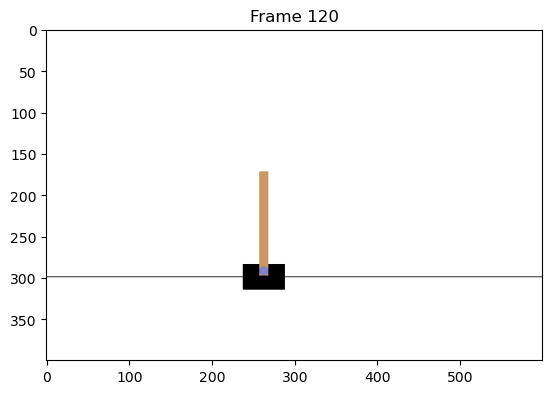

[-0.28923002  0.02652127 -0.0060392  -0.35636675] [-0.2886996  -0.1685143  -0.01316654 -0.06559424] 0
New state:  [-0.2886996  -0.1685143  -0.01316654 -0.06559424] Reward:  1.0 Terminated:  False Truncated:  False


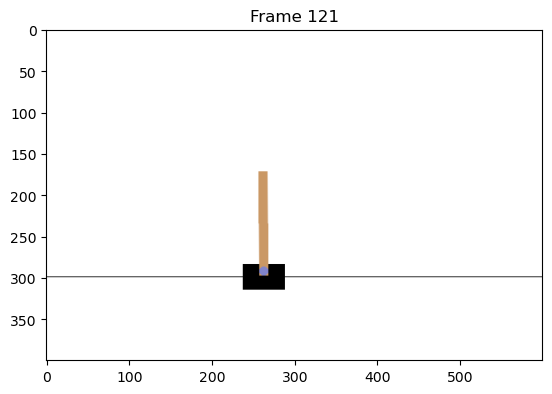

[-0.2886996  -0.1685143  -0.01316654 -0.06559424] [-0.29206988 -0.363445   -0.01447842  0.22290567] 0
New state:  [-0.29206988 -0.363445   -0.01447842  0.22290567] Reward:  1.0 Terminated:  False Truncated:  False


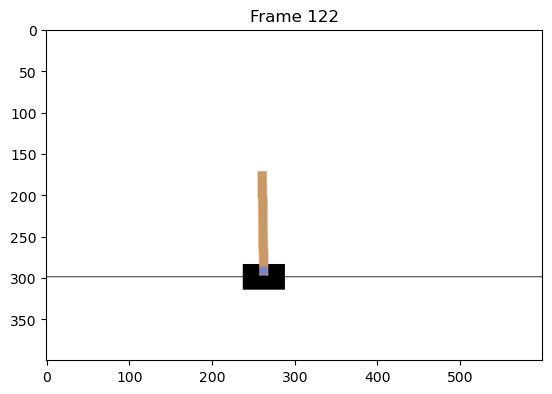

[-0.29206988 -0.363445   -0.01447842  0.22290567] [-0.2993388  -0.16811916 -0.01002031 -0.07430894] 1
New state:  [-0.2993388  -0.16811916 -0.01002031 -0.07430894] Reward:  1.0 Terminated:  False Truncated:  False


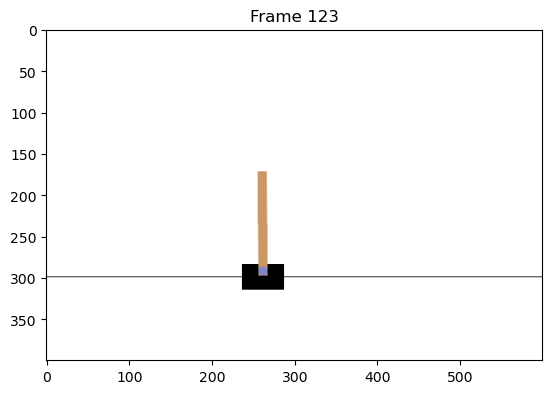

[-0.2993388  -0.16811916 -0.01002031 -0.07430894] [-0.30270118 -0.36309603 -0.01150649  0.21519578] 0
New state:  [-0.30270118 -0.36309603 -0.01150649  0.21519578] Reward:  1.0 Terminated:  False Truncated:  False


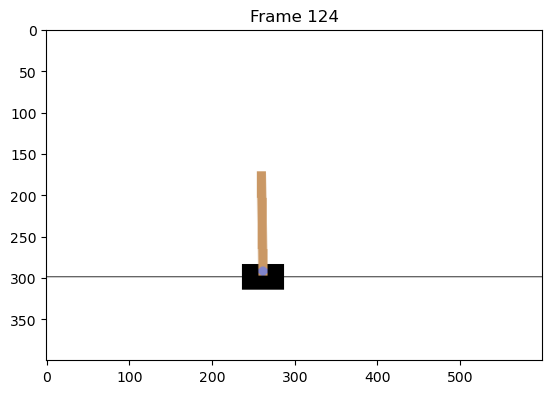

[-0.30270118 -0.36309603 -0.01150649  0.21519578] [-0.30996308 -0.1678115  -0.00720257 -0.08109449] 1
New state:  [-0.30996308 -0.1678115  -0.00720257 -0.08109449] Reward:  1.0 Terminated:  False Truncated:  False


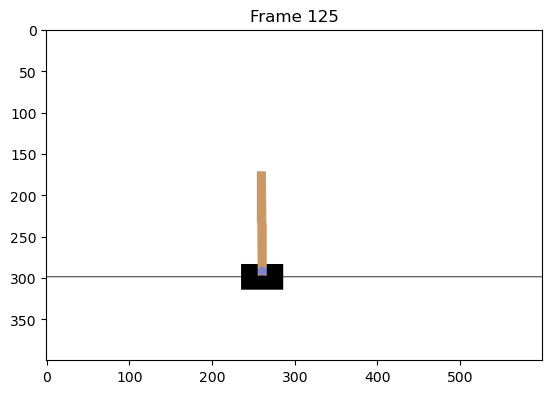

[-0.30996308 -0.1678115  -0.00720257 -0.08109449] [-0.31331933 -0.36282945 -0.00882446  0.20930734] 0
New state:  [-0.31331933 -0.36282945 -0.00882446  0.20930734] Reward:  1.0 Terminated:  False Truncated:  False


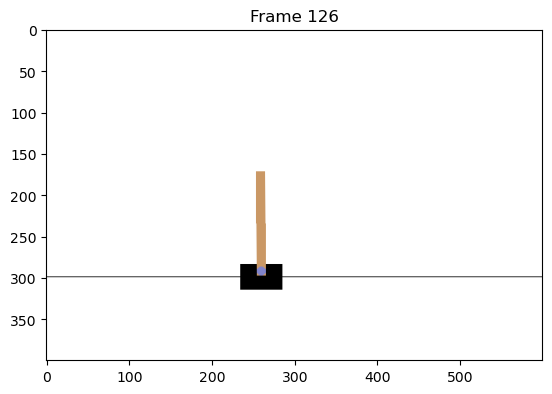

[-0.31331933 -0.36282945 -0.00882446  0.20930734] [-0.3205759  -0.16758245 -0.00463831 -0.08614613] 1
New state:  [-0.3205759  -0.16758245 -0.00463831 -0.08614613] Reward:  1.0 Terminated:  False Truncated:  False


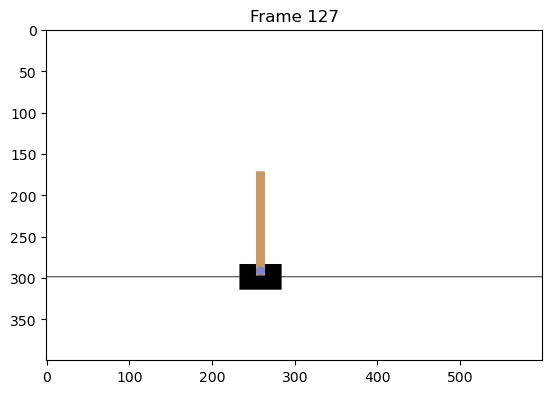

[-0.3205759  -0.16758245 -0.00463831 -0.08614613] [-0.32392755 -0.3626376  -0.00636124  0.2050698 ] 0
New state:  [-0.32392755 -0.3626376  -0.00636124  0.2050698 ] Reward:  1.0 Terminated:  False Truncated:  False


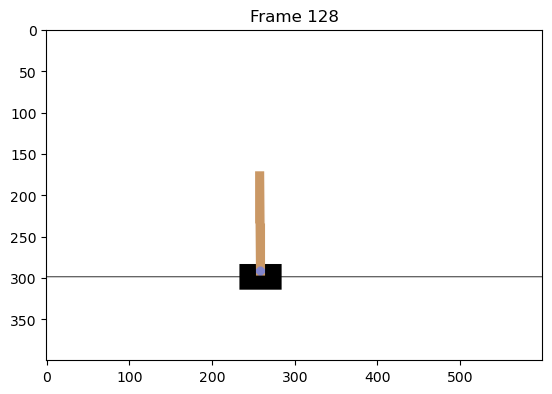

[-0.32392755 -0.3626376  -0.00636124  0.2050698 ] [-0.3311803  -0.16742527 -0.00225984 -0.08961298] 1
New state:  [-0.3311803  -0.16742527 -0.00225984 -0.08961298] Reward:  1.0 Terminated:  False Truncated:  False


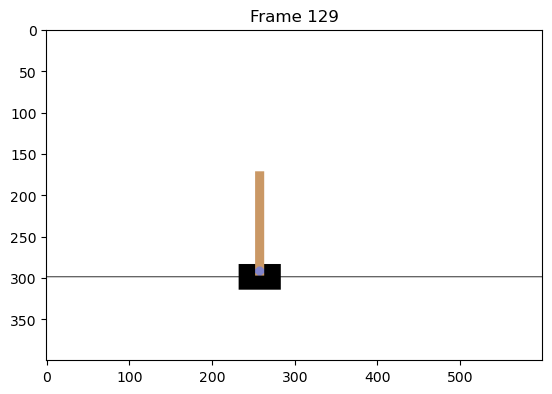

[-0.3311803  -0.16742527 -0.00225984 -0.08961298] [-0.3345288  -0.36251476 -0.0040521   0.20235611] 0
New state:  [-0.3345288  -0.36251476 -0.0040521   0.20235611] Reward:  1.0 Terminated:  False Truncated:  False


[-0.3345288  -0.36251476 -0.0040521   0.20235611] [-3.4177911e-01 -1.6733509e-01 -4.9780992e-06 -9.1602303e-02] 1
New state:  [-3.4177911e-01 -1.6733509e-01 -4.9780992e-06 -9.1602303e-02] Reward:  1.0 Terminated:  False Truncated:  False


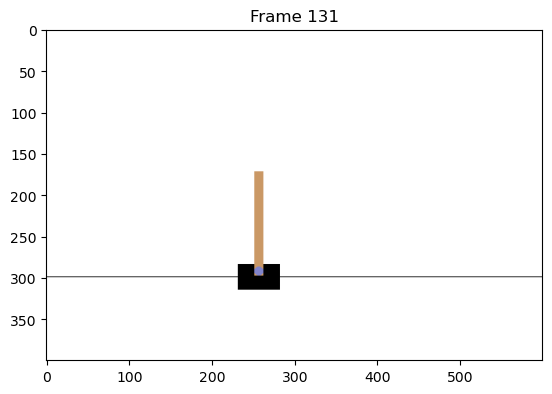

[-3.4177911e-01 -1.6733509e-01 -4.9780992e-06 -9.1602303e-02] [-0.3451258  -0.36245698 -0.00183702  0.20107906] 0
New state:  [-0.3451258  -0.36245698 -0.00183702  0.20107906] Reward:  1.0 Terminated:  False Truncated:  False


[-0.3451258  -0.36245698 -0.00183702  0.20107906] [-0.35237494 -0.16730879  0.00218456 -0.0921828 ] 1
New state:  [-0.35237494 -0.16730879  0.00218456 -0.0921828 ] Reward:  1.0 Terminated:  False Truncated:  False


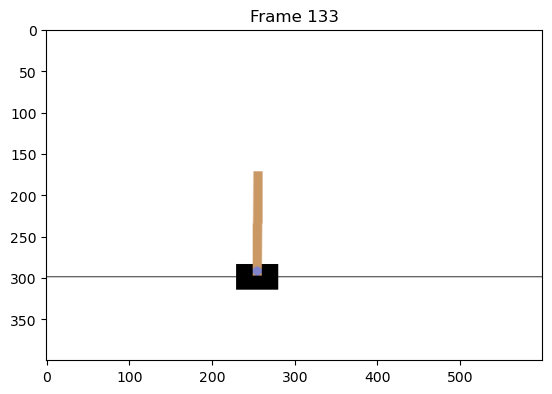

[-0.35237494 -0.16730879  0.00218456 -0.0921828 ] [-3.5572112e-01  2.7781781e-02  3.4090108e-04 -3.8417569e-01] 1
New state:  [-3.5572112e-01  2.7781781e-02  3.4090108e-04 -3.8417569e-01] Reward:  1.0 Terminated:  False Truncated:  False


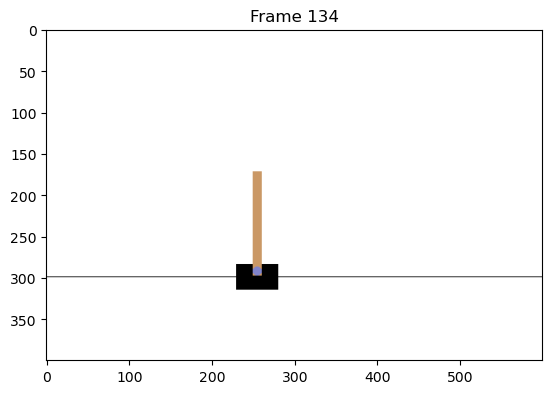

[-3.5572112e-01  2.7781781e-02  3.4090108e-04 -3.8417569e-01] [-0.35516548 -0.167345   -0.00734261 -0.0913853 ] 0
New state:  [-0.35516548 -0.167345   -0.00734261 -0.0913853 ] Reward:  1.0 Terminated:  False Truncated:  False


[-0.35516548 -0.167345   -0.00734261 -0.0913853 ] [-0.3585124  -0.36236095 -0.00917032  0.19897202] 0
New state:  [-0.3585124  -0.36236095 -0.00917032  0.19897202] Reward:  1.0 Terminated:  False Truncated:  False


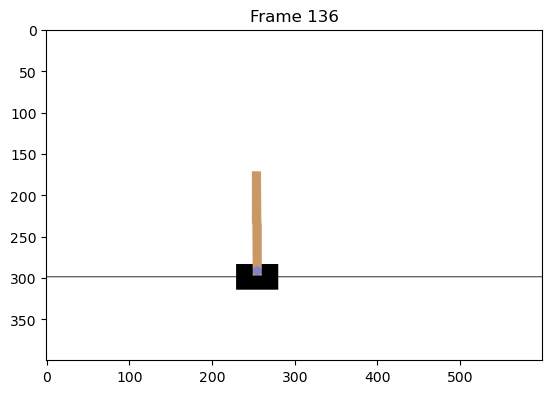

[-0.3585124  -0.36236095 -0.00917032  0.19897202] [-0.3657596  -0.16710904 -0.00519088 -0.09658957] 1
New state:  [-0.3657596  -0.16710904 -0.00519088 -0.09658957] Reward:  1.0 Terminated:  False Truncated:  False


[-0.3657596  -0.16710904 -0.00519088 -0.09658957] [-0.3691018  -0.3621562  -0.00712267  0.19445114] 0
New state:  [-0.3691018  -0.3621562  -0.00712267  0.19445114] Reward:  1.0 Terminated:  False Truncated:  False


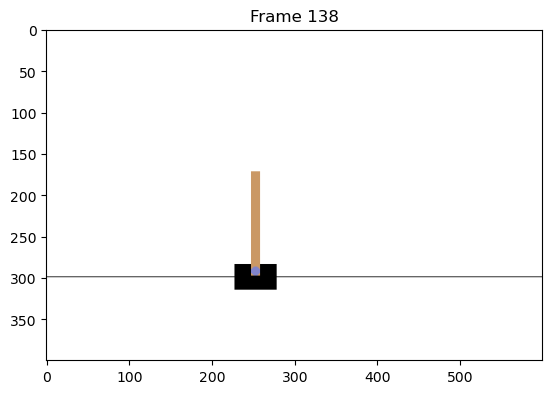

[-0.3691018  -0.3621562  -0.00712267  0.19445114] [-0.37634492 -0.1669331  -0.00323365 -0.10047015] 1
New state:  [-0.37634492 -0.1669331  -0.00323365 -0.10047015] Reward:  1.0 Terminated:  False Truncated:  False


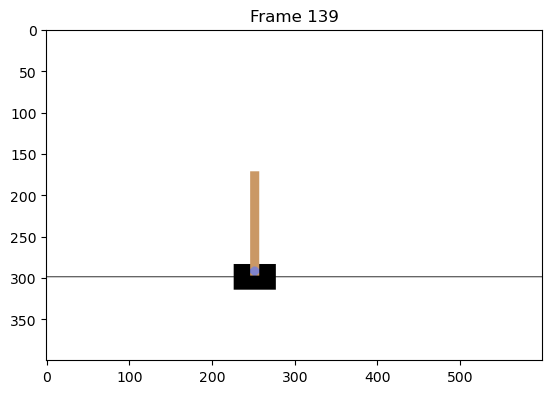

[-0.37634492 -0.1669331  -0.00323365 -0.10047015] [-0.37968358 -0.36200857 -0.00524305  0.19119082] 0
New state:  [-0.37968358 -0.36200857 -0.00524305  0.19119082] Reward:  1.0 Terminated:  False Truncated:  False


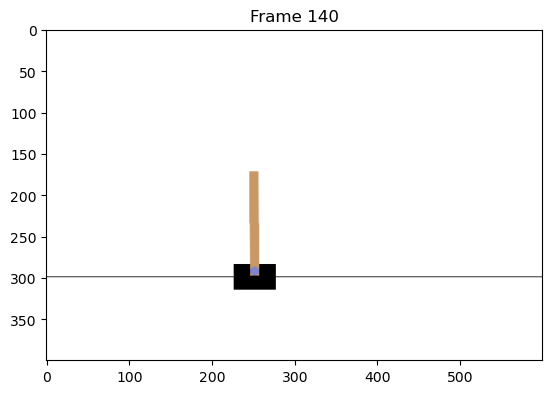

[-0.37968358 -0.36200857 -0.00524305  0.19119082] [-0.38692376 -0.166812   -0.00141923 -0.10314145] 1
New state:  [-0.38692376 -0.166812   -0.00141923 -0.10314145] Reward:  1.0 Terminated:  False Truncated:  False


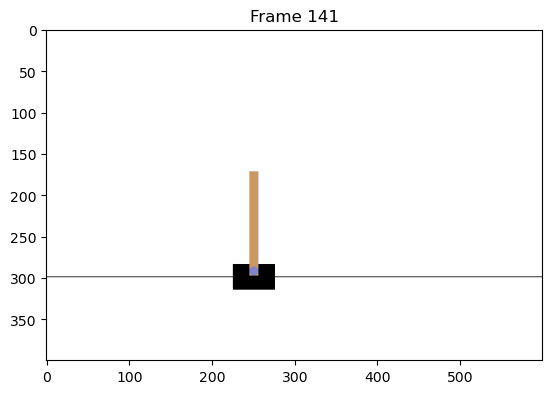

[-0.38692376 -0.166812   -0.00141923 -0.10314145] [-0.39025998 -0.3619136  -0.00348206  0.18909338] 0
New state:  [-0.39025998 -0.3619136  -0.00348206  0.18909338] Reward:  1.0 Terminated:  False Truncated:  False


[-0.39025998 -0.3619136  -0.00348206  0.18909338] [-3.9749825e-01 -1.6674200e-01  2.9980476e-04 -1.0468596e-01] 1
New state:  [-3.9749825e-01 -1.6674200e-01  2.9980476e-04 -1.0468596e-01] Reward:  1.0 Terminated:  False Truncated:  False


[-3.9749825e-01 -1.6674200e-01  2.9980476e-04 -1.0468596e-01] [-0.4008331   0.02837566 -0.00179391 -0.3972743 ] 1
New state:  [-0.4008331   0.02837566 -0.00179391 -0.3972743 ] Reward:  1.0 Terminated:  False Truncated:  False


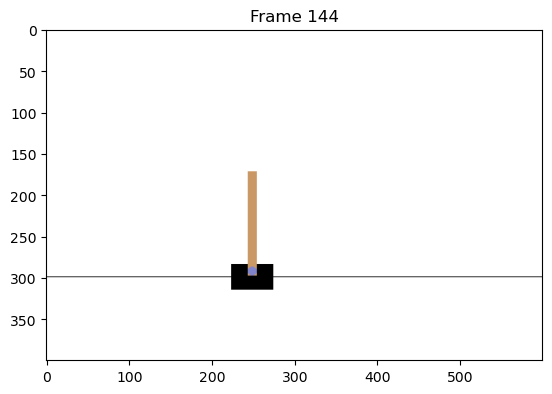

[-0.4008331   0.02837566 -0.00179391 -0.3972743 ] [-0.40026557 -0.1667208  -0.0097394  -0.10515749] 0
New state:  [-0.40026557 -0.1667208  -0.0097394  -0.10515749] Reward:  1.0 Terminated:  False Truncated:  False


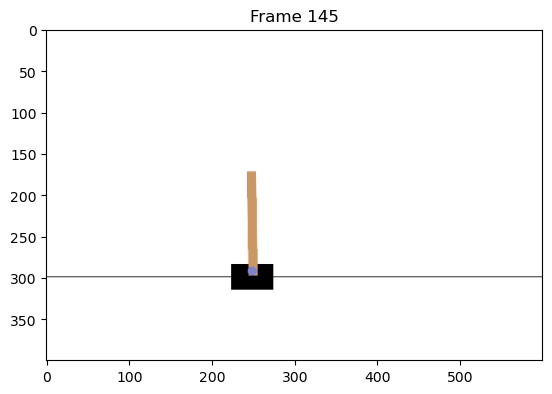

[-0.40026557 -0.1667208  -0.0097394  -0.10515749] [-0.4036     -0.36170182 -0.01184255  0.18443686] 0
New state:  [-0.4036     -0.36170182 -0.01184255  0.18443686] Reward:  1.0 Terminated:  False Truncated:  False


[-0.4036     -0.36170182 -0.01184255  0.18443686] [-0.41083404 -0.16641244 -0.00815381 -0.1119583 ] 1
New state:  [-0.41083404 -0.16641244 -0.00815381 -0.1119583 ] Reward:  1.0 Terminated:  False Truncated:  False


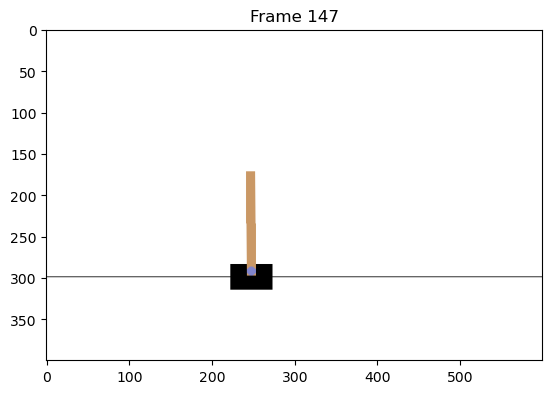

[-0.41083404 -0.16641244 -0.00815381 -0.1119583 ] [-0.41416228 -0.3614166  -0.01039298  0.17814104] 0
New state:  [-0.41416228 -0.3614166  -0.01039298  0.17814104] Reward:  1.0 Terminated:  False Truncated:  False


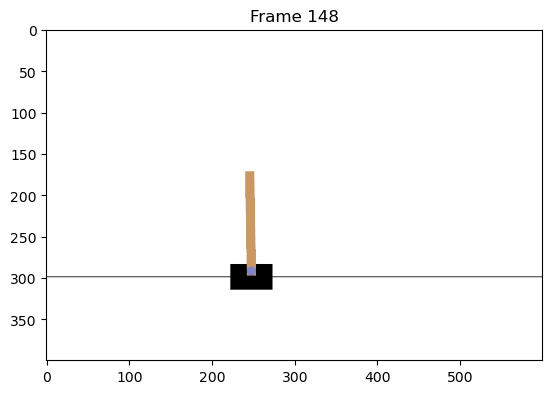

[-0.41416228 -0.3614166  -0.01039298  0.17814104] [-0.42139062 -0.1661475  -0.00683016 -0.11780231] 1
New state:  [-0.42139062 -0.1661475  -0.00683016 -0.11780231] Reward:  1.0 Terminated:  False Truncated:  False


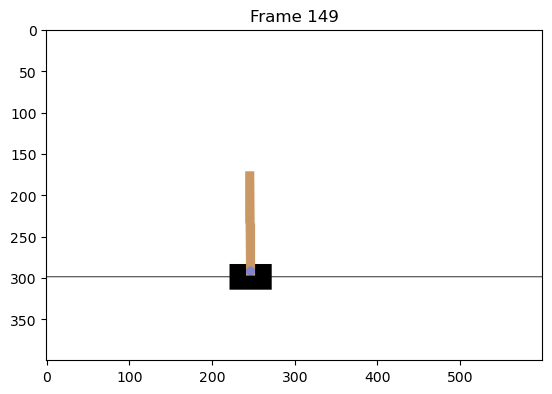

[-0.42139062 -0.1661475  -0.00683016 -0.11780231] [-0.42471358 -0.36117092 -0.0091862   0.17271794] 0
New state:  [-0.42471358 -0.36117092 -0.0091862   0.17271794] Reward:  1.0 Terminated:  False Truncated:  False


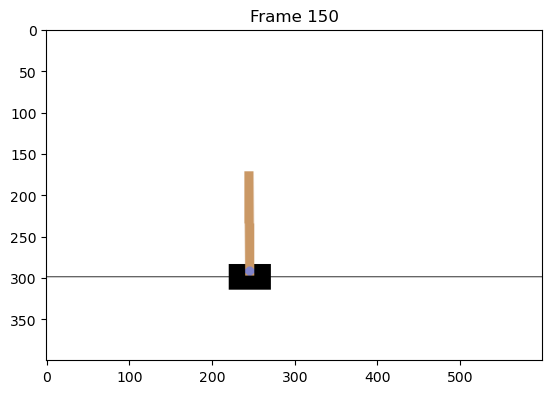

[-0.42471358 -0.36117092 -0.0091862   0.17271794] [-0.43193698 -0.16591871 -0.00573185 -0.12284872] 1
New state:  [-0.43193698 -0.16591871 -0.00573185 -0.12284872] Reward:  1.0 Terminated:  False Truncated:  False


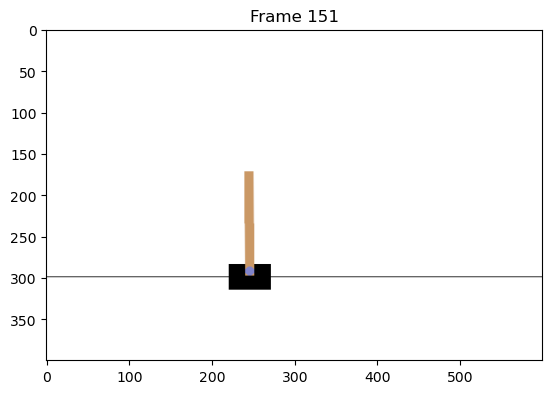

[-0.43193698 -0.16591871 -0.00573185 -0.12284872] [-0.43525535 -0.36095807 -0.00818882  0.16802037] 0
New state:  [-0.43525535 -0.36095807 -0.00818882  0.16802037] Reward:  1.0 Terminated:  False Truncated:  False


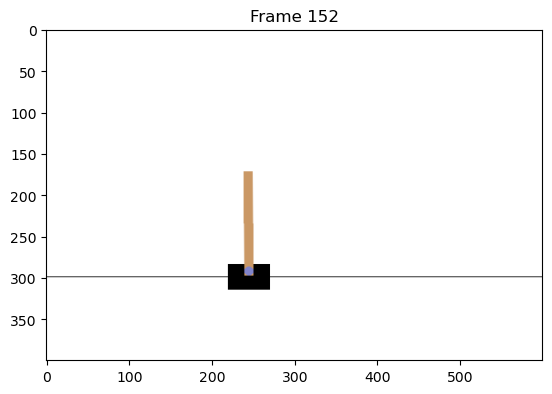

[-0.43525535 -0.36095807 -0.00818882  0.16802037] [-0.4424745  -0.16571987 -0.00482841 -0.12723461] 1
New state:  [-0.4424745  -0.16571987 -0.00482841 -0.12723461] Reward:  1.0 Terminated:  False Truncated:  False


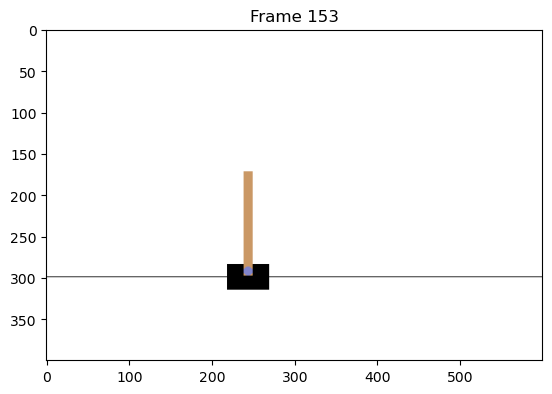

[-0.4424745  -0.16571987 -0.00482841 -0.12723461] [-0.44578892 -0.3607723  -0.0073731   0.16392112] 0
New state:  [-0.44578892 -0.3607723  -0.0073731   0.16392112] Reward:  1.0 Terminated:  False Truncated:  False


[-0.44578892 -0.3607723  -0.0073731   0.16392112] [-0.45300436 -0.1655456  -0.00409468 -0.13107868] 1
New state:  [-0.45300436 -0.1655456  -0.00409468 -0.13107868] Reward:  1.0 Terminated:  False Truncated:  False


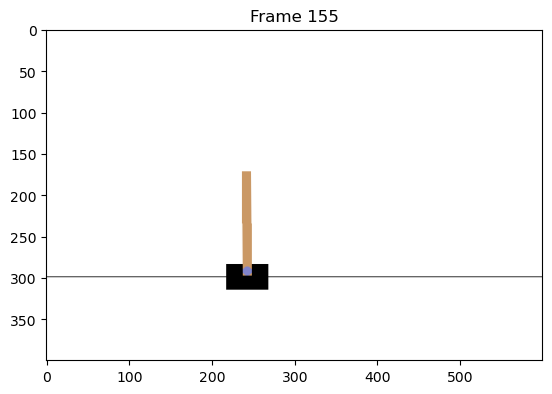

[-0.45300436 -0.1655456  -0.00409468 -0.13107868] [-0.45631528 -0.36060867 -0.00671626  0.16030963] 0
New state:  [-0.45631528 -0.36060867 -0.00671626  0.16030963] Reward:  1.0 Terminated:  False Truncated:  False


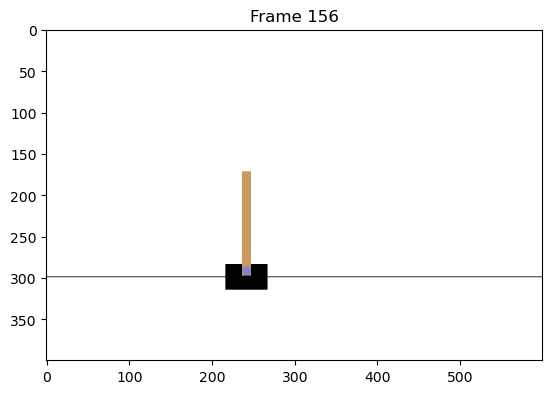

[-0.45631528 -0.36060867 -0.00671626  0.16030963] [-0.46352744 -0.1653912  -0.00351006 -0.13448451] 1
New state:  [-0.46352744 -0.1653912  -0.00351006 -0.13448451] Reward:  1.0 Terminated:  False Truncated:  False


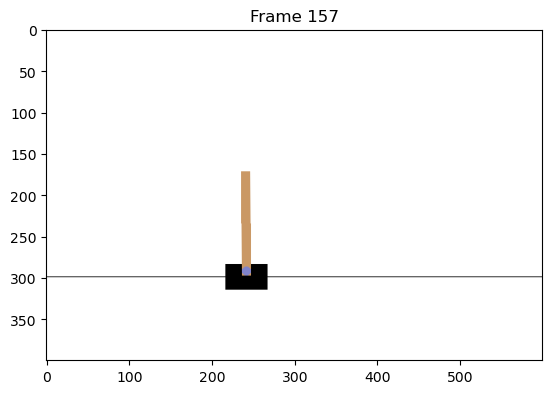

[-0.46352744 -0.1653912  -0.00351006 -0.13448451] [-0.46683526 -0.3604627  -0.00619975  0.15708897] 0
New state:  [-0.46683526 -0.3604627  -0.00619975  0.15708897] Reward:  1.0 Terminated:  False Truncated:  False


[-0.46683526 -0.3604627  -0.00619975  0.15708897] [-0.47404453 -0.16525254 -0.00305797 -0.13754337] 1
New state:  [-0.47404453 -0.16525254 -0.00305797 -0.13754337] Reward:  1.0 Terminated:  False Truncated:  False


[-0.47404453 -0.16525254 -0.00305797 -0.13754337] [-0.47734958 -0.36033055 -0.00580884  0.15417325] 0
New state:  [-0.47734958 -0.36033055 -0.00580884  0.15417325] Reward:  1.0 Terminated:  False Truncated:  False


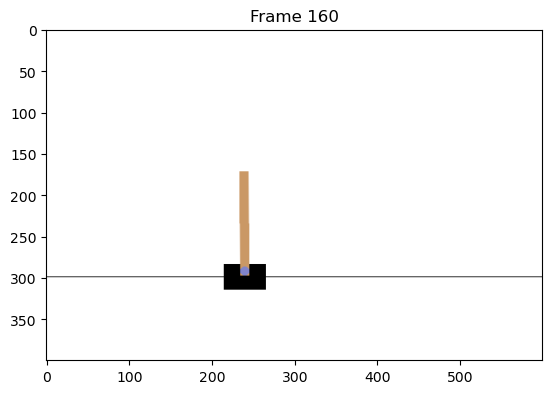

[-0.47734958 -0.36033055 -0.00580884  0.15417325] [-0.4845562  -0.1651259  -0.00272538 -0.14033656] 1
New state:  [-0.4845562  -0.1651259  -0.00272538 -0.14033656] Reward:  1.0 Terminated:  False Truncated:  False


[-0.4845562  -0.1651259  -0.00272538 -0.14033656] [-0.4878587  -0.36020872 -0.00553211  0.15148531] 0
New state:  [-0.4878587  -0.36020872 -0.00553211  0.15148531] Reward:  1.0 Terminated:  False Truncated:  False


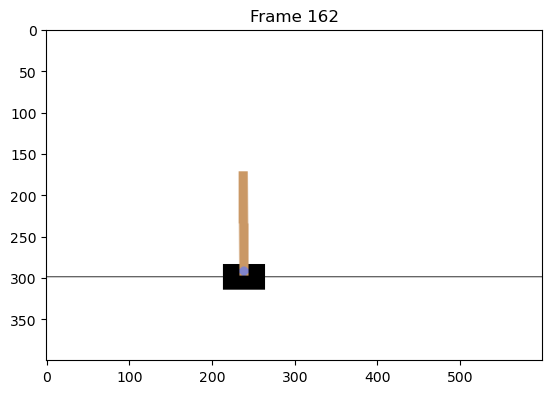

[-0.4878587  -0.36020872 -0.00553211  0.15148531] [-0.4950629  -0.165008   -0.0025024  -0.14293773] 1
New state:  [-0.4950629  -0.165008   -0.0025024  -0.14293773] Reward:  1.0 Terminated:  False Truncated:  False


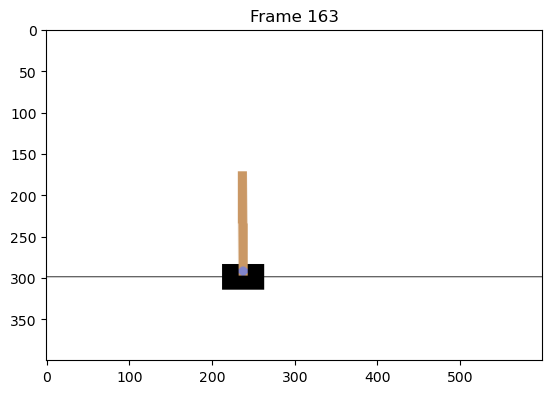

[-0.4950629  -0.165008   -0.0025024  -0.14293773] [-0.49836305 -0.360094   -0.00536116  0.14895469] 0
New state:  [-0.49836305 -0.360094   -0.00536116  0.14895469] Reward:  1.0 Terminated:  False Truncated:  False


[-0.49836305 -0.360094   -0.00536116  0.14895469] [-0.5055649  -0.16489571 -0.00238206 -0.14541474] 1
New state:  [-0.5055649  -0.16489571 -0.00238206 -0.14541474] Reward:  1.0 Terminated:  False Truncated:  False


[-0.5055649  -0.16489571 -0.00238206 -0.14541474] [-0.50886285  0.03026027 -0.00529036 -0.43884823] 1
New state:  [-0.50886285  0.03026027 -0.00529036 -0.43884823] Reward:  1.0 Terminated:  False Truncated:  False


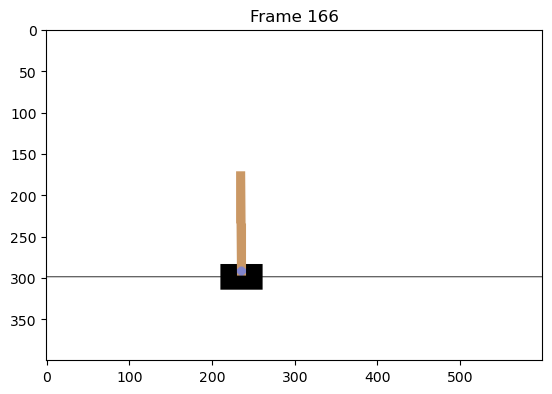

[-0.50886285  0.03026027 -0.00529036 -0.43884823] [-0.5082576  -0.1647864  -0.01406732 -0.14783765] 0
New state:  [-0.5082576  -0.1647864  -0.01406732 -0.14783765] Reward:  1.0 Terminated:  False Truncated:  False


[-0.5082576  -0.1647864  -0.01406732 -0.14783765] [-0.51155335 -0.3597041  -0.01702408  0.14037432] 0
New state:  [-0.51155335 -0.3597041  -0.01702408  0.14037432] Reward:  1.0 Terminated:  False Truncated:  False


[-0.51155335 -0.3597041  -0.01702408  0.14037432] [-0.51874745 -0.16434252 -0.01421659 -0.15763043] 1
New state:  [-0.51874745 -0.16434252 -0.01421659 -0.15763043] Reward:  1.0 Terminated:  False Truncated:  False


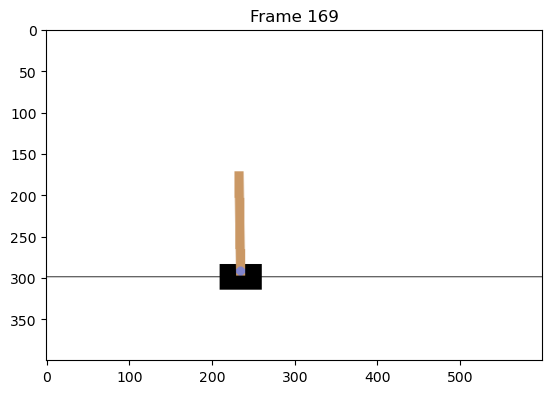

[-0.51874745 -0.16434252 -0.01421659 -0.15763043] [-0.5220343  -0.3592581  -0.0173692   0.13053383] 0
New state:  [-0.5220343  -0.3592581  -0.0173692   0.13053383] Reward:  1.0 Terminated:  False Truncated:  False


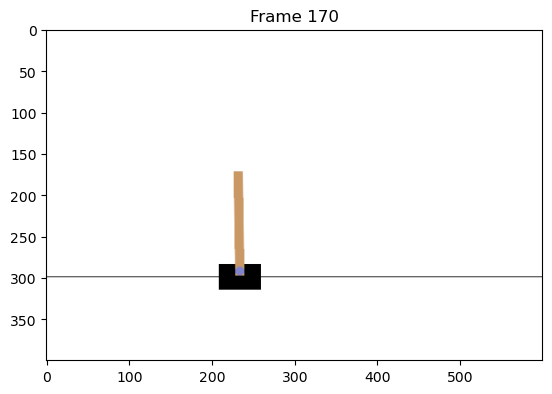

[-0.5220343  -0.3592581  -0.0173692   0.13053383] [-0.52921945 -0.16389169 -0.01475852 -0.16757786] 1
New state:  [-0.52921945 -0.16389169 -0.01475852 -0.16757786] Reward:  1.0 Terminated:  False Truncated:  False


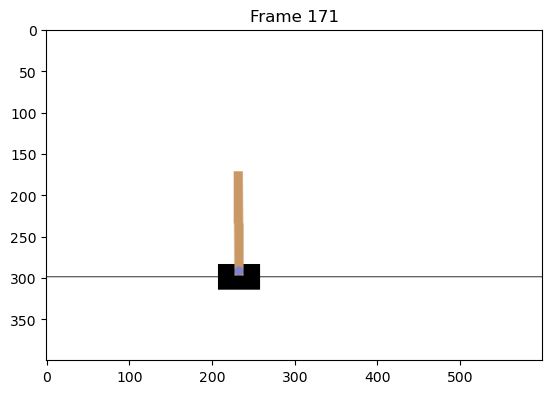

[-0.52921945 -0.16389169 -0.01475852 -0.16757786] [-0.5324973  -0.3587993  -0.01811008  0.12041289] 0
New state:  [-0.5324973  -0.3587993  -0.01811008  0.12041289] Reward:  1.0 Terminated:  False Truncated:  False


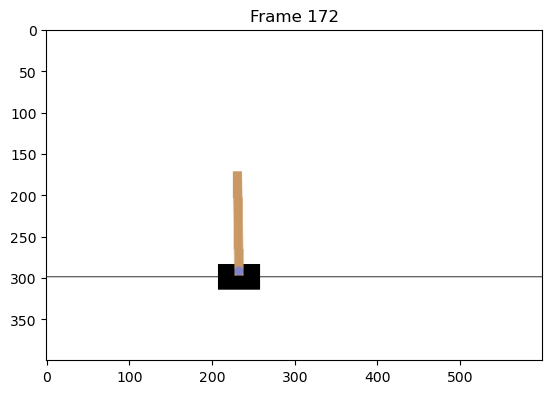

[-0.5324973  -0.3587993  -0.01811008  0.12041289] [-0.53967327 -0.16342263 -0.01570182 -0.17792813] 1
New state:  [-0.53967327 -0.16342263 -0.01570182 -0.17792813] Reward:  1.0 Terminated:  False Truncated:  False


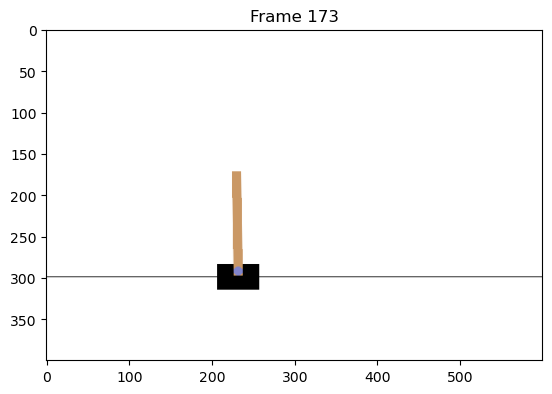

[-0.53967327 -0.16342263 -0.01570182 -0.17792813] [-0.54294175 -0.3583164  -0.01926038  0.10976033] 0
New state:  [-0.54294175 -0.3583164  -0.01926038  0.10976033] Reward:  1.0 Terminated:  False Truncated:  False


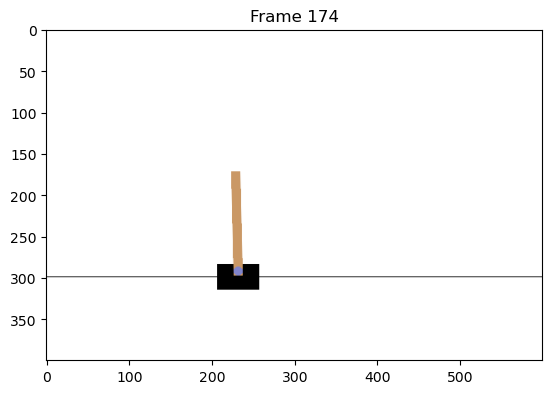

[-0.54294175 -0.3583164  -0.01926038  0.10976033] [-0.5501081  -0.16292383 -0.01706518 -0.18893637] 1
New state:  [-0.5501081  -0.16292383 -0.01706518 -0.18893637] Reward:  1.0 Terminated:  False Truncated:  False


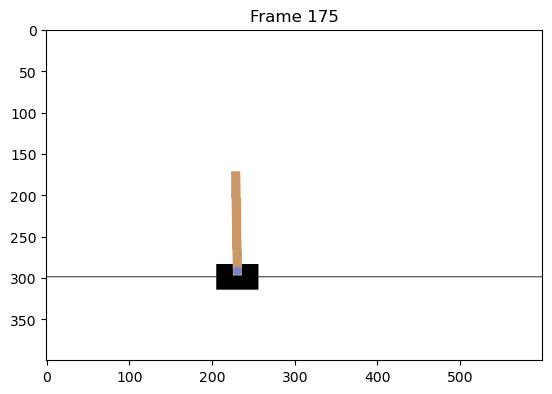

[-0.5501081  -0.16292383 -0.01706518 -0.18893637] [-0.55336654 -0.35779753 -0.0208439   0.0983147 ] 0
New state:  [-0.55336654 -0.35779753 -0.0208439   0.0983147 ] Reward:  1.0 Terminated:  False Truncated:  False


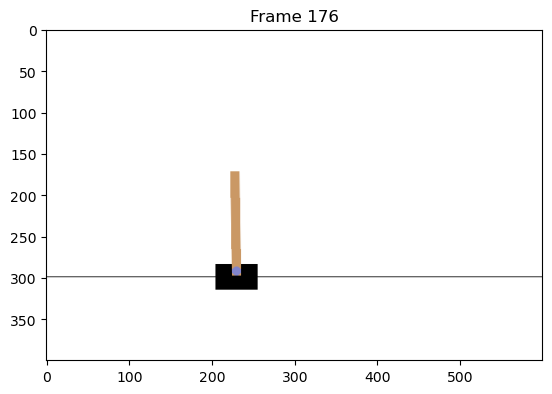

[-0.55336654 -0.35779753 -0.0208439   0.0983147 ] [-0.5605225  -0.16238314 -0.01887761 -0.20087087] 1
New state:  [-0.5605225  -0.16238314 -0.01887761 -0.20087087] Reward:  1.0 Terminated:  False Truncated:  False


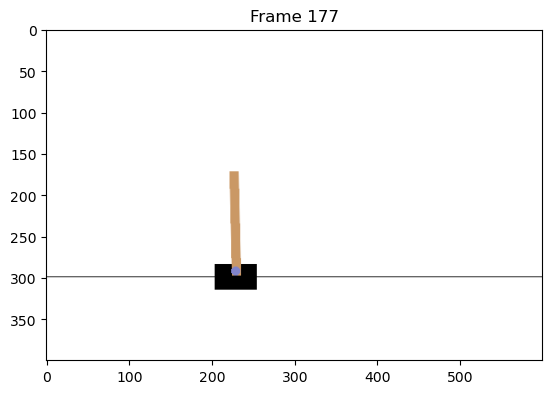

[-0.5605225  -0.16238314 -0.01887761 -0.20087087] [-0.5637701  -0.3572301  -0.02289503  0.08579778] 0
New state:  [-0.5637701  -0.3572301  -0.02289503  0.08579778] Reward:  1.0 Terminated:  False Truncated:  False


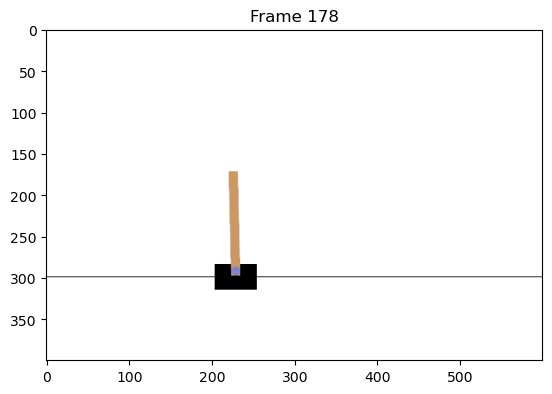

[-0.5637701  -0.3572301  -0.02289503  0.08579778] [-0.57091475 -0.16178755 -0.02117907 -0.21401973] 1
New state:  [-0.57091475 -0.16178755 -0.02117907 -0.21401973] Reward:  1.0 Terminated:  False Truncated:  False


[-0.57091475 -0.16178755 -0.02117907 -0.21401973] [-0.5741505  -0.3566004  -0.02545947  0.07190784] 0
New state:  [-0.5741505  -0.3566004  -0.02545947  0.07190784] Reward:  1.0 Terminated:  False Truncated:  False


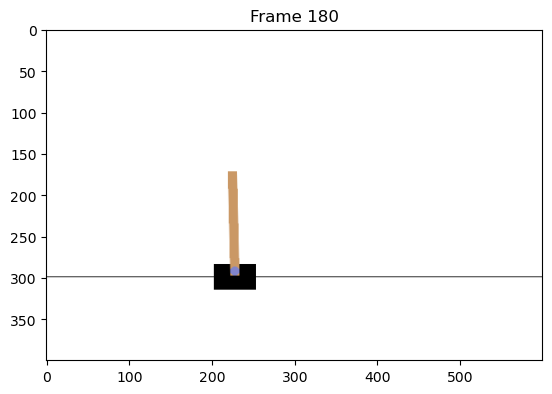

[-0.5741505  -0.3566004  -0.02545947  0.07190784] [-0.5812825  -0.16112289 -0.02402131 -0.22869769] 1
New state:  [-0.5812825  -0.16112289 -0.02402131 -0.22869769] Reward:  1.0 Terminated:  False Truncated:  False


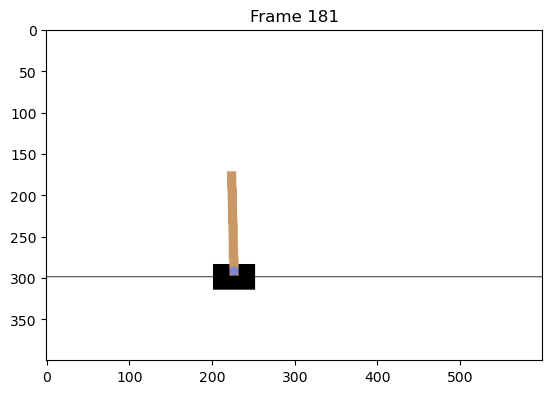

[-0.5812825  -0.16112289 -0.02402131 -0.22869769] [-0.58450496 -0.3558935  -0.02859526  0.05631232] 0
New state:  [-0.58450496 -0.3558935  -0.02859526  0.05631232] Reward:  1.0 Terminated:  False Truncated:  False


[-0.58450496 -0.3558935  -0.02859526  0.05631232] [-0.5916228  -0.16037343 -0.02746902 -0.24525371] 1
New state:  [-0.5916228  -0.16037343 -0.02746902 -0.24525371] Reward:  1.0 Terminated:  False Truncated:  False


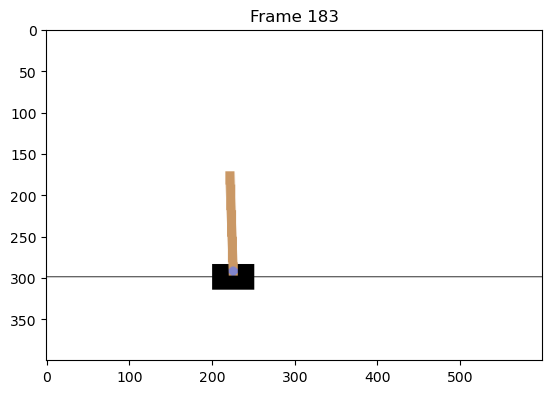

[-0.5916228  -0.16037343 -0.02746902 -0.24525371] [-0.5948303  -0.3550925  -0.03237409  0.03863983] 0
New state:  [-0.5948303  -0.3550925  -0.03237409  0.03863983] Reward:  1.0 Terminated:  False Truncated:  False


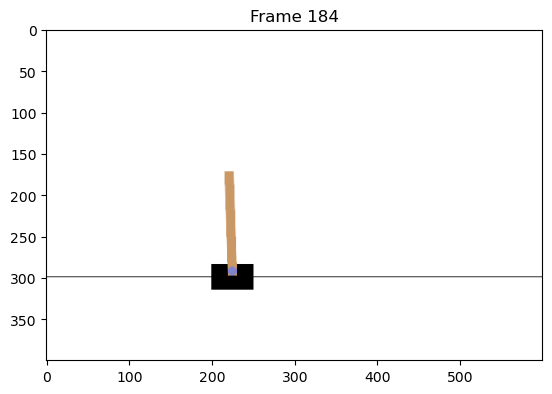

[-0.5948303  -0.3550925  -0.03237409  0.03863983] [-0.60193217 -0.15952162 -0.03160129 -0.2640791 ] 1
New state:  [-0.60193217 -0.15952162 -0.03160129 -0.2640791 ] Reward:  1.0 Terminated:  False Truncated:  False


[-0.60193217 -0.15952162 -0.03160129 -0.2640791 ] [-0.60512257 -0.3541786  -0.03688288  0.01847135] 0
New state:  [-0.60512257 -0.3541786  -0.03688288  0.01847135] Reward:  1.0 Terminated:  False Truncated:  False


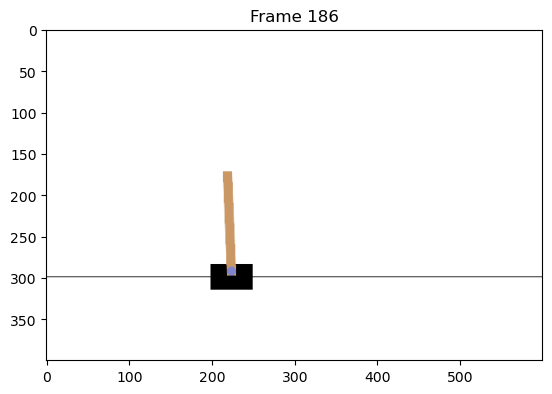

[-0.60512257 -0.3541786  -0.03688288  0.01847135] [-0.61220616 -0.15854765 -0.03651345 -0.2856166 ] 1
New state:  [-0.61220616 -0.15854765 -0.03651345 -0.2856166 ] Reward:  1.0 Terminated:  False Truncated:  False


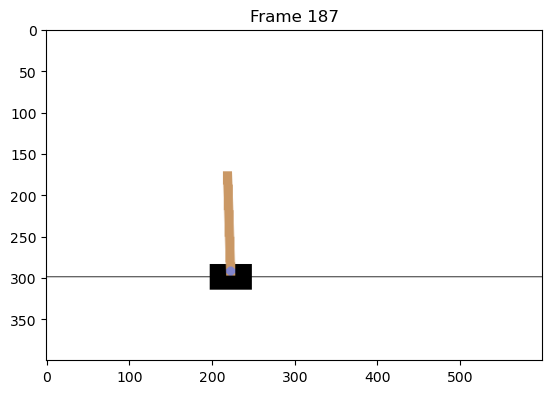

[-0.61220616 -0.15854765 -0.03651345 -0.2856166 ] [-0.6153771  -0.35313034 -0.04222578 -0.00466968] 0
New state:  [-0.6153771  -0.35313034 -0.04222578 -0.00466968] Reward:  1.0 Terminated:  False Truncated:  False


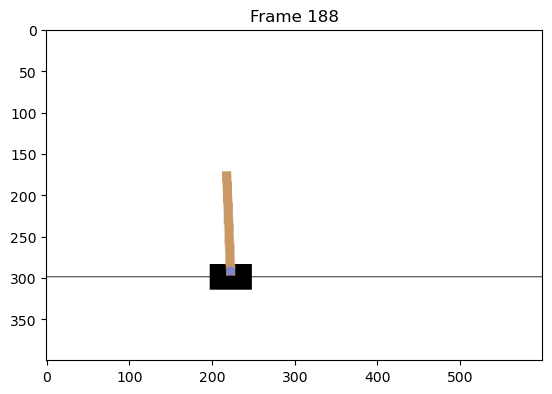

[-0.6153771  -0.35313034 -0.04222578 -0.00466968] [-0.62243974 -0.15742905 -0.04231917 -0.31037065] 1
New state:  [-0.62243974 -0.15742905 -0.04231917 -0.31037065] Reward:  1.0 Terminated:  False Truncated:  False


[-0.62243974 -0.15742905 -0.04231917 -0.31037065] [-0.6255883  -0.35192332 -0.04852659 -0.03132858] 0
New state:  [-0.6255883  -0.35192332 -0.04852659 -0.03132858] Reward:  1.0 Terminated:  False Truncated:  False


[-0.6255883  -0.35192332 -0.04852659 -0.03132858] [-0.6326268  -0.15614027 -0.04915316 -0.33891866] 1
New state:  [-0.6326268  -0.15614027 -0.04915316 -0.33891866] Reward:  1.0 Terminated:  False Truncated:  False


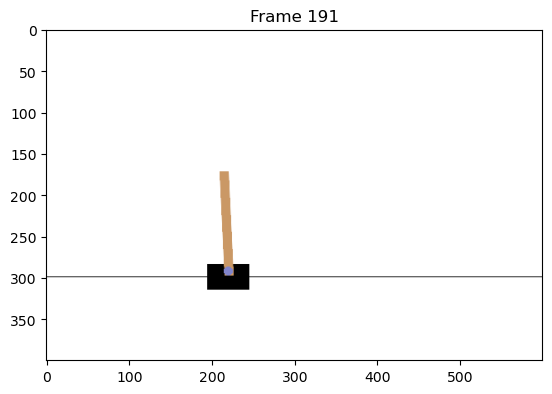

[-0.6326268  -0.15614027 -0.04915316 -0.33891866] [-0.6357496  -0.35052958 -0.05593153 -0.06213205] 0
New state:  [-0.6357496  -0.35052958 -0.05593153 -0.06213205] Reward:  1.0 Terminated:  False Truncated:  False


[-0.6357496  -0.35052958 -0.05593153 -0.06213205] [-0.64276016 -0.54480684 -0.05717417  0.21239285] 0
New state:  [-0.64276016 -0.54480684 -0.05717417  0.21239285] Reward:  1.0 Terminated:  False Truncated:  False


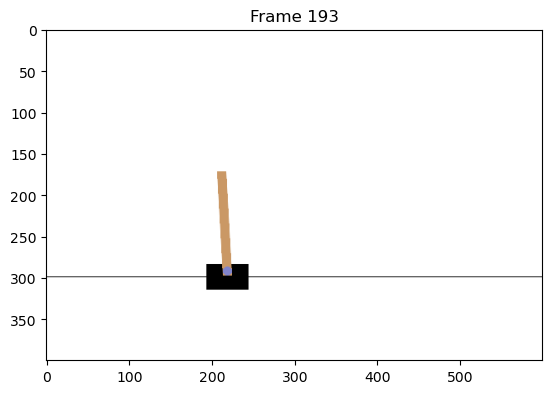

[-0.64276016 -0.54480684 -0.05717417  0.21239285] [-0.6536563  -0.34891605 -0.05292632 -0.09776329] 1
New state:  [-0.6536563  -0.34891605 -0.05292632 -0.09776329] Reward:  1.0 Terminated:  False Truncated:  False


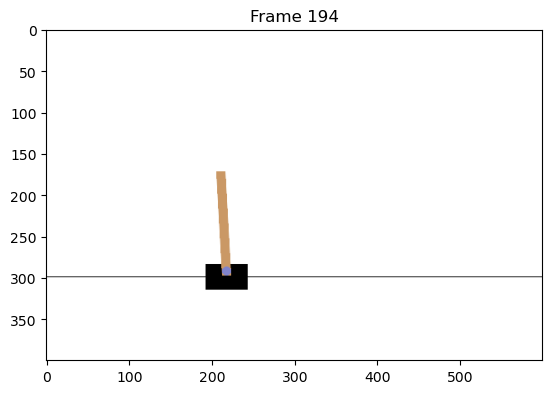

[-0.6536563  -0.34891605 -0.05292632 -0.09776329] [-0.66063464 -0.5432411  -0.05488158  0.17776302] 0
New state:  [-0.66063464 -0.5432411  -0.05488158  0.17776302] Reward:  1.0 Terminated:  False Truncated:  False


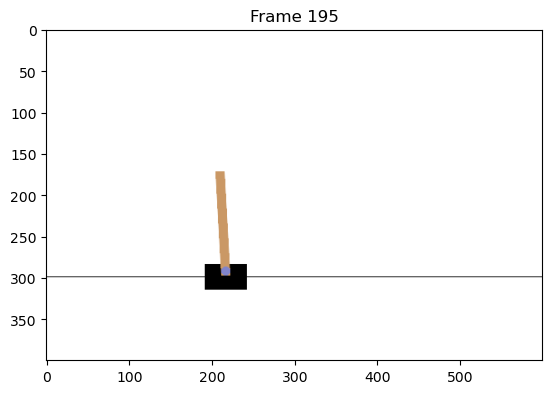

[-0.66063464 -0.5432411  -0.05488158  0.17776302] [-0.67149943 -0.34737843 -0.05132632 -0.13171569] 1
New state:  [-0.67149943 -0.34737843 -0.05132632 -0.13171569] Reward:  1.0 Terminated:  False Truncated:  False


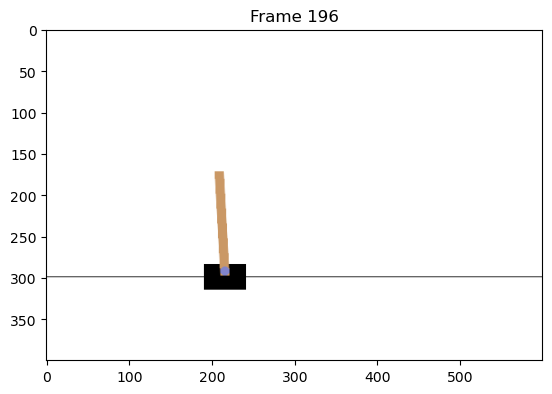

[-0.67149943 -0.34737843 -0.05132632 -0.13171569] [-0.678447   -0.54172903 -0.05396064  0.14434296] 0
New state:  [-0.678447   -0.54172903 -0.05396064  0.14434296] Reward:  1.0 Terminated:  False Truncated:  False


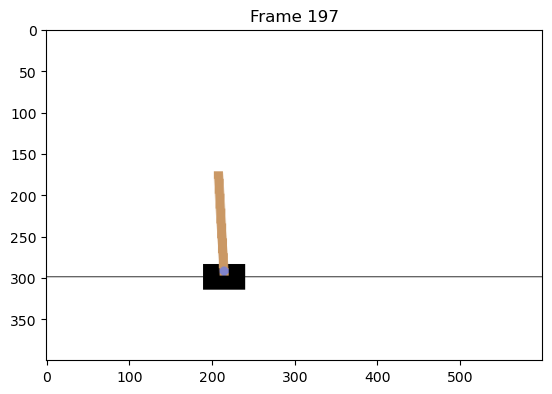

[-0.678447   -0.54172903 -0.05396064  0.14434296] [-0.6892816  -0.34587747 -0.05107378 -0.16486348] 1
New state:  [-0.6892816  -0.34587747 -0.05107378 -0.16486348] Reward:  1.0 Terminated:  False Truncated:  False


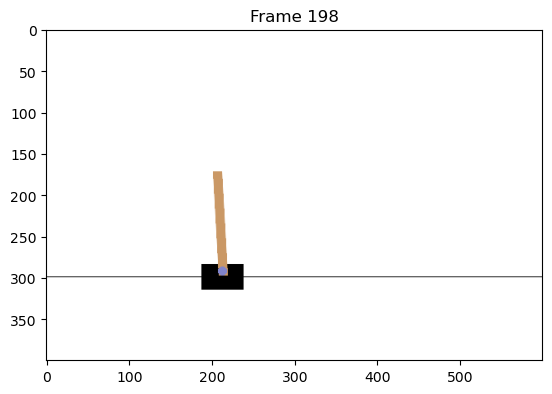

[-0.6892816  -0.34587747 -0.05107378 -0.16486348] [-0.6961991  -0.54023254 -0.05437105  0.11127977] 0
New state:  [-0.6961991  -0.54023254 -0.05437105  0.11127977] Reward:  1.0 Terminated:  False Truncated:  False


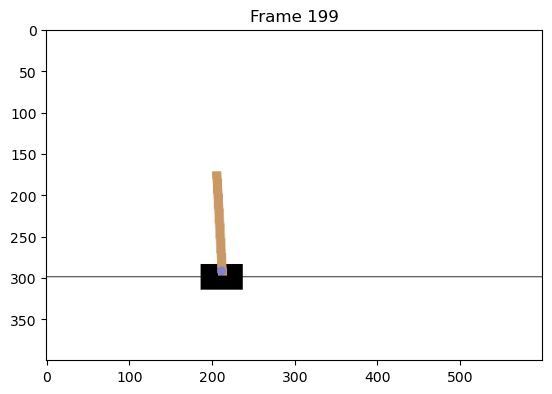

[-0.6961991  -0.54023254 -0.05437105  0.11127977] [-0.7070038  -0.34437534 -0.05214545 -0.1980491 ] 1
New state:  [-0.7070038  -0.34437534 -0.05214545 -0.1980491 ] Reward:  1.0 Terminated:  False Truncated:  False


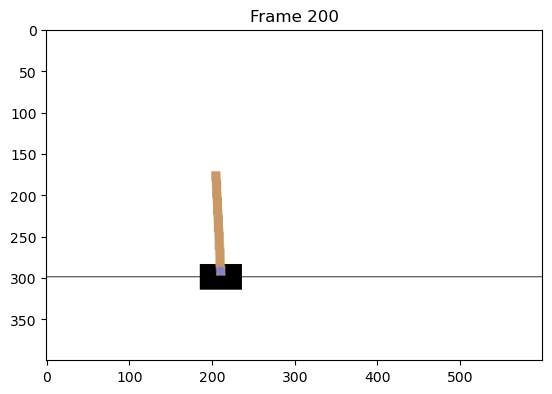

[-0.7070038  -0.34437534 -0.05214545 -0.1980491 ] [-0.71389127 -0.5387142  -0.05610643  0.07773909] 0
New state:  [-0.71389127 -0.5387142  -0.05610643  0.07773909] Reward:  1.0 Terminated:  False Truncated:  False


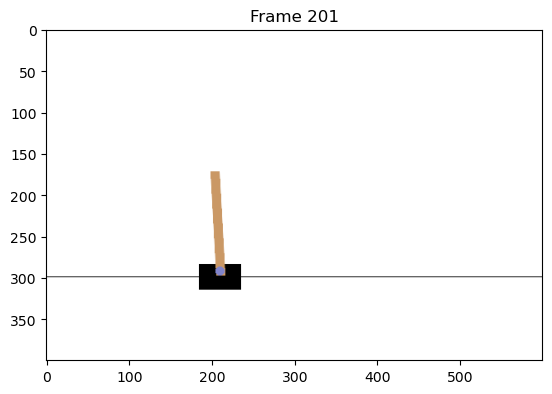

[-0.71389127 -0.5387142  -0.05610643  0.07773909] [-0.7246656  -0.34283465 -0.05455165 -0.23210447] 1
New state:  [-0.7246656  -0.34283465 -0.05455165 -0.23210447] Reward:  1.0 Terminated:  False Truncated:  False


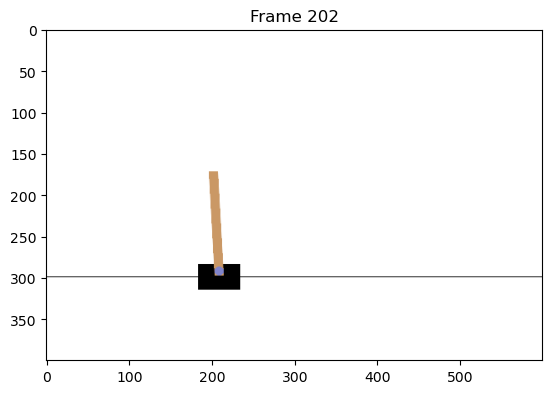

[-0.7246656  -0.34283465 -0.05455165 -0.23210447] [-0.73152226 -0.5371364  -0.05919374  0.04288436] 0
New state:  [-0.73152226 -0.5371364  -0.05919374  0.04288436] Reward:  1.0 Terminated:  False Truncated:  False


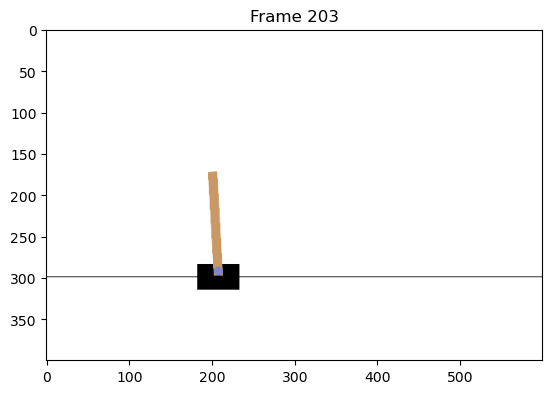

[-0.73152226 -0.5371364  -0.05919374  0.04288436] [-0.742265   -0.3412178  -0.05833605 -0.26787165] 1
New state:  [-0.742265   -0.3412178  -0.05833605 -0.26787165] Reward:  1.0 Terminated:  False Truncated:  False


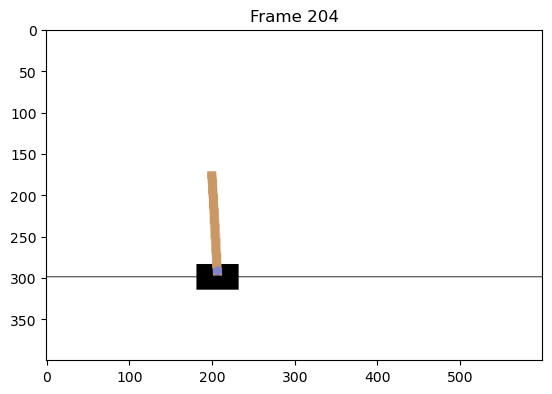

[-0.742265   -0.3412178  -0.05833605 -0.26787165] [-0.74908936 -0.53546077 -0.06369349  0.00585613] 0
New state:  [-0.74908936 -0.53546077 -0.06369349  0.00585613] Reward:  1.0 Terminated:  False Truncated:  False


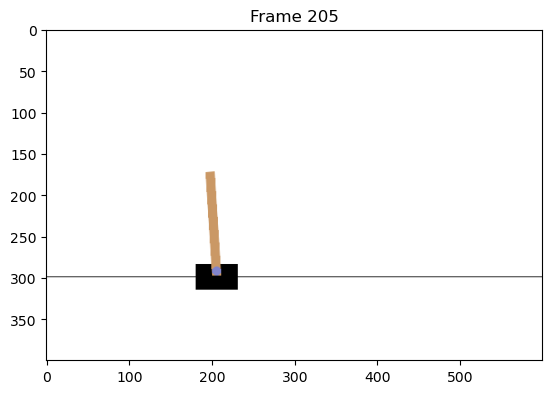

[-0.74908936 -0.53546077 -0.06369349  0.00585613] [-0.7597986  -0.33948594 -0.06357636 -0.30622327] 1
New state:  [-0.7597986  -0.33948594 -0.06357636 -0.30622327] Reward:  1.0 Terminated:  False Truncated:  False


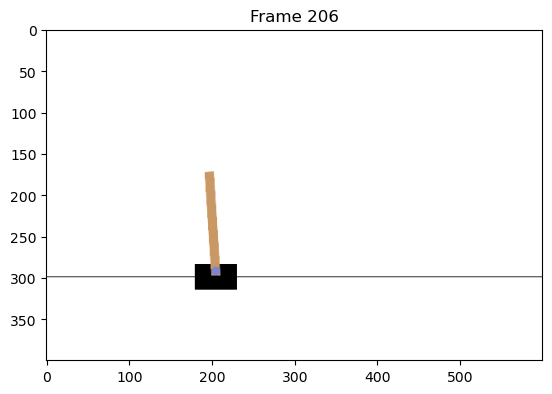

[-0.7597986  -0.33948594 -0.06357636 -0.30622327] [-0.7665883  -0.533647   -0.06970083 -0.03424889] 0
New state:  [-0.7665883  -0.533647   -0.06970083 -0.03424889] Reward:  1.0 Terminated:  False Truncated:  False


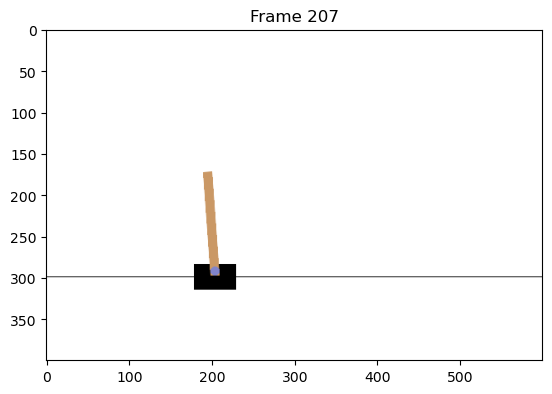

[-0.7665883  -0.533647   -0.06970083 -0.03424889] [-0.77726126 -0.7277038  -0.07038581  0.23565404] 0
New state:  [-0.77726126 -0.7277038  -0.07038581  0.23565404] Reward:  1.0 Terminated:  False Truncated:  False


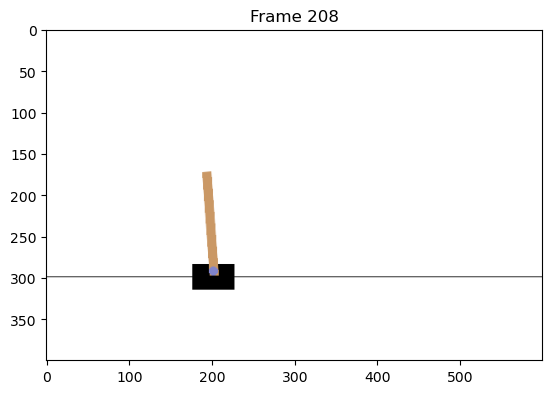

[-0.77726126 -0.7277038  -0.07038581  0.23565404] [-0.7918153  -0.5316505  -0.06567273 -0.07837409] 1
New state:  [-0.7918153  -0.5316505  -0.06567273 -0.07837409] Reward:  1.0 Terminated:  False Truncated:  False


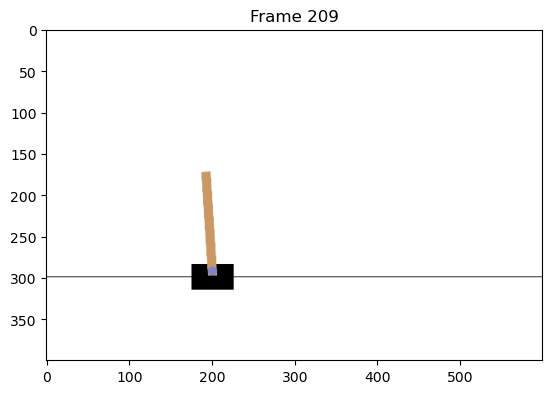

[-0.7918153  -0.5316505  -0.06567273 -0.07837409] [-0.80244833 -0.72577256 -0.06724021  0.19288737] 0
New state:  [-0.80244833 -0.72577256 -0.06724021  0.19288737] Reward:  1.0 Terminated:  False Truncated:  False


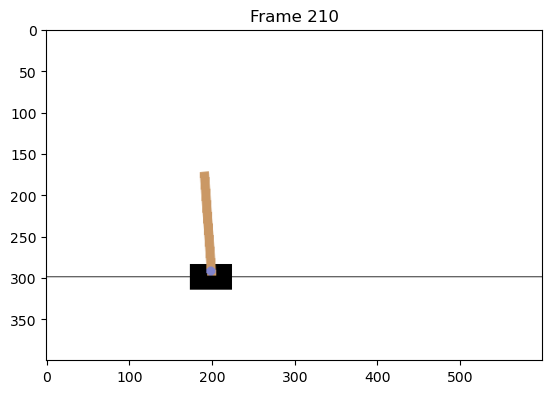

[-0.80244833 -0.72577256 -0.06724021  0.19288737] [-0.8169638  -0.52975637 -0.06338246 -0.12022621] 1
New state:  [-0.8169638  -0.52975637 -0.06338246 -0.12022621] Reward:  1.0 Terminated:  False Truncated:  False


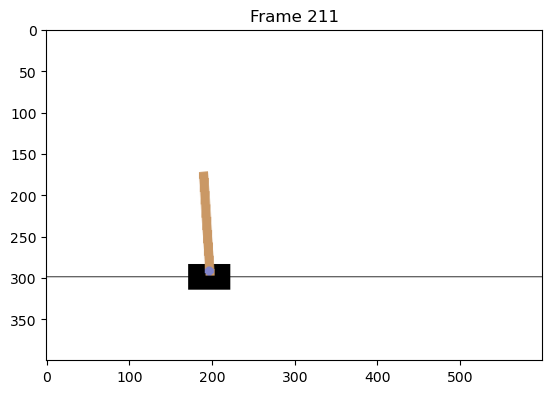

[-0.8169638  -0.52975637 -0.06338246 -0.12022621] [-0.8275589  -0.72391564 -0.06578699  0.15180594] 0
New state:  [-0.8275589  -0.72391564 -0.06578699  0.15180594] Reward:  1.0 Terminated:  False Truncated:  False


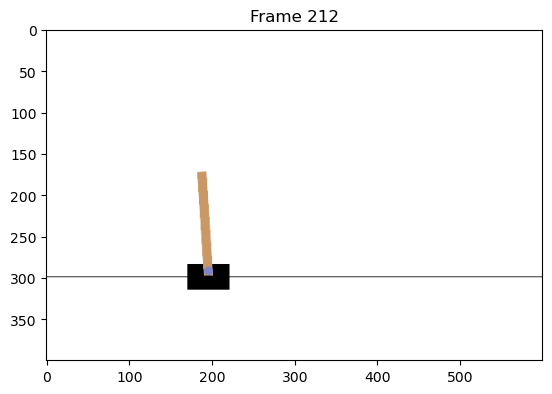

[-0.8275589  -0.72391564 -0.06578699  0.15180594] [-0.8420372  -0.5279164  -0.06275087 -0.1608844 ] 1
New state:  [-0.8420372  -0.5279164  -0.06275087 -0.1608844 ] Reward:  1.0 Terminated:  False Truncated:  False


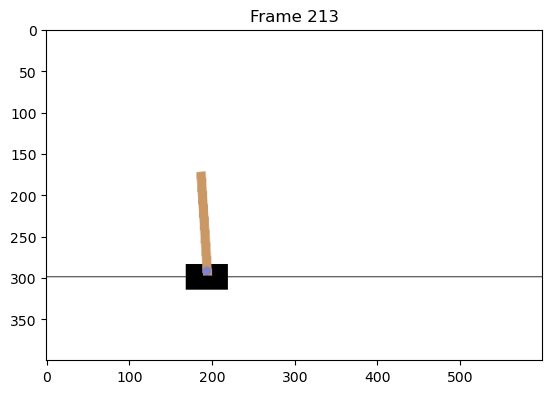

[-0.8420372  -0.5279164  -0.06275087 -0.1608844 ] [-0.8525955  -0.7220865  -0.06596855  0.11136083] 0
New state:  [-0.8525955  -0.7220865  -0.06596855  0.11136083] Reward:  1.0 Terminated:  False Truncated:  False


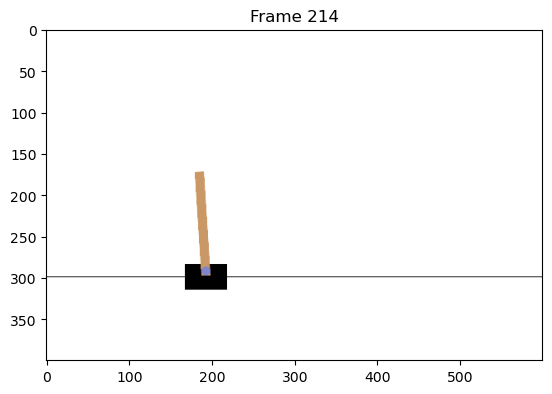

[-0.8525955  -0.7220865  -0.06596855  0.11136083] [-0.86703724 -0.5260843  -0.06374134 -0.20138362] 1
New state:  [-0.86703724 -0.5260843  -0.06374134 -0.20138362] Reward:  1.0 Terminated:  False Truncated:  False


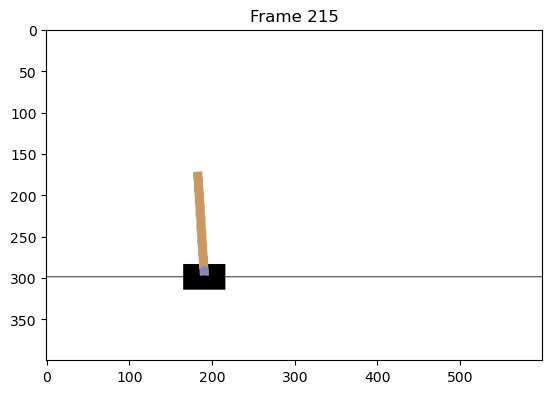

[-0.86703724 -0.5260843  -0.06374134 -0.20138362] [-0.87755895 -0.72023946 -0.06776901  0.07053041] 0
New state:  [-0.87755895 -0.72023946 -0.06776901  0.07053041] Reward:  1.0 Terminated:  False Truncated:  False


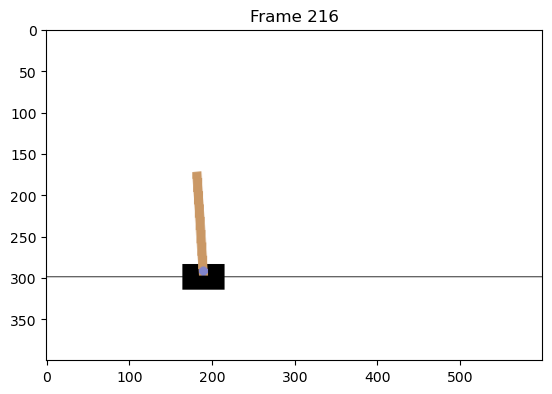

[-0.87755895 -0.72023946 -0.06776901  0.07053041] [-0.8919637  -0.5242147  -0.0663584  -0.24274066] 1
New state:  [-0.8919637  -0.5242147  -0.0663584  -0.24274066] Reward:  1.0 Terminated:  False Truncated:  False


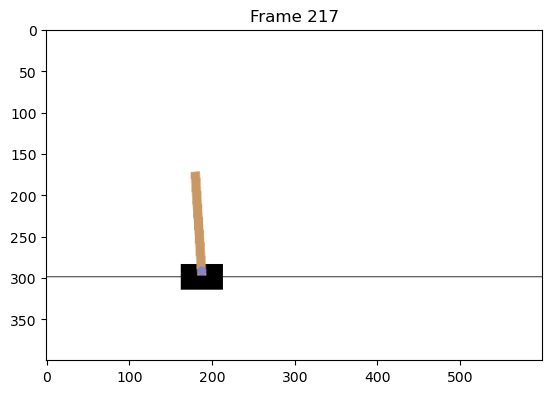

[-0.8919637  -0.5242147  -0.0663584  -0.24274066] [-0.90244806 -0.7183291  -0.07121322  0.02829508] 0
New state:  [-0.90244806 -0.7183291  -0.07121322  0.02829508] Reward:  1.0 Terminated:  False Truncated:  False


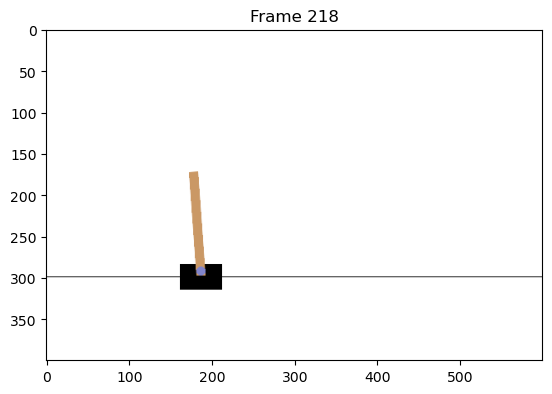

[-0.90244806 -0.7183291  -0.07121322  0.02829508] [-0.9168146  -0.522262   -0.07064731 -0.28597915] 1
New state:  [-0.9168146  -0.522262   -0.07064731 -0.28597915] Reward:  1.0 Terminated:  False Truncated:  False


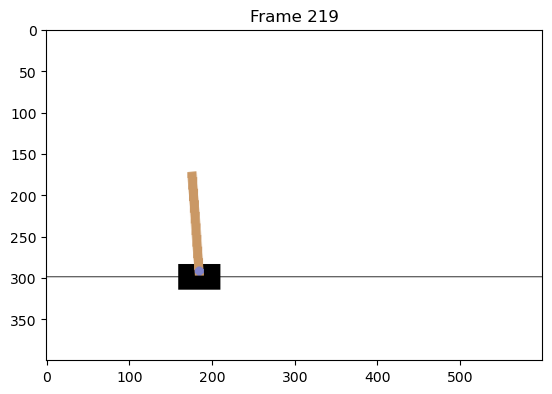

[-0.9168146  -0.522262   -0.07064731 -0.28597915] [-0.92725986 -0.716309   -0.07636689 -0.01638774] 0
New state:  [-0.92725986 -0.716309   -0.07636689 -0.01638774] Reward:  1.0 Terminated:  False Truncated:  False


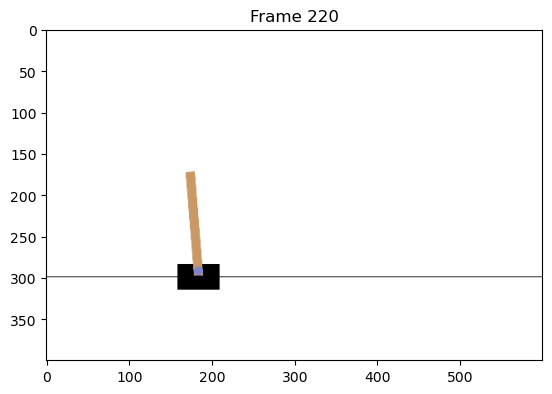

[-0.92725986 -0.716309   -0.07636689 -0.01638774] [-0.941586   -0.9102574  -0.07669465  0.2512569 ] 0
New state:  [-0.941586   -0.9102574  -0.07669465  0.2512569 ] Reward:  1.0 Terminated:  False Truncated:  False


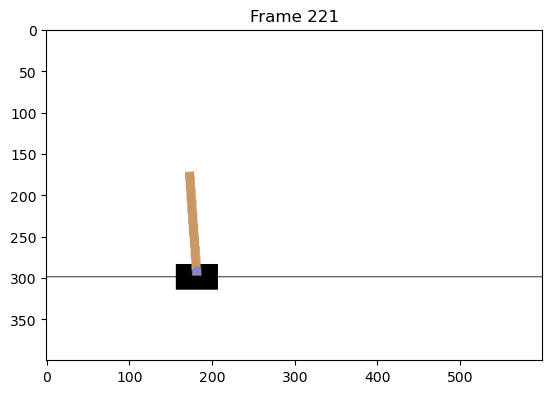

[-0.941586   -0.9102574  -0.07669465  0.2512569 ] [-0.9597912  -0.71412885 -0.07166951 -0.06459729] 1
New state:  [-0.9597912  -0.71412885 -0.07166951 -0.06459729] Reward:  1.0 Terminated:  False Truncated:  False


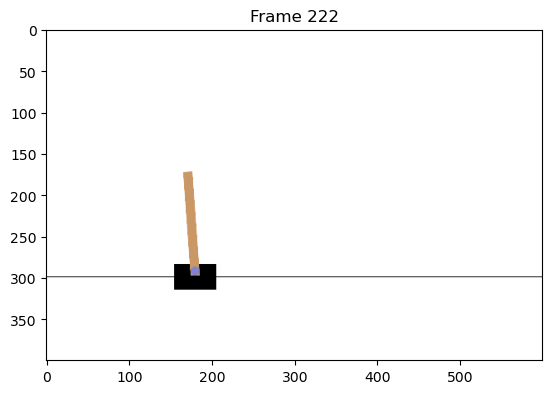

[-0.9597912  -0.71412885 -0.07166951 -0.06459729] [-0.97407377 -0.90815395 -0.07296146  0.20464043] 0
New state:  [-0.97407377 -0.90815395 -0.07296146  0.20464043] Reward:  1.0 Terminated:  False Truncated:  False


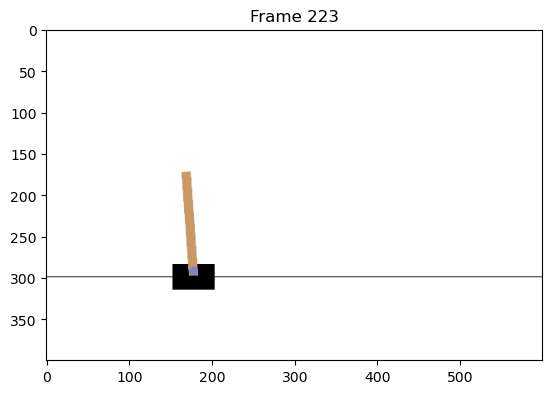

[-0.97407377 -0.90815395 -0.07296146  0.20464043] [-0.99223685 -0.71206856 -0.06886865 -0.11013676] 1
New state:  [-0.99223685 -0.71206856 -0.06886865 -0.11013676] Reward:  1.0 Terminated:  False Truncated:  False


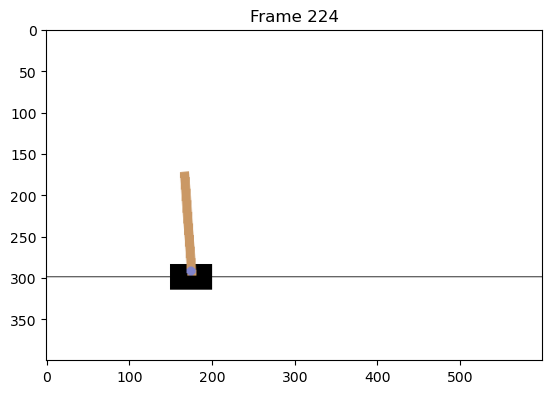

[-0.99223685 -0.71206856 -0.06886865 -0.11013676] [-1.0064782  -0.9061395  -0.07107139  0.16004823] 0
New state:  [-1.0064782  -0.9061395  -0.07107139  0.16004823] Reward:  1.0 Terminated:  False Truncated:  False


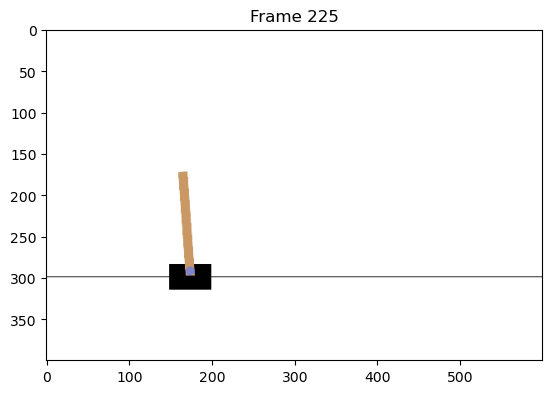

[-1.0064782  -0.9061395  -0.07107139  0.16004823] [-1.024601   -0.71007586 -0.06787042 -0.15418224] 1
New state:  [-1.024601   -0.71007586 -0.06787042 -0.15418224] Reward:  1.0 Terminated:  False Truncated:  False


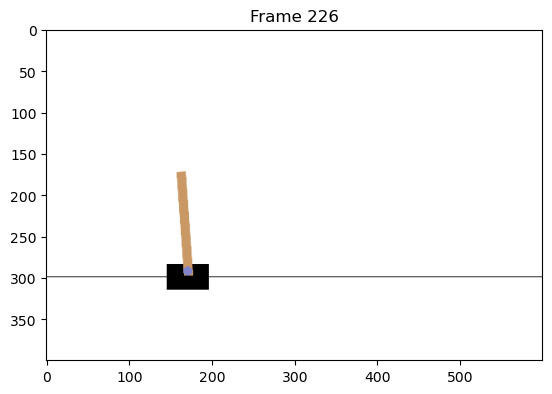

[-1.024601   -0.71007586 -0.06787042 -0.15418224] [-1.0388025  -0.90416366 -0.07095406  0.11634064] 0
New state:  [-1.0388025  -0.90416366 -0.07095406  0.11634064] Reward:  1.0 Terminated:  False Truncated:  False


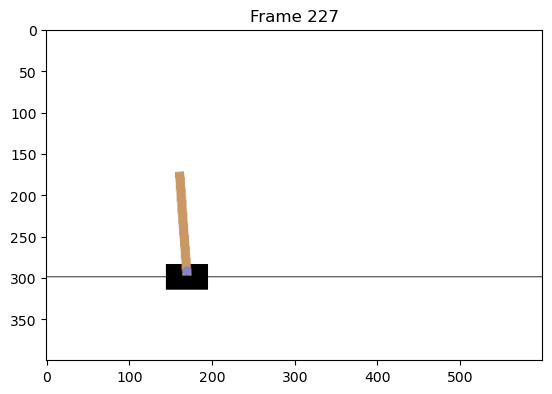

[-1.0388025  -0.90416366 -0.07095406  0.11634064] [-1.0568858  -0.70810056 -0.06862725 -0.19785698] 1
New state:  [-1.0568858  -0.70810056 -0.06862725 -0.19785698] Reward:  1.0 Terminated:  False Truncated:  False


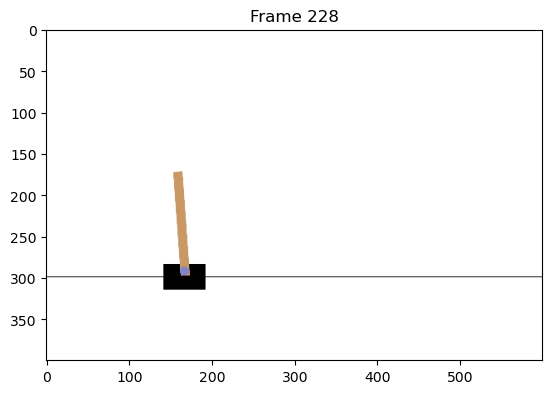

[-1.0568858  -0.70810056 -0.06862725 -0.19785698] [-1.0710478  -0.9021773  -0.07258439  0.07241218] 0
New state:  [-1.0710478  -0.9021773  -0.07258439  0.07241218] Reward:  1.0 Terminated:  False Truncated:  False


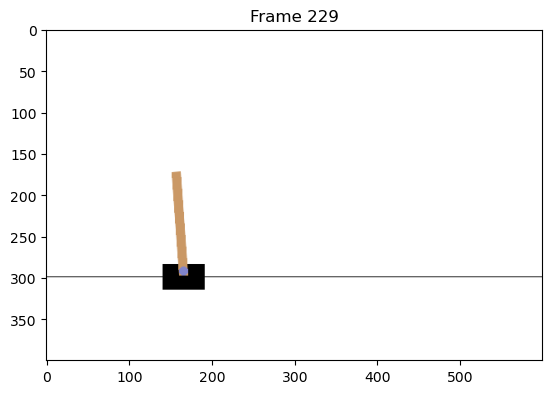

[-1.0710478  -0.9021773  -0.07258439  0.07241218] [-1.0890913  -0.7060938  -0.07113615 -0.24225959] 1
New state:  [-1.0890913  -0.7060938  -0.07113615 -0.24225959] Reward:  1.0 Terminated:  False Truncated:  False


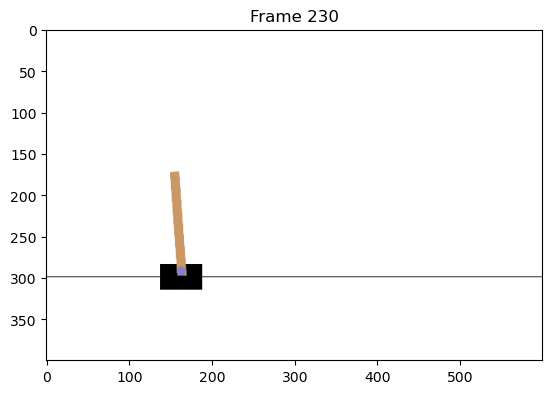

[-1.0890913  -0.7060938  -0.07113615 -0.24225959] [-1.1032132  -0.90013134 -0.07598134  0.0271642 ] 0
New state:  [-1.1032132  -0.90013134 -0.07598134  0.0271642 ] Reward:  1.0 Terminated:  False Truncated:  False


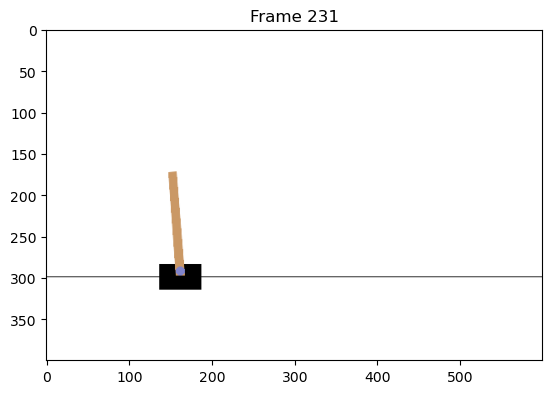

[-1.1032132  -0.90013134 -0.07598134  0.0271642 ] [-1.1212158  -0.7040067  -0.07543806 -0.2884911 ] 1
New state:  [-1.1212158  -0.7040067  -0.07543806 -0.2884911 ] Reward:  1.0 Terminated:  False Truncated:  False


[-1.1212158  -0.7040067  -0.07543806 -0.2884911 ] [-1.135296   -0.8979763  -0.08120788 -0.02052186] 0
New state:  [-1.135296   -0.8979763  -0.08120788 -0.02052186] Reward:  1.0 Terminated:  False Truncated:  False


[-1.135296   -0.8979763  -0.08120788 -0.02052186] [-1.1532555  -0.7017893  -0.08161832 -0.3376814 ] 1
New state:  [-1.1532555  -0.7017893  -0.08161832 -0.3376814 ] Reward:  1.0 Terminated:  False Truncated:  False


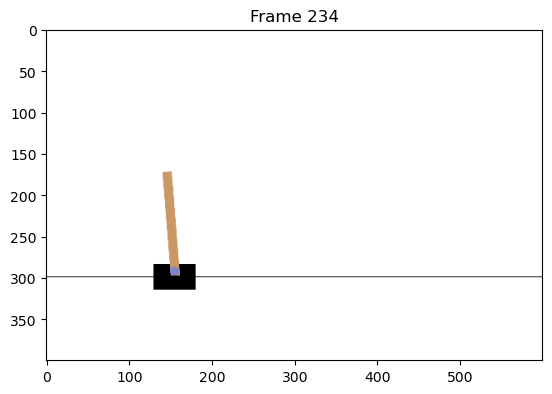

[-1.1532555  -0.7017893  -0.08161832 -0.3376814 ] [-1.1672913  -0.8956607  -0.08837195 -0.07181153] 0
New state:  [-1.1672913  -0.8956607  -0.08837195 -0.07181153] Reward:  1.0 Terminated:  False Truncated:  False


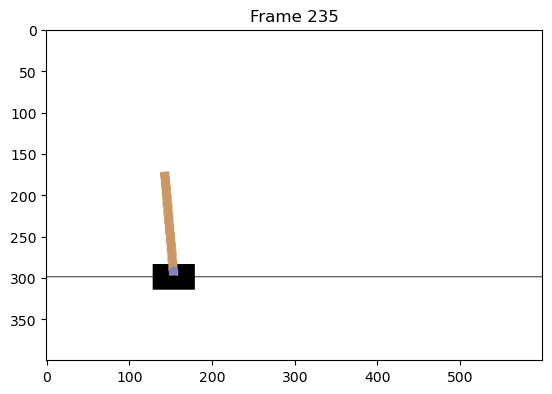

[-1.1672913  -0.8956607  -0.08837195 -0.07181153] [-1.1852045  -1.0894119  -0.08980817  0.19173357] 0
New state:  [-1.1852045  -1.0894119  -0.08980817  0.19173357] Reward:  1.0 Terminated:  False Truncated:  False


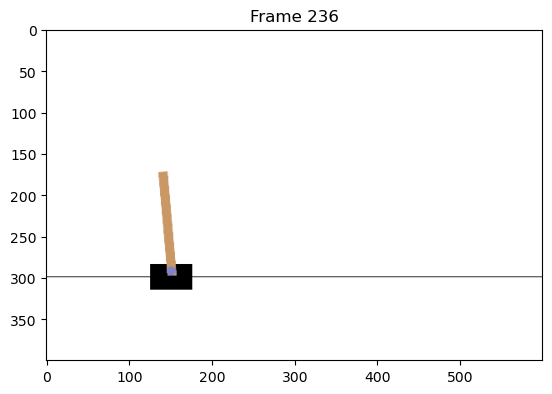

[-1.1852045  -1.0894119  -0.08980817  0.19173357] [-1.2069927 -0.8931276 -0.0859735 -0.1278744] 1
New state:  [-1.2069927 -0.8931276 -0.0859735 -0.1278744] Reward:  1.0 Terminated:  False Truncated:  False


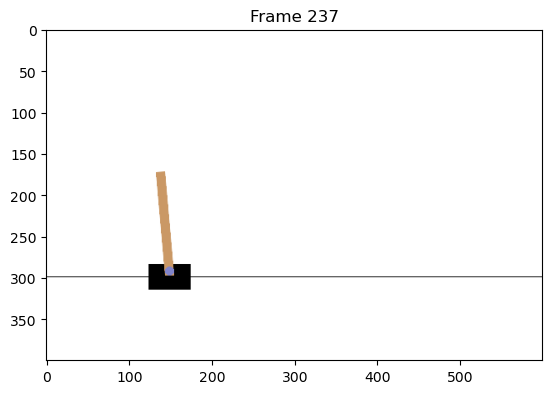

[-1.2069927 -0.8931276 -0.0859735 -0.1278744] [-1.2248553  -1.0869194  -0.08853099  0.13649465] 0
New state:  [-1.2248553  -1.0869194  -0.08853099  0.13649465] Reward:  1.0 Terminated:  False Truncated:  False


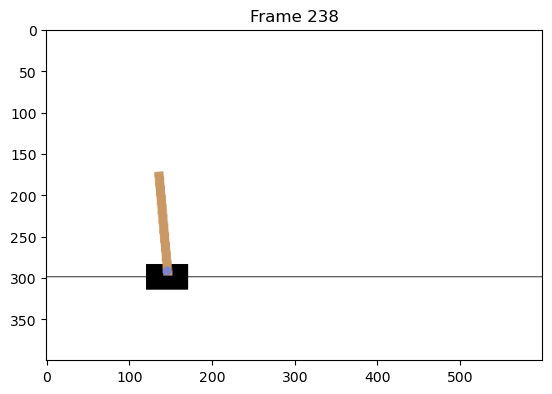

[-1.2248553  -1.0869194  -0.08853099  0.13649465] [-1.2465937  -0.89064837 -0.08580109 -0.18275318] 1
New state:  [-1.2465937  -0.89064837 -0.08580109 -0.18275318] Reward:  1.0 Terminated:  False Truncated:  False


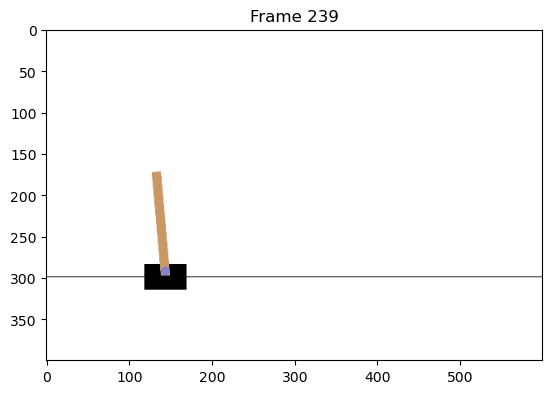

[-1.2465937  -0.89064837 -0.08580109 -0.18275318] [-1.2644067  -1.0844445  -0.08945616  0.08167707] 0
New state:  [-1.2644067  -1.0844445  -0.08945616  0.08167707] Reward:  1.0 Terminated:  False Truncated:  False


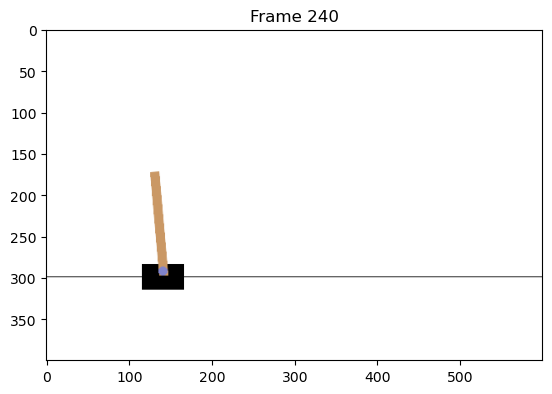

[-1.2644067  -1.0844445  -0.08945616  0.08167707] [-1.2860955  -0.88816166 -0.08782262 -0.23783498] 1
New state:  [-1.2860955  -0.88816166 -0.08782262 -0.23783498] Reward:  1.0 Terminated:  False Truncated:  False


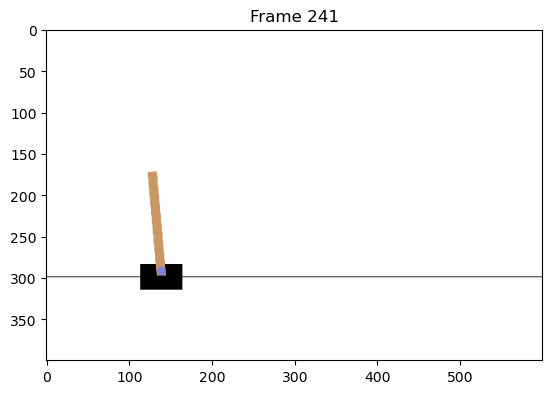

[-1.2860955  -0.88816166 -0.08782262 -0.23783498] [-1.3038588  -1.0819263  -0.09257932  0.02590524] 0
New state:  [-1.3038588  -1.0819263  -0.09257932  0.02590524] Reward:  1.0 Terminated:  False Truncated:  False


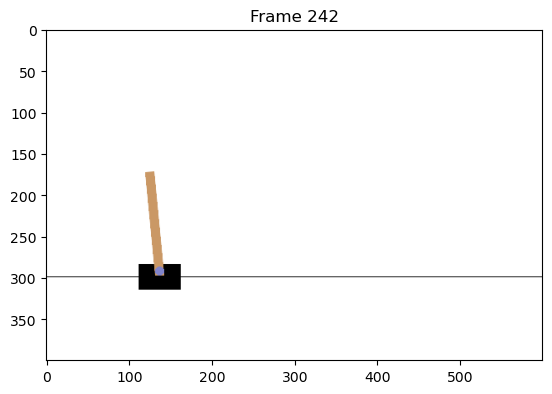

[-1.3038588  -1.0819263  -0.09257932  0.02590524] [-1.3254973  -0.88560706 -0.09206121 -0.29449204] 1
New state:  [-1.3254973  -0.88560706 -0.09206121 -0.29449204] Reward:  1.0 Terminated:  False Truncated:  False


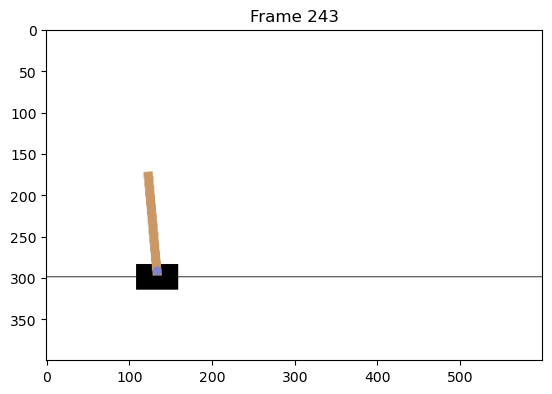

[-1.3254973  -0.88560706 -0.09206121 -0.29449204] [-1.3432095  -1.0793041  -0.09795105 -0.03220453] 0
New state:  [-1.3432095  -1.0793041  -0.09795105 -0.03220453] Reward:  1.0 Terminated:  False Truncated:  False


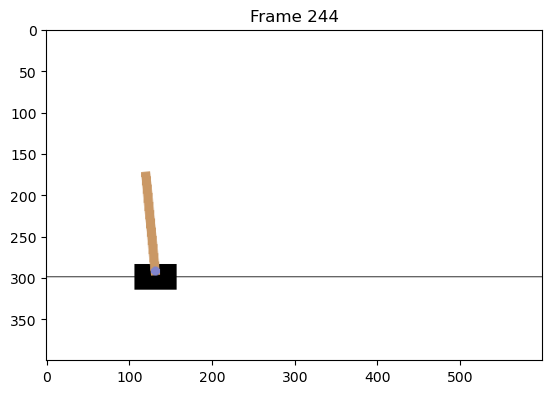

[-1.3432095  -1.0793041  -0.09795105 -0.03220453] [-1.3647956  -0.8829239  -0.09859515 -0.35411444] 1
New state:  [-1.3647956  -0.8829239  -0.09859515 -0.35411444] Reward:  1.0 Terminated:  False Truncated:  False


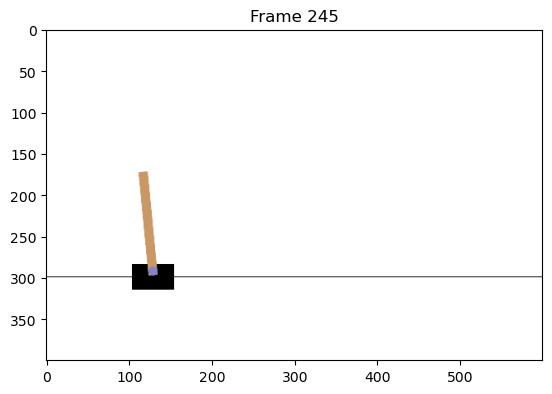

[-1.3647956  -0.8829239  -0.09859515 -0.35411444] [-1.382454   -1.0765158  -0.10567743 -0.09407695] 0
New state:  [-1.382454   -1.0765158  -0.10567743 -0.09407695] Reward:  1.0 Terminated:  False Truncated:  False


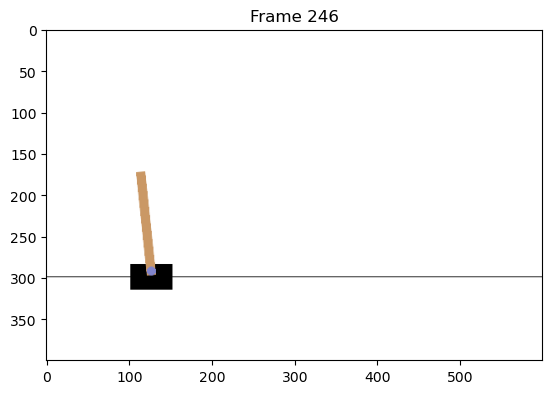

[-1.382454   -1.0765158  -0.10567743 -0.09407695] [-1.4039843  -0.8800504  -0.10755897 -0.4181424 ] 1
New state:  [-1.4039843  -0.8800504  -0.10755897 -0.4181424 ] Reward:  1.0 Terminated:  False Truncated:  False


[-1.4039843  -0.8800504  -0.10755897 -0.4181424 ] [-1.4215853  -1.0734968  -0.11592183 -0.16121098] 0
New state:  [-1.4215853  -1.0734968  -0.11592183 -0.16121098] Reward:  1.0 Terminated:  False Truncated:  False


[-1.4215853  -1.0734968  -0.11592183 -0.16121098] [-1.4430553  -1.2667849  -0.11914604  0.09277049] 0
New state:  [-1.4430553  -1.2667849  -0.11914604  0.09277049] Reward:  1.0 Terminated:  False Truncated:  False


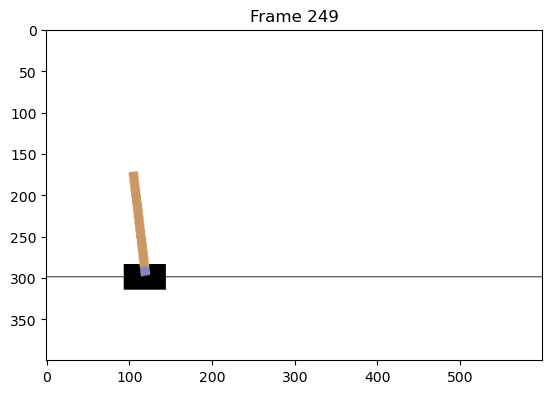

[-1.4430553  -1.2667849  -0.11914604  0.09277049] [-1.468391   -1.0701746  -0.11729063 -0.23500027] 1
New state:  [-1.468391   -1.0701746  -0.11729063 -0.23500027] Reward:  1.0 Terminated:  False Truncated:  False


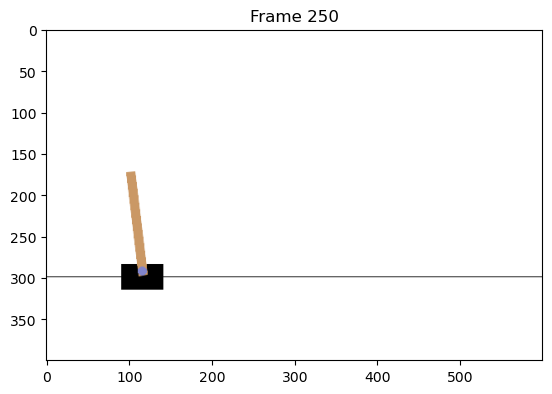

[-1.468391   -1.0701746  -0.11729063 -0.23500027] [-1.4897945  -1.2634425  -0.12199064  0.01850528] 0
New state:  [-1.4897945  -1.2634425  -0.12199064  0.01850528] Reward:  1.0 Terminated:  False Truncated:  False


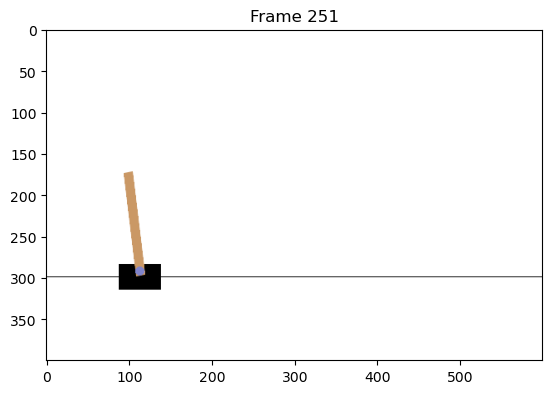

[-1.4897945  -1.2634425  -0.12199064  0.01850528] [-1.5150633  -1.0668014  -0.12162053 -0.31004062] 1
New state:  [-1.5150633  -1.0668014  -0.12162053 -0.31004062] Reward:  1.0 Terminated:  False Truncated:  False


[-1.5150633  -1.0668014  -0.12162053 -0.31004062] [-1.5363994  -1.2599996  -0.12782134 -0.05805233] 0
New state:  [-1.5363994  -1.2599996  -0.12782134 -0.05805233] Reward:  1.0 Terminated:  False Truncated:  False


[-1.5363994  -1.2599996  -0.12782134 -0.05805233] [-1.5615994  -1.0632987  -0.1289824  -0.38817388] 1
New state:  [-1.5615994  -1.0632987  -0.1289824  -0.38817388] Reward:  1.0 Terminated:  False Truncated:  False


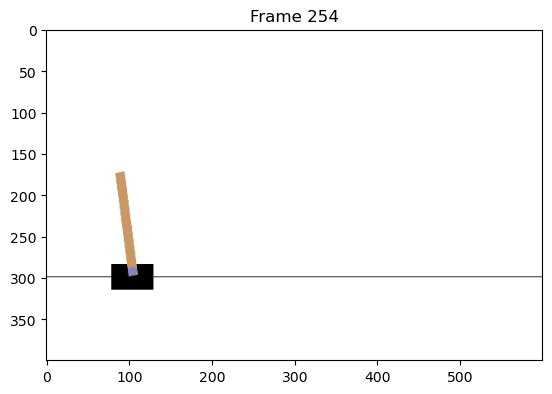

[-1.5615994  -1.0632987  -0.1289824  -0.38817388] [-1.5828654  -1.2563765  -0.13674587 -0.13877873] 0
New state:  [-1.5828654  -1.2563765  -0.13674587 -0.13877873] Reward:  1.0 Terminated:  False Truncated:  False


[-1.5828654  -1.2563765  -0.13674587 -0.13877873] [-1.6079929  -1.0595878  -0.13952145 -0.47128415] 1
New state:  [-1.6079929  -1.0595878  -0.13952145 -0.47128415] Reward:  1.0 Terminated:  False Truncated:  False


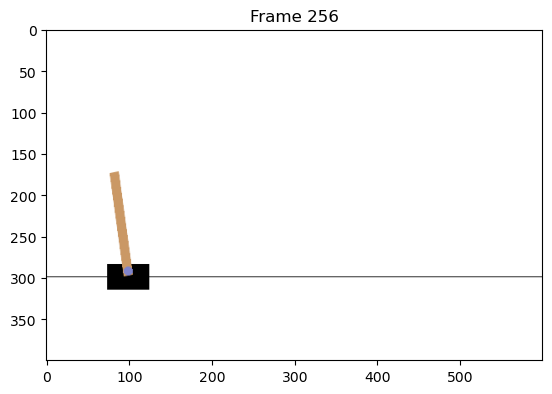

[-1.6079929  -1.0595878  -0.13952145 -0.47128415] [-1.6291846  -1.252492   -0.14894712 -0.22562623] 0
New state:  [-1.6291846  -1.252492   -0.14894712 -0.22562623] Reward:  1.0 Terminated:  False Truncated:  False


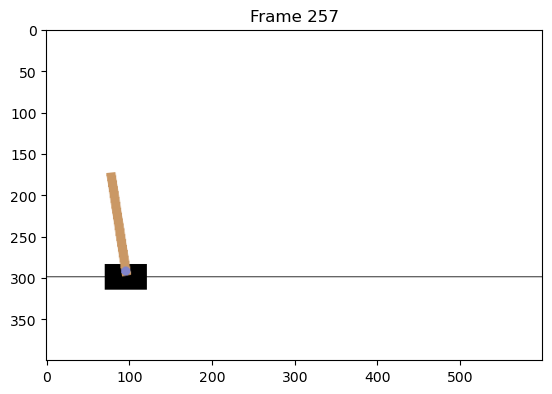

[-1.6291846  -1.252492   -0.14894712 -0.22562623] [-1.6542344  -1.445206   -0.15345965  0.01661561] 0
New state:  [-1.6542344  -1.445206   -0.15345965  0.01661561] Reward:  1.0 Terminated:  False Truncated:  False


[-1.6542344  -1.445206   -0.15345965  0.01661561] [-1.6831386  -1.2482544  -0.15312734 -0.32028028] 1
New state:  [-1.6831386  -1.2482544  -0.15312734 -0.32028028] Reward:  1.0 Terminated:  False Truncated:  False


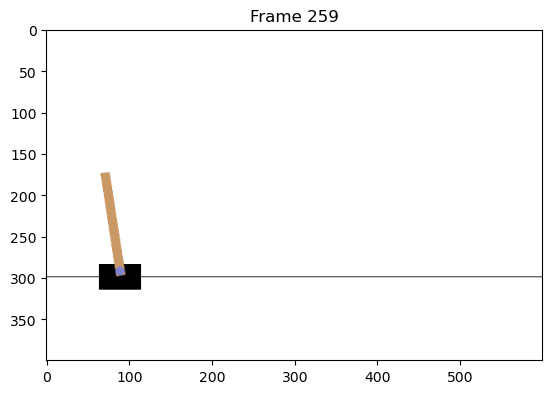

[-1.6831386  -1.2482544  -0.15312734 -0.32028028] [-1.7081037  -1.4409018  -0.15953295 -0.07953423] 0
New state:  [-1.7081037  -1.4409018  -0.15953295 -0.07953423] Reward:  1.0 Terminated:  False Truncated:  False


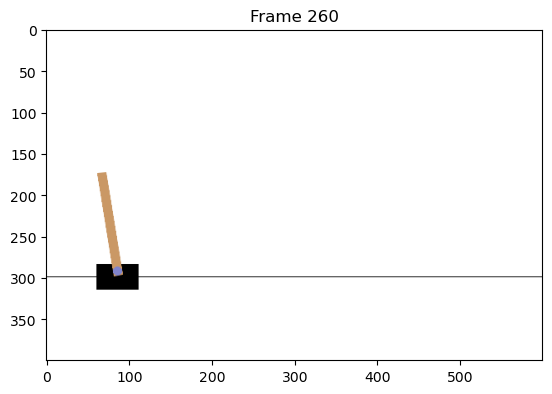

[-1.7081037  -1.4409018  -0.15953295 -0.07953423] [-1.7369217  -1.2438953  -0.16112363 -0.41799548] 1
New state:  [-1.7369217  -1.2438953  -0.16112363 -0.41799548] Reward:  1.0 Terminated:  False Truncated:  False


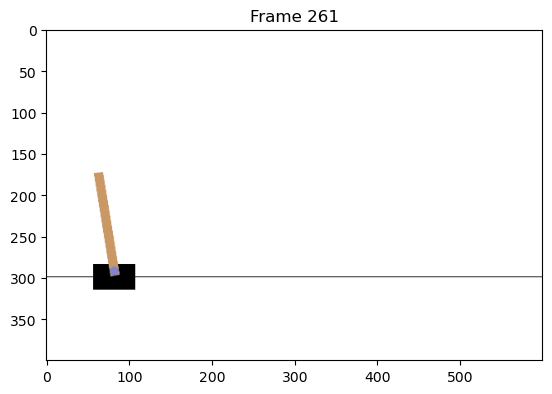

[-1.7369217  -1.2438953  -0.16112363 -0.41799548] [-1.7617996  -1.436411   -0.16948354 -0.18012774] 0
New state:  [-1.7617996  -1.436411   -0.16948354 -0.18012774] Reward:  1.0 Terminated:  False Truncated:  False


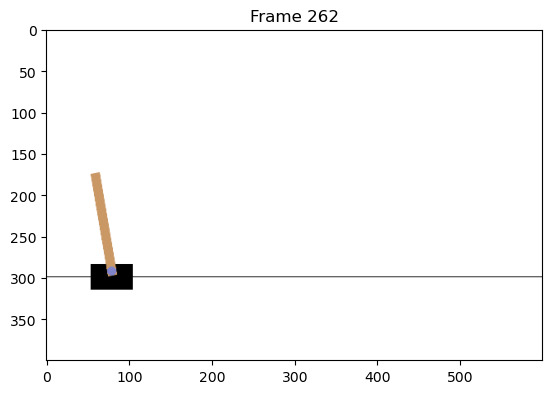

[-1.7617996  -1.436411   -0.16948354 -0.18012774] [-1.7905278  -1.2393204  -0.17308609 -0.5211178 ] 1
New state:  [-1.7905278  -1.2393204  -0.17308609 -0.5211178 ] Reward:  1.0 Terminated:  False Truncated:  False


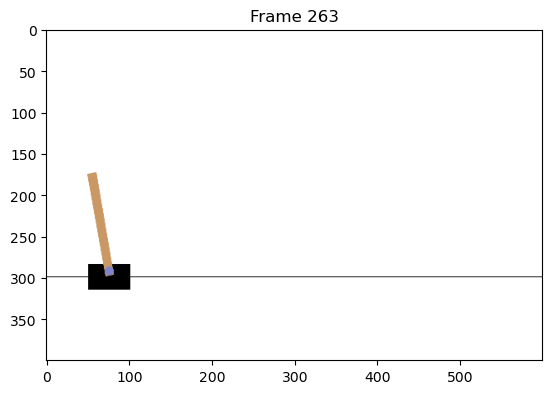

[-1.7905278  -1.2393204  -0.17308609 -0.5211178 ] [-1.8153142  -1.4316375  -0.18350846 -0.2875861 ] 0
New state:  [-1.8153142  -1.4316375  -0.18350846 -0.2875861 ] Reward:  1.0 Terminated:  False Truncated:  False


[-1.8153142  -1.4316375  -0.18350846 -0.2875861 ] [-1.8439469  -1.623733   -0.18926017 -0.05793005] 0
New state:  [-1.8439469  -1.623733   -0.18926017 -0.05793005] Reward:  1.0 Terminated:  False Truncated:  False


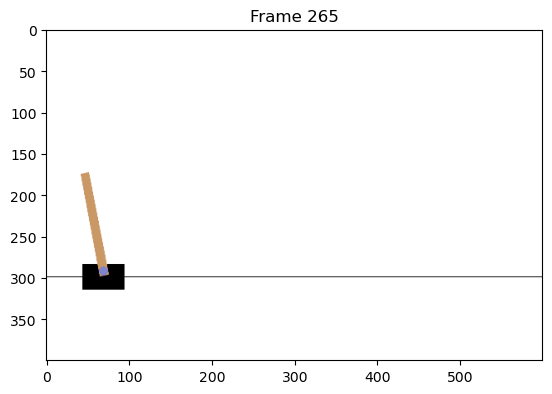

[-1.8439469  -1.623733   -0.18926017 -0.05793005] [-1.8764216  -1.4264727  -0.19041876 -0.40384802] 1
New state:  [-1.8764216  -1.4264727  -0.19041876 -0.40384802] Reward:  1.0 Terminated:  False Truncated:  False


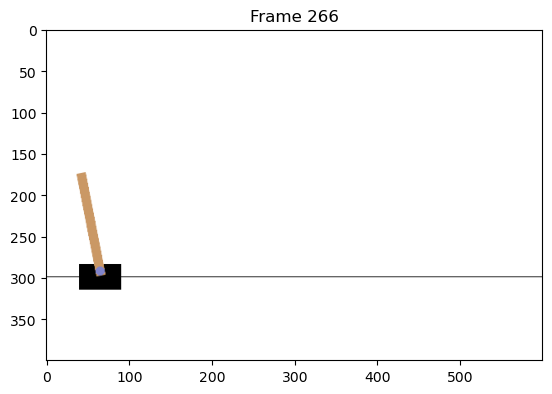

[-1.8764216  -1.4264727  -0.19041876 -0.40384802] [-1.9049511  -1.6184562  -0.19849573 -0.17672333] 0
New state:  [-1.9049511  -1.6184562  -0.19849573 -0.17672333] Reward:  1.0 Terminated:  False Truncated:  False


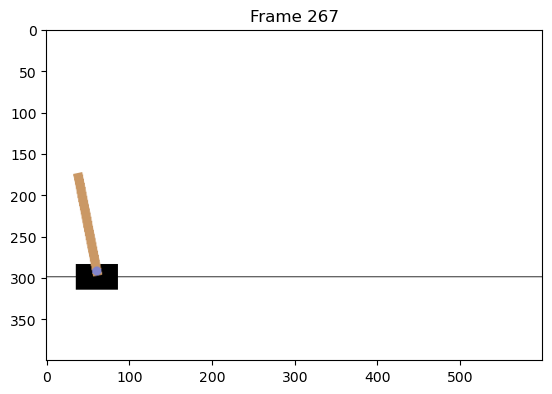

[-1.9049511  -1.6184562  -0.19849573 -0.17672333] [-1.9373202 -1.4211291 -0.2020302 -0.5248772] 1
New state:  [-1.9373202 -1.4211291 -0.2020302 -0.5248772] Reward:  1.0 Terminated:  False Truncated:  False


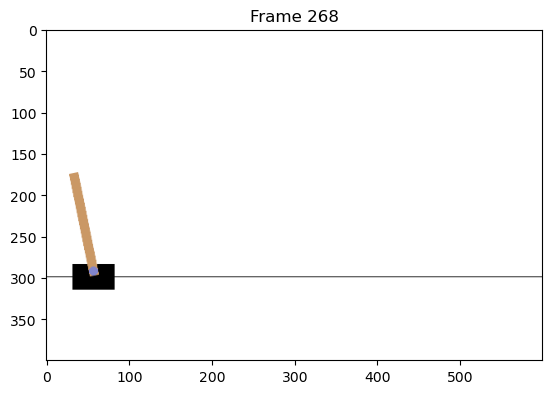

[-1.9373202 -1.4211291 -0.2020302 -0.5248772] [-1.9657428  -1.6129208  -0.21252774 -0.3020346 ] 0
New state:  [-1.9657428  -1.6129208  -0.21252774 -0.3020346 ] Reward:  1.0 Terminated:  True Truncated:  False


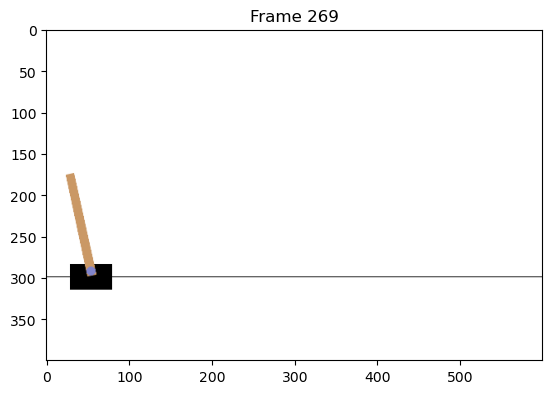

In [6]:
import matplotlib.pyplot as plt

from IPython.display import clear_output
from time import sleep

env=gym.make("CartPole-v1",render_mode="rgb_array")

state_dim = 4
action_dim = env.action_space.n

class ActorPredNwk(nn.Module):
    def __init__(self,input_dim,out_dim,
                 hidden1_dim=256,
                 hidden2_dim=256,
                 checkpoint_file = 'tmp/actor'
                 ):
        super(ActorPredNwk, self).__init__()

        self.checkpoint_file = checkpoint_file
        self.actor_nwk = nn.Sequential(
            nn.Linear(input_dim,hidden1_dim),
            nn.ReLU(),
            nn.Linear(hidden1_dim,hidden2_dim),
            nn.ReLU(),
            nn.Linear(hidden2_dim,out_dim),  
            nn.Softmax(dim=-1)
        )

    def forward(self,state):
        x = torch.Tensor(state)
        out = self.actor_nwk(x)
        return out
    
    def load_checkpoint(self):
        self.load_state_dict(torch.load(self.checkpoint_file))

    
policy_nwk = ActorPredNwk(input_dim=state_dim,out_dim=action_dim)
policy_nwk.load_checkpoint()

current_state,info = env.reset()

terminated,truncated = False,False
i = 1
while not (terminated or truncated): 
    
    action = policy_nwk(current_state)
    action = torch.argmax(action).item()
    new_state,reward,terminated,truncated,info = env.step(action)
    print(current_state,new_state,action)
    print('New state: ', new_state,'Reward: ',reward,'Terminated: ',terminated,'Truncated: ',truncated) 
    current_state = new_state 
    plt.title(f'Frame {i}')
    i += 1
    plt.imshow(env.render())
    plt.show()
   
   
